In this script the standard one class classification models are compared with the Deep One Class Model

# Import the datasets

In [1]:
# Import the libraries
from sklearn import datasets, metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import percentile
import sys
from matplotlib import rcParams
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
# Import the labeled dataset after the feature engineering for evaluating the standard one class algorithms

df= pd.read_pickle('../data/df_reduced.pkl')
df=df.fillna(0)
df.head()

,Identifier,nBM,nHet,ZM1V,DBI,MAXDN,MAXDP,DELS,CIC0,J_D/Dt,...,SpMax3_Bh(s),SpMax7_Bh(s),P_VSA_v_2,P_VSA_s_6,Eta_F_A,Eig02_AEA(dm),Eig03_AEA(dm),Eig04_AEA(dm),nHAcc,Uc
0,WOVMEB,0.034483,0.000000,0.018611,0.073325,0.027142,0.008182,0.001948,0.280067,0.039639,...,0.321908,0.493806,0.000000,0.000000,0.449448,0.498103,0.607893,0.667916,0.000000,0.796001
1,PIWKEL,0.057471,0.088889,0.116679,0.146649,0.184005,0.368062,0.063556,0.321768,0.186531,...,0.062123,0.099236,0.000000,0.000000,0.279807,0.709408,0.604336,0.668781,0.000000,0.268420
2,OTIHIJ,0.195402,0.044444,0.147459,0.302317,0.110113,0.024137,0.020041,0.600334,0.104237,...,0.090555,0.005535,0.000000,0.000000,0.408383,0.007018,0.169377,0.010378,0.000000,0.376728
3,DABLOJ,0.005747,0.044444,0.027201,0.163954,0.170389,0.192418,0.012151,0.154962,0.000000,...,0.695813,0.498814,0.326708,0.211564,0.615973,0.644917,0.659383,0.715624,0.131579,0.607167
4,PIGJUK,0.074713,0.088889,0.110952,0.179572,0.027324,0.022024,0.007123,0.349291,0.169320,...,0.695813,0.443068,0.318692,0.211564,0.558482,0.623293,0.655318,0.712165,0.105263,0.464233


In [3]:
cd ../models/standard_models/

c:\Users\kvriz\Documents\GitHub\cocrystal_design\models\standard_models


In [4]:
# Import all models

from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.cblof import CBLOF
from sklearn.mixture import GaussianMixture
from sklearn.utils import (indexable, check_random_state, _safe_indexing,
                     _message_with_time)
from sklearn.model_selection._split import check_cv
from sklearn.base import is_classifier, clone
from sklearn.metrics import check_scoring
from joblib import Parallel, delayed
from sklearn.utils.validation import _check_fit_params
import time
from sklearn.utils.metaestimators import _safe_split
from sklearn.model_selection._validation import _translate_train_sizes
from sklearn.utils import (indexable, check_random_state, _safe_indexing,
                     _message_with_time)
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator
from contextlib import suppress
from sklearn.model_selection import ShuffleSplit
import numbers
import warnings


## Calculate the learing curves for the standard models

In [5]:
# Built the Gaussian Mixture Classifier to be used for anomaly detection
from sklearn.base import BaseEstimator
contamination =0.05


class GMM(GaussianMixture):
  def __init__(self, n_components, covariance_type, random_state):
    super().__init__(n_components=n_components , covariance_type=covariance_type, random_state=random_state)

  def fit(self, X, y):
    super().fit(X, y)
    self.prob = super().score_samples(X_train)
    self.c = percentile(self.prob, 100 * contamination)

  def predict(self, X):
    scores = []
    proba=super().score_samples(X)
    
    scores =(proba <= self.c).astype('int').ravel()
     
    return scores

In [6]:
def _fit_and_score(estimator, X, y, scorer, train, test, verbose,
                   parameters, fit_params, return_train_score=False,
                   return_parameters=False, return_n_test_samples=False,
                   return_times=False, return_estimator=False,
                   error_score=np.nan):

    if verbose > 1:
        if parameters is None:
            msg = ''
        else:
            msg = '%s' % (', '.join('%s=%s' % (k, v)
                          for k, v in parameters.items()))
        print("[CV] %s %s" % (msg, (64 - len(msg)) * '.'))

    # Adjust length of sample weights
    fit_params = fit_params if fit_params is not None else {}
    fit_params = _check_fit_params(X, fit_params, train)

    train_scores = {}
    if parameters is not None:
        # clone after setting parameters in case any parameters
        # are estimators (like pipeline steps)
        # because pipeline doesn't clone steps in fit
        cloned_parameters = {}
        for k, v in parameters.items():
            cloned_parameters[k] = clone(v, safe=False)

        estimator = estimator.set_params(**cloned_parameters)

    start_time = time.time()

    X_train, y_train = _safe_split(estimator, X, y, train)
    X_train = pd.concat([X_train, pd.concat([X_train.iloc[:, 24:], X_train.iloc[:, :24]], axis=1)]) #pd.concat([X_train.iloc[:, :24], X_train.iloc[:, 24:]], axis=1),
    y_train = np.concatenate([y_train, y_train])
    X_test, y_test = _safe_split(estimator, X, y, test, train)

    try:
        if y_train is None:
            estimator.fit(X_train, **fit_params)
        else:
            estimator.fit(X_train, y_train, **fit_params)

    except Exception as e:
        # Note fit time as time until error
        fit_time = time.time() - start_time
        score_time = 0.0
        if error_score == 'raise':
            raise
        elif isinstance(error_score, numbers.Number):
            if isinstance(scorer, dict):
                test_scores = {name: error_score for name in scorer}
                if return_train_score:
                    train_scores = test_scores.copy()
            else:
                test_scores = error_score
                if return_train_score:
                    train_scores = error_score
            warnings.warn("Estimator fit failed. The score on this train-test"
                          " partition for these parameters will be set to %f. "
                          "Details: \n%s" %
                          (error_score, format_exception_only(type(e), e)[0]),
                          FitFailedWarning)
        else:
            raise ValueError("error_score must be the string 'raise' or a"
                             " numeric value. (Hint: if using 'raise', please"
                             " make sure that it has been spelled correctly.)")

    else:
        fit_time = time.time() - start_time
        test_scores = _score(estimator, X_test, y_test, scorer)
        score_time = time.time() - start_time - fit_time
        if return_train_score:
            train_scores = _score(estimator, X_train, y_train, scorer)
    if verbose > 2:
        if isinstance(test_scores, dict):
            for scorer_name in sorted(test_scores):
                msg += ", %s=" % scorer_name
                if return_train_score:
                    msg += "(train=%.3f," % train_scores[scorer_name]
                    msg += " test=%.3f)" % test_scores[scorer_name]
                else:
                    msg += "%.3f" % test_scores[scorer_name]
        else:
            msg += ", score="
            msg += ("%.3f" % test_scores if not return_train_score else
                    "(train=%.3f, test=%.3f)" % (train_scores, test_scores))

    if verbose > 1:
        total_time = score_time + fit_time
        print(_message_with_time('CV', msg, total_time))

    ret = [train_scores, test_scores] if return_train_score else [test_scores]

    if return_n_test_samples:
        ret.append(_num_samples(X_test))
    if return_times:
        ret.extend([fit_time, score_time])
    if return_parameters:
        ret.append(parameters)
    if return_estimator:
        ret.append(estimator)
    return ret


def _score(estimator, X_test, y_test, scorer):
    """Compute the score(s) of an estimator on a given test set.
    Will return a dict of floats if `scorer` is a dict, otherwise a single
    float is returned.
    """
    if isinstance(scorer, dict):
        # will cache method calls if needed. scorer() returns a dict
        scorer = _MultimetricScorer(**scorer)
    if y_test is None:
        scores = scorer(estimator, X_test)
    else:
        scores = scorer(estimator, X_test, y_test)

    error_msg = ("scoring must return a number, got %s (%s) "
                 "instead. (scorer=%s)")
    if isinstance(scores, dict):
        for name, score in scores.items():
            if hasattr(score, 'item'):
                with suppress(ValueError):
                    # e.g. unwrap memmapped scalars
                    score = score.item()
            if not isinstance(score, numbers.Number):
                raise ValueError(error_msg % (score, type(score), name))
            scores[name] = score
    else:  # scalar
        if hasattr(scores, 'item'):
            with suppress(ValueError):
                # e.g. unwrap memmapped scalars
                scores = scores.item()
        if not isinstance(scores, numbers.Number):
            raise ValueError(error_msg % (scores, type(scores), scorer))
    return scores


In [7]:
def learning_curve(estimator, X, y, groups=None,
                   train_sizes=np.linspace(0.1, 1.0, 5), cv=None,
                   scoring=None, exploit_incremental_learning=False,
                   n_jobs=None, pre_dispatch="all", verbose=0, shuffle=False,
                   random_state=None, error_score=np.nan, return_times=False):
  
    X, y, groups = indexable(X, y, groups)

    if exploit_incremental_learning and not hasattr(estimator, "partial_fit"):
        raise ValueError("An estimator must support the partial_fit interface "
                         "to exploit incremental learning")
    X, y, groups = indexable(X, y, groups)

    cv = check_cv(cv, y, classifier=is_classifier(estimator))
    # Store it as list as we will be iterating over the list multiple times
    cv_iter = list(cv.split(X, y, groups))

    scorer = check_scoring(estimator, scoring=scoring)

    n_max_training_samples = len(cv_iter[0][0])
    # Because the lengths of folds can be significantly different, it is
    # not guaranteed that we use all of the available training data when we
    # use the first 'n_max_training_samples' samples.
    train_sizes_abs = _translate_train_sizes(train_sizes,
                                             n_max_training_samples)
    n_unique_ticks = train_sizes_abs.shape[0]
    if verbose > 0:
        print("[learning_curve] Training set sizes: " + str(train_sizes_abs))

    parallel = Parallel(n_jobs=n_jobs, pre_dispatch=pre_dispatch,
                        verbose=verbose)

    if shuffle:
        rng = check_random_state(random_state)
        cv_iter = ((rng.permutation(train), test) for train, test in cv_iter)

    if exploit_incremental_learning:
        classes = np.unique(y) if is_classifier(estimator) else None
        out = parallel(delayed(_incremental_fit_estimator)(
            clone(estimator), X, y, classes, train, test, train_sizes_abs,
            scorer, verbose, return_times) for train, test in cv_iter)
    else:
        train_test_proportions = []
        for train, test in cv_iter:
            for n_train_samples in train_sizes_abs:
                train1 = train[:n_train_samples]
                train_test_proportions.append((train1, test))

        out = parallel(delayed(_fit_and_score)(
            clone(estimator), X, y, scorer, train, test, verbose,
            parameters=None, fit_params=None, return_train_score=True,
            error_score=error_score, return_times=return_times)
            for train, test in train_test_proportions)
        out = np.array(out)
        n_cv_folds = out.shape[0] // n_unique_ticks
        dim = 4 if return_times else 2
        out = out.reshape(n_cv_folds, n_unique_ticks, dim)

    out = np.asarray(out).transpose((2, 1, 0))

    ret = train_sizes_abs, out[0], out[1]

    if return_times:
        ret = ret + (out[2], out[3])

    return ret


In [13]:
#github repo!!!!
classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components= 2, covariance_type='full', random_state=None), 
      'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)':  HBOS(contamination=0.05, n_bins=16, alpha=0.7), # HBOS(contamination=0.05, n_bins=20, alpha=0.5), ## HBOS(contamination=0.05, n_bins=8, alpha=0.9, tol=0.6) , #HBOS(contamination=0.05, n_bins=20, alpha=0.5),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=15), contamination=0.05),
    
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=11, contamination=0.05),  #20
     'CBLOF':   CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12)
}

In [14]:
# Final attempt
classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components= 4, covariance_type='full', random_state=None), 
      'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)':  HBOS(contamination=0.05, n_bins=16, alpha=0.7), # HBOS(contamination=0.05, n_bins=20, alpha=0.5), ## HBOS(contamination=0.05, n_bins=8, alpha=0.9, tol=0.6) , #HBOS(contamination=0.05, n_bins=20, alpha=0.5),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=8), contamination=0.05),
    
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000, random_state=0), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=11, contamination=0.05),  #20
     'CBLOF':   CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12)
}

/content/pyod/pyod/models/knn.py:160: FutureWarning: algorithm parameter is deprecated and will be removed in version 0.7.6. By default, ball_tree will be used.
  FutureWarning)


In [124]:
classifiers = {
    'Gaussiann Mixture Model (GMM)':
      GMM(n_components=4, covariance_type='full', random_state=None),
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)':  HBOS(contamination=0.05, n_bins=16, alpha=0.7), 
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=15), contamination=0.05),
    
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=5, contamination=0.05),
     'CBLOF': CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12) # CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=9)
     }

In [112]:
#####old
classifiers = {
    'Gaussiann Mixture Model (GMM)':
       GMM(n_components=4, covariance_type='full', random_state=None),
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=0.05, n_bins=8, alpha=0.9, tol=0.6),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=15), contamination=0.05),
    
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=5, contamination=0.05),
     'CBLOF': CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=9)}

In [24]:
# Final attempt new
classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components= 4, covariance_type='full', random_state=None), 
      'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)':  HBOS(contamination=0.05, n_bins=16, alpha=0.7), 
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=15), contamination=0.05),
        'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000, random_state=0), contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), 
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=7, contamination=0.05), 
     'CBLOF':   CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12)
}

In [19]:
# Built an ensemble of all the implemented algorithms
from sklearn.base import BaseEstimator

class Ensemble(BaseEstimator):
  def __init__(self, classifiers):
    self.classifiers = classifiers

  def fit(self, X, y):
    for clf in classifiers.values():
      clf.fit(X, y)

  def predict(self, X):
    scores = []
    for clf in classifiers.values():
      scores.append(clf.predict(X))
     
    return (np.mean(scores, 0) >= 0.5).astype('int').ravel()


In [69]:
# Final attempt new  naki naki tobenaki
classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components= 4, covariance_type='full', random_state=None), 
      'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)':  HBOS(contamination=0.05, n_bins=16, alpha=0.7), # HBOS(contamination=0.05, n_bins=20, alpha=0.5), ## HBOS(contamination=0.05, n_bins=8, alpha=0.9, tol=0.6) , #HBOS(contamination=0.05, n_bins=20, alpha=0.5),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=15), contamination=0.05),
        'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000, random_state=0), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=10, contamination=0.05), 
     'CBLOF':   CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12)
}

In [48]:
# Calculate the learning curves of the Ensemble
#from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score

# The training set becomes an input to the classifiers in a bidirectional way, to ensure that in each 
# fold the training is order invariant

X_train=df.iloc[:1722, 1:]
y=np.zeros(X_train.shape[0])

clf  = Ensemble(classifiers) 

scoring = make_scorer(accuracy_score)
train_sizes=np.linspace(.02, 1.0, 20)

train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(clf, X_train, y , scoring = scoring ,train_sizes=train_sizes, 
                       random_state= 0, return_times=True)

train_sizes = train_sizes*2        
train_scores_mean_ens = np.mean(train_scores, axis=1)*100
train_scores_std_ens = np.std(train_scores, axis=1)*100
test_scores_mean_ens = np.mean(test_scores, axis=1)*100
test_scores_std_ens = np.std(test_scores, axis=1)*100

print(train_sizes)
print(test_scores_mean_ens)
test_scores_std_ens

[  54  196  338  480  622  764  906 1048 1190 1332 1474 1616 1758 1900
 2042 2184 2326 2468 2610 2754]
[78.75817324 70.10684193 69.98938322 74.17054264 79.16599259 83.63262555
 83.86299292 85.66514998 84.21452646 84.79642737 86.5958881  91.64138861
 93.49578699 93.6124031  93.49612403 93.49679811 93.6710482  93.61341422
 93.20795416 93.32406471]


array([15.06418291, 13.45821287, 12.79762522, 16.45580333, 18.71033045,
       13.0474963 , 12.2629874 , 12.4398257 , 14.36445698, 14.90788884,
       13.07587619,  4.74726745,  2.03610981,  1.81798072,  2.09071476,
        2.59778651,  2.32268216,  3.04565838,  3.99675596,  3.96507456])

In [46]:
#from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy=[]
std=[]

X_train=df.iloc[:1722, 1:]
y=np.zeros(X_train.shape[0])
scoring = make_scorer(accuracy_score)
train_sizes=np.linspace(.02, 1.0, 20)

for i, (clf_name, clf) in enumerate(classifiers.items()):
  train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(clf, X_train, y , scoring = scoring ,train_sizes=train_sizes, #shuffle=True, random_state= 0,
                       return_times=True)        
  train_scores_mean = np.mean(train_scores, axis=1)*100
  train_scores_std = np.std(train_scores, axis=1)*100
  test_scores_mean = np.mean(test_scores, axis=1)*100
  test_scores_std = np.std(test_scores, axis=1)*100
  accuracy.append(test_scores_mean)
  std.append(test_scores_std)

In [47]:
accuracy

[array([91.6991911 , 91.58308055, 92.223121  , 91.63919784, 91.0594877 ,
        93.3198517 , 93.26255477, 93.84159083, 92.10212336, 93.67037412,
        92.45062353, 90.70997641, 90.99949444, 91.75530839, 91.4066397 ,
        91.2330637 , 90.76828446, 90.94253455, 91.05881362, 92.10532524]),
 array([82.81782946, 69.17307044, 70.50724638, 73.70357263, 80.2669363 ,
        83.68874284, 83.10650489, 86.01297607, 85.08543984, 85.26070104,
        87.0008426 , 91.9288844 , 92.33434446, 92.33434446, 92.21789687,
        92.45045501, 92.9148972 , 93.20475228, 93.08897877, 93.32119987]),
 array([81.44421975, 83.52679474, 73.99528143, 74.86434109, 77.41877317,
        78.46343108, 79.91607685, 79.45163465, 79.68452983, 81.37074486,
        82.53303   , 85.49393327, 87.87259858, 89.32322211, 88.85979103,
        88.97657567, 88.91978429, 89.03589484, 88.86164476, 89.0364004 ]),
 array([80.38439501, 76.43781598, 70.57414897, 79.92382878, 82.6536906 ,
        90.53741153, 90.82743512, 89.83956859

In [72]:
accuracy

[array([91.75716212, 91.58308055, 91.70020222, 91.29036063, 91.69683182,
        92.50707786, 93.43596225, 93.26204921, 90.93832154, 92.56572295,
        91.46343108, 90.65234243, 90.70879676, 90.71031345, 91.81361645,
        91.58206943, 91.05915066, 90.07162117, 90.82591844, 91.05915066]),
 array([82.81782946, 69.17307044, 70.50724638, 73.70357263, 80.2669363 ,
        83.68874284, 83.10650489, 86.01297607, 85.08543984, 85.26070104,
        87.0008426 , 91.9288844 , 92.33434446, 92.33434446, 92.21789687,
        92.45045501, 92.9148972 , 93.20475228, 93.08897877, 93.32119987]),
 array([81.44421975, 83.52679474, 73.99528143, 74.86434109, 77.41877317,
        78.46343108, 79.91607685, 79.45163465, 79.68452983, 81.37074486,
        82.53303   , 85.49393327, 87.87259858, 89.32322211, 88.85979103,
        88.97657567, 88.91978429, 89.03589484, 88.86164476, 89.0364004 ]),
 array([80.72817661, 73.59201213, 69.2313785 , 73.76356589, 81.37495787,
        89.0842602 , 88.62032356, 90.190091  

In [35]:
accuracy

[array([91.6991911 , 91.58308055, 90.94438827, 91.34850017, 89.48887765,
        93.26204921, 93.08729356, 93.37714863, 91.40208965, 92.68200202,
        91.63784968, 91.00050556, 90.82625548, 90.59437142, 91.40781935,
        91.11678463, 90.65267947, 90.70997641, 91.05915066, 91.52426694]),
 array([82.81782946, 69.17307044, 70.50724638, 73.70357263, 80.2669363 ,
        83.68874284, 83.10650489, 86.01297607, 85.08543984, 85.26070104,
        87.0008426 , 91.9288844 , 92.33434446, 92.33434446, 92.21789687,
        92.45045501, 92.9148972 , 93.20475228, 93.08897877, 93.32119987]),
 array([81.44421975, 83.52679474, 73.99528143, 74.86434109, 77.41877317,
        78.46343108, 79.91607685, 79.45163465, 79.68452983, 81.37074486,
        82.53303   , 85.49393327, 87.87259858, 89.32322211, 88.85979103,
        88.97657567, 88.91978429, 89.03589484, 88.86164476, 89.0364004 ]),
 array([80.61105494, 75.09925851, 71.14964611, 75.50606673, 81.43410853,
        88.96899225, 90.76879002, 91.17644085

In [43]:
accuracy

[array([91.75716212, 91.87377823, 91.87445231, 91.98803505, 90.94219751,
        92.21553758, 93.61038086, 93.31934614, 93.72817661, 93.43528817,
        92.10279744, 91.40781935, 90.71031345, 91.40697674, 91.29069767,
        92.04718571, 91.00050556, 91.40765083, 91.4661274 , 91.98938322]),
 array([82.81782946, 69.17307044, 70.50724638, 73.70357263, 80.2669363 ,
        83.68874284, 83.10650489, 86.01297607, 85.08543984, 85.26070104,
        87.0008426 , 91.9288844 , 92.33434446, 92.33434446, 92.21789687,
        92.45045501, 92.9148972 , 93.20475228, 93.08897877, 93.32119987]),
 array([81.44421975, 83.52679474, 73.99528143, 74.86434109, 77.41877317,
        78.46343108, 79.91607685, 79.45163465, 79.68452983, 81.37074486,
        82.53303   , 85.49393327, 87.87259858, 89.32322211, 88.85979103,
        88.97657567, 88.91978429, 89.03589484, 88.86164476, 89.0364004 ]),
 array([79.3950118 , 72.77789012, 68.77300303, 75.15722952, 81.43360297,
        89.37580047, 89.14273677, 89.90107853

In [25]:
accuracy

[array([91.9900573 , 91.52494102, 91.75834176, 91.11678463, 91.29120324,
        93.20390967, 93.26154365, 93.55190428, 93.96258847, 90.00893158,
        91.46343108, 90.3611392 , 90.94287159, 91.46579036, 91.52291877,
        91.00067408, 91.52376138, 91.2330637 , 90.65217391, 91.17576677]),
 array([82.81782946, 69.17307044, 70.50724638, 73.70357263, 80.2669363 ,
        83.68874284, 83.10650489, 86.01297607, 85.08543984, 85.26070104,
        87.0008426 , 91.9288844 , 92.33434446, 92.33434446, 92.21789687,
        92.45045501, 92.9148972 , 93.20475228, 93.08897877, 93.32119987]),
 array([81.44421975, 83.52679474, 73.99528143, 74.86434109, 77.41877317,
        78.46343108, 79.91607685, 79.45163465, 79.68452983, 81.37074486,
        82.53303   , 85.49393327, 87.87259858, 89.32322211, 88.85979103,
        88.97657567, 88.91978429, 89.03589484, 88.86164476, 89.0364004 ]),
 array([80.26659926, 75.04499494, 70.62858106, 80.38742838, 83.35153354,
        90.48146276, 90.88523761, 90.30502191

### Calculate k-fold cross validation for the standard models

In [12]:
def cross_val(clf1):
  valid =[]
  X_train= df.iloc[:, 1:]
  X_train_val=pd.concat([pd.DataFrame(X_train.values), pd.DataFrame(np.zeros(len(X_train)))], axis=1)

  # Perform k-fold cross validation
  from sklearn.model_selection import KFold
  kf = KFold(n_splits = 5)
  kf.get_n_splits(X_train_val)

  for train, test in kf.split(X_train_val):
      train_data = np.array(X_train_val)[train]
      #print(train_data.shape)
      train_label = train_data[:,-1]
      test_data = np.array(X_train_val)[test]
      test_label = test_data[:, -1]
      clf1.fit(train_data[:, :-1],train_label )
      pred_train = clf.predict(train_data[:,:-1])
      pred_test = clf.predict(test_data[:,:-1])
      valid.append(metrics.accuracy_score(pred_test, test_label))
  print(valid)
  return valid

In [45]:
# Final attempt new  naki naki tobenaki
classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components= 4, covariance_type='full', random_state=None), 
      'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)':  HBOS(contamination=0.05, n_bins=16, alpha=0.7), # HBOS(contamination=0.05, n_bins=20, alpha=0.5), ## HBOS(contamination=0.05, n_bins=8, alpha=0.9, tol=0.6) , #HBOS(contamination=0.05, n_bins=20, alpha=0.5),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=8), contamination=0.05),
        'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000, random_state=0), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=10, contamination=0.05), 
     'CBLOF':    CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12)
    
}

In [49]:
from random import Random
from sklearn.model_selection import KFold
val_list = []
df=df.fillna(0)
X_train= df.iloc[:, 1:]
X_train_val=pd.concat([pd.DataFrame(X_train.values), pd.DataFrame(np.zeros(len(X_train)))], axis=1)

kf = KFold(n_splits = 5,   shuffle=True,  random_state=0)

for i, (clf_name, clf) in enumerate(classifiers.items()):
  k = cross_val(clf)
  val_list.append(k)


[0.9085631349782293, 0.9404934687953556, 0.8969521044992743, 0.969521044992743, 0.8677325581395349]
[0.941944847605225, 0.9477503628447025, 0.9216255442670537, 0.9492017416545718, 0.8997093023255814]
[0.8432510885341074, 0.9085631349782293, 0.8621190130624092, 0.9521044992743106, 0.8866279069767442]
[0.9346879535558781, 0.9375907111756169, 0.93033381712627, 0.95355587808418, 0.9258720930232558]
[0.9288824383164006, 0.9158200290275762, 0.9143686502177069, 0.969521044992743, 0.9026162790697675]
[0.9245283018867925, 0.9288824383164006, 0.9027576197387518, 0.9361393323657474, 0.8851744186046512]
[0.93033381712627, 0.9448476052249637, 0.9404934687953556, 0.9506531204644412, 0.9186046511627907]
[0.9564586357039188, 0.9390420899854862, 0.941944847605225, 0.9506531204644412, 0.9331395348837209]


In [50]:
#Calcualte the k-fold accuracy of the ensemble

clf_ens = Ensemble(classifiers)
ens_kfold = cross_val(clf_ens)

[0.9680696661828737, 0.9346879535558781, 0.9317851959361393, 0.93033381712627, 0.9287790697674418]


In [51]:
print(np.mean(val_list, 1))
print(np.std(val_list, 1))

[0.91665246 0.93204636 0.89053313 0.93640809 0.92624169 0.91549642
 0.93698653 0.94424765]
[0.03524253 0.0189377  0.0378796  0.00944784 0.02318541 0.0188074
 0.0113404  0.0083178 ]


In [52]:
print(np.mean(ens_kfold, 0))
print(np.std(ens_kfold, 0))


0.9387311405137206
0.014797981940135069


In [53]:
ens_kfold

[0.9680696661828737,
 0.9346879535558781,
 0.9317851959361393,
 0.93033381712627,
 0.9287790697674418]

# Evaluate the deep network

### Calculate the learning curve for the neural network

In [ ]:
# Import the neural network architectures and libraries
%cd /content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch
%cd src/set_transformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
from modules import SAB, PMA, ISAB
import tqdm
#torch.cuda.empty_cache() 
% cd ..
from base.torchvision_dataset import TorchvisionDataset
import logging
import random
from utils.config import Config
#from utils.visualization.plot_images_grid import plot_images_grid
import deepSVDD
from base.base_net import BaseNet


In [ ]:
INPUT_DIM = 3714

class Pairs_Dataset(TorchvisionDataset):

    def __init__(self, root: str, train_idx=None, test_idx=None, data=None):
        super().__init__(root)
        ## Loading the train set
        self.train_set = Pairs(root=self.root, train=True, data=data)
        if train_idx is not None:
          self.train_set = Subset(self.train_set, train_idx)
        ## Loading the test set
        self.test_set = Pairs(root=self.root, train=False, data=data)
        if test_idx is not None:
            self.test_set = Subset(self.test_set, test_idx)

class Pairs(Dataset):

    def __init__(self, root, train, data=None):
        super(Pairs, self).__init__()

        self.train = train

        if data is None:
          self.data=labelled.values.astype('f')

        else:
          self.data = data.values.astype('f')
        self.labels = np.zeros(self.data.shape[0])
          

    # This is used to return a single datapoint. A requirement from pytorch
    def __getitem__(self, index):
        return self.data[index], self.labels[index], index

    # For Pytorch to know how many datapoints are in the dataset
    def __len__(self):
        return len(self.data)

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


In [ ]:
INPUT_DIM =  1857

class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 100
        self.seq = nn.Sequential(SAB(dim_in=1857, dim_out=1000, num_heads=10),
            SAB(dim_in=1000, dim_out=500, num_heads=5),
            SAB(dim_in=500, dim_out=100, num_heads=10),
            PMA(dim=100, num_heads=5, num_seeds=1))
        
    def forward(self, x):
      x = torch.split(x, 1857, dim=1)     
      x= torch.stack(x).transpose(0,1) 
      return self.seq(x).squeeze()

class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder =  nn.Sequential( nn.Linear(in_features=100, out_features=1857), nn.LeakyReLU(),
          nn.Linear(in_features=1857, out_features=3714), nn.Sigmoid())
        self.decoder.apply(init_weights)

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
def build_autoencoder(net_name):
    return PairsAutoEncoder()
    #return nn.Sequential()~

def build_network(net_name):
  
  return PairsEncoder()
    #return nn.Sequential()
torch.manual_seed(0)
deepSVDD.build_network = build_network
deepSVDD.build_autoencoder = build_autoencoder

In [ ]:

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
log_file = './log.txt'
file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [ ]:
cfg = Config({'normal_class': 1, 
              'n_jobs_dataloader': 0, 
              'ae_weight_decay': 0.0005, 
              'ae_batch_size': 200, 
              'ae_lr_milestone': (50,), 
              'ae_n_epochs': 5, 
              'ae_lr': 0.0001,
              'ae_optimizer_name': 'adam', 
              'pretrain': True, 
              'weight_decay': 5e-07,
              'batch_size': 200, 
              'lr_milestone': (50,),
              'n_epochs': 5, 
              'lr': 0.0001, 
              'optimizer_name': 'adam', 
              'seed': -1, 
              'device': 'cuda', 
              'nu': 0.05, 
              'objective':  'one-class', 
              'load_model': None, 
              'load_config': None,'dataset_name': 'cocry', 'net_name': 'CocryNet'} )

In [ ]:
dataset_name = cfg.settings['dataset_name']
normal_class = cfg.settings['normal_class']
net_name = cfg.settings['net_name']
n_jobs_dataloader = 0
dataset = Pairs_Dataset('', data=df.iloc[:, 1:])

In [ ]:
torch.manual_seed(0)
deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
deep_SVDD.set_network(net_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from sklearn import metrics
scores1=[]

def Average(lst): 
    return sum(lst) / len(lst) 
def deep_one_test(trainer, dataset: Pairs_Dataset(''), net: BaseNet, threshold=None):
        logger = logging.getLogger()
        nu = 0.05
        # Set device for network
        device = 'cuda'
        net = net.to(trainer.device)        
        if threshold == None:
          threshold = get_R(trainer, dataset, net, nu)           
        
        #print('Thres:', threshold)
        # Get test data loader
        _, test_loader = dataset.loaders(batch_size=trainer.batch_size, num_workers=trainer.n_jobs_dataloader)

        # Testing
        logger.info('Starting testing...')
        #start_time = time.time()
        idx_label_score = []
        net.eval()
        
        all_scores=[]
        with torch.no_grad():
             
          for data in test_loader:
            inputs, labels, idx = data
                
                #labels = np.zeros(pd.DataFrame(labels).shape[0])
            inputs = inputs.to(trainer.device)
            outputs = net(inputs)
            dist = torch.sum((outputs - trainer.c) ** 2, dim=1)
            if trainer.objective == 'soft-boundary':
              scores = dist - trainer.R ** 2
            else:
             scores = dist.cpu().numpy()
             all_scores.append(scores)
        
        scores = np.concatenate(all_scores)
        scores = np.array(scores)
        scores = (scores > threshold ).astype(np.int)
        score = (scores == 0).sum()

        # Compute AUC
        labels = np.zeros_like(scores)
        trainer.test_auc = metrics.accuracy_score(labels, scores, normalize=True)
        logger.info('Test set accuracy: {:.2f}%'.format(100*trainer.test_auc))
        scores1  = (100*trainer.test_auc)
        logger.info('Finished testing.')
        return labels, scores, scores1, threshold

In [ ]:
from optim.ae_trainer import AETrainer
def pretrain(deepSVDD, dataset, optimizer_name: str = 'adam', lr: float = 1e-5, n_epochs: int = 50,
             lr_milestones: tuple = (), batch_size: int = 200, weight_decay: float = 1e-3, device: str = 'cuda',
             n_jobs_dataloader: int = 0):
    """Pretrains the weights for the Deep SVDD network \phi via autoencoder."""

    deepSVDD.ae_net = build_autoencoder(deepSVDD.net_name)
    deepSVDD.ae_optimizer_name = optimizer_name
    deepSVDD.ae_trainer = AETrainer(optimizer_name, lr=lr, n_epochs=n_epochs, lr_milestones=lr_milestones,
                                batch_size=batch_size, weight_decay=weight_decay, device=device,
                                n_jobs_dataloader=n_jobs_dataloader)
    deepSVDD.ae_net = deepSVDD.ae_trainer.train(dataset, deepSVDD.ae_net)
    deepSVDD.init_network_weights_from_pretraining()

In [ ]:
def get_R(trainer, dataset, net, nu):
    net = net.to(trainer.device)
    train_loader, _ = dataset.loaders(batch_size=trainer.batch_size, num_workers=trainer.n_jobs_dataloader)
    
    all_scores = []
    with torch.no_grad():
        for data in train_loader:
            inputs, _, _ = data
            inputs = inputs.to(trainer.device)
            outputs = net(inputs)
            dist = torch.sum((outputs - trainer.c) ** 2, dim=1)
            all_scores.append(dist.cpu().numpy())
            
    scores = np.concatenate(all_scores)
    return np.percentile(scores, 100*(1-nu))

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from random import Random

score_tot=[]

def test_net(train, test):
  dataset = Pairs_Dataset('', train, test, df.iloc[:, 1:])
  deep_SVDD.set_network(net_name)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  pretrain(deep_SVDD, dataset, n_epochs=100)
  pred_train = deep_SVDD.train(dataset,n_epochs=80)
  pred_test, _, scores1, threshold = deep_one_test(deep_SVDD.trainer, dataset, deep_SVDD.net)
  return scores1


# Perform k-fold cross validation
X_train_val=pd.DataFrame(df.iloc[:, 1:].values)
kf = KFold(n_splits = 5,  shuffle=True, random_state=0)
kf.get_n_splits(X_train_val)
scores2=[]

n = np.linspace(.02, 1.0, 20)  
for train, test in kf.split(X_train_val):
  scores2=[]
  Random(0).shuffle(train)
  for i in X_train_val.shape[0]* n:
    print('size:', i)    
    Random(0).shuffle(train)
    trainX = train[:int(i)]
    scores1 = test_net(trainX, test)
    scores2.append(scores1)
  score_tot.append(scores2)

size: 68.88


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/100	 Time: 0.036	 Loss: 624.16833496
INFO:root:  Epoch 2/100	 Time: 0.035	 Loss: 601.34906006
INFO:root:  Epoch 3/100	 Time: 0.028	 Loss: 582.44598389
INFO:ro

size: 246.5178947368421


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.063	 Loss: 643.03826904
INFO:root:  Epoch 2/100	 Time: 0.062	 Loss: 598.07330322
INFO:root:  Epoch 3/100	 Time: 0.066	 Loss: 566.95971680
INFO:root:  Epoch 4/100	 Time: 0.058	 Loss: 547.36004639
INFO:root:  Epoch 5/100	 Time: 0.060	 Loss: 540.65536499
INFO:root:  Epoch 6/100	 Time: 0.058	 Loss: 530.12628174
INFO:root:  Epoch 7/100	 Time: 0.060	 Loss: 528.90640259
INFO:root:  Epoch 8/100	 Time: 0.060	 Loss: 524.86251831
INFO:root:  Epoch 9/100	 Time: 0.058	 Loss: 521.39816284
INFO:root:  Epoch 10/100	 Time: 0.061	 Loss: 517.07171631
INFO:root:  Epoch 11/100	 Time: 0.062	 Loss: 511.53977966
INFO:root:  Epoch 12/100	 Time: 0.058	 Loss: 508.98446655
INFO:root:  Epoch 13/100	 Time: 0.063	 Loss: 502.82487488
INFO:root:  Epoch 14/100	 Time: 0.072	 Loss: 496.53137207
INFO:root:  Epoch 15/100	 Time: 0.072	 Loss: 489.13873291
INFO:root:  Epoch 16/100	 Time: 0.074	 Loss: 481.21023560
INFO:root:  Epoch 17/100	 Time: 0.070	 Loss: 47

size: 424.1557894736842


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.102	 Loss: 568.29791260
INFO:root:  Epoch 2/100	 Time: 0.108	 Loss: 545.37581380
INFO:root:  Epoch 3/100	 Time: 0.102	 Loss: 534.94750977
INFO:root:  Epoch 4/100	 Time: 0.096	 Loss: 527.35203044
INFO:root:  Epoch 5/100	 Time: 0.100	 Loss: 520.40091960
INFO:root:  Epoch 6/100	 Time: 0.095	 Loss: 518.50166829
INFO:root:  Epoch 7/100	 Time: 0.099	 Loss: 507.43135579
INFO:root:  Epoch 8/100	 Time: 0.099	 Loss: 498.32795207
INFO:root:  Epoch 9/100	 Time: 0.100	 Loss: 491.97024536
INFO:root:  Epoch 10/100	 Time: 0.095	 Loss: 480.59369914
INFO:root:  Epoch 11/100	 Time: 0.102	 Loss: 468.51242065
INFO:root:  Epoch 12/100	 Time: 0.106	 Loss: 455.77989705
INFO:root:  Epoch 13/100	 Time: 0.116	 Loss: 442.46016439
INFO:root:  Epoch 14/100	 Time: 0.110	 Loss: 428.88349406
INFO:root:  Epoch 15/100	 Time: 0.113	 Loss: 414.74806722
INFO:root:  Epoch 16/100	 Time: 0.113	 Loss: 399.04197184
INFO:root:  Epoch 17/100	 Time: 0.106	 Loss: 38

size: 601.7936842105262


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.145	 Loss: 632.44534302
INFO:root:  Epoch 2/100	 Time: 0.128	 Loss: 568.25866699
INFO:root:  Epoch 3/100	 Time: 0.130	 Loss: 549.39830017
INFO:root:  Epoch 4/100	 Time: 0.122	 Loss: 530.69055176
INFO:root:  Epoch 5/100	 Time: 0.125	 Loss: 532.10955811
INFO:root:  Epoch 6/100	 Time: 0.152	 Loss: 508.64572144
INFO:root:  Epoch 7/100	 Time: 0.135	 Loss: 499.07440186
INFO:root:  Epoch 8/100	 Time: 0.130	 Loss: 501.46524811
INFO:root:  Epoch 9/100	 Time: 0.137	 Loss: 488.02353668
INFO:root:  Epoch 10/100	 Time: 0.137	 Loss: 480.27967072
INFO:root:  Epoch 11/100	 Time: 0.152	 Loss: 462.78720093
INFO:root:  Epoch 12/100	 Time: 0.144	 Loss: 432.93721771
INFO:root:  Epoch 13/100	 Time: 0.132	 Loss: 410.74880981
INFO:root:  Epoch 14/100	 Time: 0.133	 Loss: 387.37364960
INFO:root:  Epoch 15/100	 Time: 0.127	 Loss: 381.23385620
INFO:root:  Epoch 16/100	 Time: 0.128	 Loss: 373.41909027
INFO:root:  Epoch 17/100	 Time: 0.131	 Loss: 33

size: 779.4315789473684


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.155	 Loss: 618.88610840
INFO:root:  Epoch 2/100	 Time: 0.145	 Loss: 552.14697266
INFO:root:  Epoch 3/100	 Time: 0.141	 Loss: 534.38433838
INFO:root:  Epoch 4/100	 Time: 0.138	 Loss: 526.83406067
INFO:root:  Epoch 5/100	 Time: 0.143	 Loss: 518.42318726
INFO:root:  Epoch 6/100	 Time: 0.137	 Loss: 508.28658295
INFO:root:  Epoch 7/100	 Time: 0.147	 Loss: 496.57078552
INFO:root:  Epoch 8/100	 Time: 0.148	 Loss: 483.69540405
INFO:root:  Epoch 9/100	 Time: 0.153	 Loss: 469.14131927
INFO:root:  Epoch 10/100	 Time: 0.176	 Loss: 452.48017120
INFO:root:  Epoch 11/100	 Time: 0.149	 Loss: 433.74935913
INFO:root:  Epoch 12/100	 Time: 0.140	 Loss: 413.40669250
INFO:root:  Epoch 13/100	 Time: 0.142	 Loss: 391.70308685
INFO:root:  Epoch 14/100	 Time: 0.138	 Loss: 368.57424927
INFO:root:  Epoch 15/100	 Time: 0.149	 Loss: 345.06333160
INFO:root:  Epoch 16/100	 Time: 0.139	 Loss: 321.26581573
INFO:root:  Epoch 17/100	 Time: 0.145	 Loss: 29

size: 957.0694736842105


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.183	 Loss: 584.29187012
INFO:root:  Epoch 2/100	 Time: 0.178	 Loss: 542.82697754
INFO:root:  Epoch 3/100	 Time: 0.192	 Loss: 530.48614502
INFO:root:  Epoch 4/100	 Time: 0.180	 Loss: 521.70463867
INFO:root:  Epoch 5/100	 Time: 0.179	 Loss: 510.47633057
INFO:root:  Epoch 6/100	 Time: 0.175	 Loss: 496.15312500
INFO:root:  Epoch 7/100	 Time: 0.170	 Loss: 478.64244995
INFO:root:  Epoch 8/100	 Time: 0.170	 Loss: 458.14333496
INFO:root:  Epoch 9/100	 Time: 0.173	 Loss: 434.49382935
INFO:root:  Epoch 10/100	 Time: 0.176	 Loss: 407.87890625
INFO:root:  Epoch 11/100	 Time: 0.175	 Loss: 379.66767578
INFO:root:  Epoch 12/100	 Time: 0.186	 Loss: 350.59664307
INFO:root:  Epoch 13/100	 Time: 0.205	 Loss: 321.24905396
INFO:root:  Epoch 14/100	 Time: 0.184	 Loss: 293.05249634
INFO:root:  Epoch 15/100	 Time: 0.176	 Loss: 266.27038879
INFO:root:  Epoch 16/100	 Time: 0.184	 Loss: 242.29851074
INFO:root:  Epoch 17/100	 Time: 0.187	 Loss: 22

size: 1134.7073684210527


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.210	 Loss: 566.84342448
INFO:root:  Epoch 2/100	 Time: 0.212	 Loss: 534.81871541
INFO:root:  Epoch 3/100	 Time: 0.210	 Loss: 521.94198608
INFO:root:  Epoch 4/100	 Time: 0.216	 Loss: 506.94338481
INFO:root:  Epoch 5/100	 Time: 0.221	 Loss: 487.41434224
INFO:root:  Epoch 6/100	 Time: 0.205	 Loss: 463.03563436
INFO:root:  Epoch 7/100	 Time: 0.211	 Loss: 434.32157898
INFO:root:  Epoch 8/100	 Time: 0.211	 Loss: 401.80643209
INFO:root:  Epoch 9/100	 Time: 0.212	 Loss: 367.14585368
INFO:root:  Epoch 10/100	 Time: 0.238	 Loss: 331.74025472
INFO:root:  Epoch 11/100	 Time: 0.203	 Loss: 297.28648376
INFO:root:  Epoch 12/100	 Time: 0.226	 Loss: 264.63293457
INFO:root:  Epoch 13/100	 Time: 0.235	 Loss: 235.57267507
INFO:root:  Epoch 14/100	 Time: 0.241	 Loss: 210.04634349
INFO:root:  Epoch 15/100	 Time: 0.253	 Loss: 189.57226308
INFO:root:  Epoch 16/100	 Time: 0.222	 Loss: 172.57769521
INFO:root:  Epoch 17/100	 Time: 0.213	 Loss: 16

size: 1312.3452631578948


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.262	 Loss: 584.65416609
INFO:root:  Epoch 2/100	 Time: 0.264	 Loss: 532.61960275
INFO:root:  Epoch 3/100	 Time: 0.245	 Loss: 514.47800119
INFO:root:  Epoch 4/100	 Time: 0.251	 Loss: 496.24855695
INFO:root:  Epoch 5/100	 Time: 0.283	 Loss: 473.98036412
INFO:root:  Epoch 6/100	 Time: 0.239	 Loss: 446.57982527
INFO:root:  Epoch 7/100	 Time: 0.239	 Loss: 413.20056588
INFO:root:  Epoch 8/100	 Time: 0.243	 Loss: 376.11253575
INFO:root:  Epoch 9/100	 Time: 0.259	 Loss: 336.21444266
INFO:root:  Epoch 10/100	 Time: 0.245	 Loss: 296.78528268
INFO:root:  Epoch 11/100	 Time: 0.237	 Loss: 258.99284145
INFO:root:  Epoch 12/100	 Time: 0.249	 Loss: 225.37156677
INFO:root:  Epoch 13/100	 Time: 0.264	 Loss: 197.07242039
INFO:root:  Epoch 14/100	 Time: 0.283	 Loss: 174.91342599
INFO:root:  Epoch 15/100	 Time: 0.255	 Loss: 158.83420672
INFO:root:  Epoch 16/100	 Time: 0.243	 Loss: 147.41619001
INFO:root:  Epoch 17/100	 Time: 0.247	 Loss: 13

size: 1489.983157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.280	 Loss: 569.58674622
INFO:root:  Epoch 2/100	 Time: 0.318	 Loss: 529.31285095
INFO:root:  Epoch 3/100	 Time: 0.283	 Loss: 513.14059830
INFO:root:  Epoch 4/100	 Time: 0.284	 Loss: 491.02597809
INFO:root:  Epoch 5/100	 Time: 0.277	 Loss: 461.38208389
INFO:root:  Epoch 6/100	 Time: 0.276	 Loss: 423.97253036
INFO:root:  Epoch 7/100	 Time: 0.324	 Loss: 379.35951614
INFO:root:  Epoch 8/100	 Time: 0.314	 Loss: 332.57522583
INFO:root:  Epoch 9/100	 Time: 0.272	 Loss: 286.11678314
INFO:root:  Epoch 10/100	 Time: 0.279	 Loss: 244.44931602
INFO:root:  Epoch 11/100	 Time: 0.285	 Loss: 208.55853844
INFO:root:  Epoch 12/100	 Time: 0.296	 Loss: 181.42206192
INFO:root:  Epoch 13/100	 Time: 0.281	 Loss: 161.02249146
INFO:root:  Epoch 14/100	 Time: 0.292	 Loss: 147.75678635
INFO:root:  Epoch 15/100	 Time: 0.276	 Loss: 139.52360153
INFO:root:  Epoch 16/100	 Time: 0.277	 Loss: 134.01169300
INFO:root:  Epoch 17/100	 Time: 0.285	 Loss: 13

size: 1667.621052631579


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.346	 Loss: 550.93201362
INFO:root:  Epoch 2/100	 Time: 0.350	 Loss: 521.21330431
INFO:root:  Epoch 3/100	 Time: 0.327	 Loss: 499.43911404
INFO:root:  Epoch 4/100	 Time: 0.306	 Loss: 468.72324965
INFO:root:  Epoch 5/100	 Time: 0.327	 Loss: 428.27124702
INFO:root:  Epoch 6/100	 Time: 0.320	 Loss: 381.73356798
INFO:root:  Epoch 7/100	 Time: 0.304	 Loss: 329.61798096
INFO:root:  Epoch 8/100	 Time: 0.319	 Loss: 279.57865397
INFO:root:  Epoch 9/100	 Time: 0.325	 Loss: 234.99058702
INFO:root:  Epoch 10/100	 Time: 0.313	 Loss: 198.88965013
INFO:root:  Epoch 11/100	 Time: 0.312	 Loss: 170.77579753
INFO:root:  Epoch 12/100	 Time: 0.323	 Loss: 152.44653998
INFO:root:  Epoch 13/100	 Time: 0.311	 Loss: 141.28431193
INFO:root:  Epoch 14/100	 Time: 0.308	 Loss: 136.20394050
INFO:root:  Epoch 15/100	 Time: 0.306	 Loss: 132.71887037
INFO:root:  Epoch 16/100	 Time: 0.346	 Loss: 130.74859789
INFO:root:  Epoch 17/100	 Time: 0.354	 Loss: 12

size: 1845.2589473684209


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.387	 Loss: 570.65894775
INFO:root:  Epoch 2/100	 Time: 0.369	 Loss: 526.18848877
INFO:root:  Epoch 3/100	 Time: 0.365	 Loss: 503.00010681
INFO:root:  Epoch 4/100	 Time: 0.366	 Loss: 469.21727905
INFO:root:  Epoch 5/100	 Time: 0.335	 Loss: 422.04992981
INFO:root:  Epoch 6/100	 Time: 0.346	 Loss: 365.80196533
INFO:root:  Epoch 7/100	 Time: 0.337	 Loss: 305.86666565
INFO:root:  Epoch 8/100	 Time: 0.336	 Loss: 250.78139801
INFO:root:  Epoch 9/100	 Time: 0.370	 Loss: 207.32309875
INFO:root:  Epoch 10/100	 Time: 0.375	 Loss: 174.40623169
INFO:root:  Epoch 11/100	 Time: 0.366	 Loss: 155.42604218
INFO:root:  Epoch 12/100	 Time: 0.357	 Loss: 141.41248322
INFO:root:  Epoch 13/100	 Time: 0.347	 Loss: 134.07732239
INFO:root:  Epoch 14/100	 Time: 0.375	 Loss: 129.80722122
INFO:root:  Epoch 15/100	 Time: 0.340	 Loss: 127.48275986
INFO:root:  Epoch 16/100	 Time: 0.340	 Loss: 126.33153076
INFO:root:  Epoch 17/100	 Time: 0.353	 Loss: 12

size: 2022.896842105263


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.401	 Loss: 560.23799272
INFO:root:  Epoch 2/100	 Time: 0.381	 Loss: 518.57988392
INFO:root:  Epoch 3/100	 Time: 0.406	 Loss: 487.93061690
INFO:root:  Epoch 4/100	 Time: 0.408	 Loss: 443.32088956
INFO:root:  Epoch 5/100	 Time: 0.409	 Loss: 386.08827903
INFO:root:  Epoch 6/100	 Time: 0.384	 Loss: 325.46961836
INFO:root:  Epoch 7/100	 Time: 0.364	 Loss: 264.29912636
INFO:root:  Epoch 8/100	 Time: 0.376	 Loss: 216.29454734
INFO:root:  Epoch 9/100	 Time: 0.375	 Loss: 179.64250044
INFO:root:  Epoch 10/100	 Time: 0.377	 Loss: 156.76397566
INFO:root:  Epoch 11/100	 Time: 0.401	 Loss: 143.84513161
INFO:root:  Epoch 12/100	 Time: 0.373	 Loss: 136.80312555
INFO:root:  Epoch 13/100	 Time: 0.374	 Loss: 132.00806774
INFO:root:  Epoch 14/100	 Time: 0.372	 Loss: 129.27425523
INFO:root:  Epoch 15/100	 Time: 0.370	 Loss: 126.75559998
INFO:root:  Epoch 16/100	 Time: 0.376	 Loss: 125.68981726
INFO:root:  Epoch 17/100	 Time: 0.378	 Loss: 12

size: 2200.5347368421053


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.439	 Loss: 550.47766668
INFO:root:  Epoch 2/100	 Time: 0.445	 Loss: 516.74917325
INFO:root:  Epoch 3/100	 Time: 0.446	 Loss: 483.58786288
INFO:root:  Epoch 4/100	 Time: 0.423	 Loss: 435.43005926
INFO:root:  Epoch 5/100	 Time: 0.382	 Loss: 375.40258789
INFO:root:  Epoch 6/100	 Time: 0.383	 Loss: 311.39693104
INFO:root:  Epoch 7/100	 Time: 0.384	 Loss: 251.73277421
INFO:root:  Epoch 8/100	 Time: 0.391	 Loss: 203.99407404
INFO:root:  Epoch 9/100	 Time: 0.383	 Loss: 170.39101618
INFO:root:  Epoch 10/100	 Time: 0.388	 Loss: 149.43443298
INFO:root:  Epoch 11/100	 Time: 0.445	 Loss: 137.54934138
INFO:root:  Epoch 12/100	 Time: 0.439	 Loss: 131.29131386
INFO:root:  Epoch 13/100	 Time: 0.401	 Loss: 128.14967901
INFO:root:  Epoch 14/100	 Time: 0.383	 Loss: 126.43708385
INFO:root:  Epoch 15/100	 Time: 0.386	 Loss: 125.37563324
INFO:root:  Epoch 16/100	 Time: 0.383	 Loss: 124.57646040
INFO:root:  Epoch 17/100	 Time: 0.377	 Loss: 12

size: 2378.1726315789474


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.455	 Loss: 567.62250264
INFO:root:  Epoch 2/100	 Time: 0.513	 Loss: 516.05862172
INFO:root:  Epoch 3/100	 Time: 0.487	 Loss: 482.45721436
INFO:root:  Epoch 4/100	 Time: 0.434	 Loss: 433.17734782
INFO:root:  Epoch 5/100	 Time: 0.422	 Loss: 370.55433909
INFO:root:  Epoch 6/100	 Time: 0.426	 Loss: 303.82016754
INFO:root:  Epoch 7/100	 Time: 0.476	 Loss: 243.79579417
INFO:root:  Epoch 8/100	 Time: 0.422	 Loss: 197.03984960
INFO:root:  Epoch 9/100	 Time: 0.432	 Loss: 165.64609782
INFO:root:  Epoch 10/100	 Time: 0.457	 Loss: 147.25791931
INFO:root:  Epoch 11/100	 Time: 0.412	 Loss: 137.14096196
INFO:root:  Epoch 12/100	 Time: 0.410	 Loss: 131.87552961
INFO:root:  Epoch 13/100	 Time: 0.438	 Loss: 129.00199445
INFO:root:  Epoch 14/100	 Time: 0.460	 Loss: 127.34635798
INFO:root:  Epoch 15/100	 Time: 0.433	 Loss: 126.27546628
INFO:root:  Epoch 16/100	 Time: 0.424	 Loss: 125.56122589
INFO:root:  Epoch 17/100	 Time: 0.436	 Loss: 12

size: 2555.8105263157895


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.468	 Loss: 549.55632606
INFO:root:  Epoch 2/100	 Time: 0.547	 Loss: 508.64887883
INFO:root:  Epoch 3/100	 Time: 0.480	 Loss: 464.01262019
INFO:root:  Epoch 4/100	 Time: 0.481	 Loss: 400.33819111
INFO:root:  Epoch 5/100	 Time: 0.473	 Loss: 326.25896747
INFO:root:  Epoch 6/100	 Time: 0.478	 Loss: 256.51100980
INFO:root:  Epoch 7/100	 Time: 0.459	 Loss: 202.00950623
INFO:root:  Epoch 8/100	 Time: 0.521	 Loss: 165.98502056
INFO:root:  Epoch 9/100	 Time: 0.477	 Loss: 145.37055382
INFO:root:  Epoch 10/100	 Time: 0.464	 Loss: 135.20813693
INFO:root:  Epoch 11/100	 Time: 0.466	 Loss: 130.39278294
INFO:root:  Epoch 12/100	 Time: 0.456	 Loss: 128.12059843
INFO:root:  Epoch 13/100	 Time: 0.497	 Loss: 126.64115964
INFO:root:  Epoch 14/100	 Time: 0.454	 Loss: 125.72506362
INFO:root:  Epoch 15/100	 Time: 0.449	 Loss: 124.81297420
INFO:root:  Epoch 16/100	 Time: 0.476	 Loss: 124.14359283
INFO:root:  Epoch 17/100	 Time: 0.448	 Loss: 12

size: 2733.4484210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.487	 Loss: 545.50961304
INFO:root:  Epoch 2/100	 Time: 0.496	 Loss: 502.80214582
INFO:root:  Epoch 3/100	 Time: 0.526	 Loss: 450.57046509
INFO:root:  Epoch 4/100	 Time: 0.509	 Loss: 377.10825893
INFO:root:  Epoch 5/100	 Time: 0.488	 Loss: 296.66770499
INFO:root:  Epoch 6/100	 Time: 0.551	 Loss: 226.38013785
INFO:root:  Epoch 7/100	 Time: 0.511	 Loss: 176.51084137
INFO:root:  Epoch 8/100	 Time: 0.475	 Loss: 149.39894213
INFO:root:  Epoch 9/100	 Time: 0.483	 Loss: 136.32393973
INFO:root:  Epoch 10/100	 Time: 0.491	 Loss: 130.38664900
INFO:root:  Epoch 11/100	 Time: 0.507	 Loss: 127.75976671
INFO:root:  Epoch 12/100	 Time: 0.484	 Loss: 125.91624015
INFO:root:  Epoch 13/100	 Time: 0.555	 Loss: 125.23681368
INFO:root:  Epoch 14/100	 Time: 0.475	 Loss: 124.27221244
INFO:root:  Epoch 15/100	 Time: 0.504	 Loss: 123.72495324
INFO:root:  Epoch 16/100	 Time: 0.547	 Loss: 123.16977256
INFO:root:  Epoch 17/100	 Time: 0.485	 Loss: 12

size: 2911.0863157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.493	 Loss: 575.54477365
INFO:root:  Epoch 2/100	 Time: 0.528	 Loss: 515.30815996
INFO:root:  Epoch 3/100	 Time: 0.504	 Loss: 474.74179295
INFO:root:  Epoch 4/100	 Time: 0.493	 Loss: 413.74265398
INFO:root:  Epoch 5/100	 Time: 0.509	 Loss: 337.84145464
INFO:root:  Epoch 6/100	 Time: 0.483	 Loss: 261.92087773
INFO:root:  Epoch 7/100	 Time: 0.544	 Loss: 201.48691450
INFO:root:  Epoch 8/100	 Time: 0.482	 Loss: 163.96890586
INFO:root:  Epoch 9/100	 Time: 0.505	 Loss: 145.01698412
INFO:root:  Epoch 10/100	 Time: 0.482	 Loss: 136.04809243
INFO:root:  Epoch 11/100	 Time: 0.506	 Loss: 131.65654646
INFO:root:  Epoch 12/100	 Time: 0.528	 Loss: 128.77045986
INFO:root:  Epoch 13/100	 Time: 0.499	 Loss: 126.88246209
INFO:root:  Epoch 14/100	 Time: 0.506	 Loss: 125.92505537
INFO:root:  Epoch 15/100	 Time: 0.488	 Loss: 125.10298811
INFO:root:  Epoch 16/100	 Time: 0.481	 Loss: 124.37876947
INFO:root:  Epoch 17/100	 Time: 0.490	 Loss: 12

size: 3088.724210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.517	 Loss: 542.53796823
INFO:root:  Epoch 2/100	 Time: 0.493	 Loss: 502.63893999
INFO:root:  Epoch 3/100	 Time: 0.521	 Loss: 450.13094657
INFO:root:  Epoch 4/100	 Time: 0.528	 Loss: 378.26942444
INFO:root:  Epoch 5/100	 Time: 0.524	 Loss: 300.62436349
INFO:root:  Epoch 6/100	 Time: 0.485	 Loss: 232.27707999
INFO:root:  Epoch 7/100	 Time: 0.558	 Loss: 182.19104767
INFO:root:  Epoch 8/100	 Time: 0.551	 Loss: 151.96625410
INFO:root:  Epoch 9/100	 Time: 0.497	 Loss: 136.83698055
INFO:root:  Epoch 10/100	 Time: 0.497	 Loss: 130.12043326
INFO:root:  Epoch 11/100	 Time: 0.495	 Loss: 127.44593593
INFO:root:  Epoch 12/100	 Time: 0.514	 Loss: 125.83432225
INFO:root:  Epoch 13/100	 Time: 0.499	 Loss: 124.91205542
INFO:root:  Epoch 14/100	 Time: 0.499	 Loss: 124.23216193
INFO:root:  Epoch 15/100	 Time: 0.540	 Loss: 123.40162495
INFO:root:  Epoch 16/100	 Time: 0.524	 Loss: 122.91747066
INFO:root:  Epoch 17/100	 Time: 0.486	 Loss: 12

size: 3444.0


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.534	 Loss: 563.39114816
INFO:root:  Epoch 2/100	 Time: 0.532	 Loss: 515.41387721
INFO:root:  Epoch 3/100	 Time: 0.532	 Loss: 475.00370135
INFO:root:  Epoch 4/100	 Time: 0.515	 Loss: 410.22593253
INFO:root:  Epoch 5/100	 Time: 0.500	 Loss: 329.32313538
INFO:root:  Epoch 6/100	 Time: 0.554	 Loss: 252.17526354
INFO:root:  Epoch 7/100	 Time: 0.552	 Loss: 193.52192688
INFO:root:  Epoch 8/100	 Time: 0.574	 Loss: 158.38731929
INFO:root:  Epoch 9/100	 Time: 0.518	 Loss: 141.23043496
INFO:root:  Epoch 10/100	 Time: 0.525	 Loss: 133.64862279
INFO:root:  Epoch 11/100	 Time: 0.495	 Loss: 130.11572920
INFO:root:  Epoch 12/100	 Time: 0.498	 Loss: 127.94274902
INFO:root:  Epoch 13/100	 Time: 0.481	 Loss: 126.31979970
INFO:root:  Epoch 14/100	 Time: 0.485	 Loss: 125.24375752
INFO:root:  Epoch 15/100	 Time: 0.503	 Loss: 124.32837568
INFO:root:  Epoch 16/100	 Time: 0.494	 Loss: 123.78191103
INFO:root:  Epoch 17/100	 Time: 0.490	 Loss: 12

size: 68.88


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.027	 Loss: 617.76177979
INFO:root:  Epoch 2/100	 Time: 0.025	 Loss: 596.37017822
INFO:root:  Epoch 3/100	 Time: 0.024	 Loss: 579.15106201
INFO:root:  Epoch 4/100	 Time: 0.025	 Loss: 566.11517334
INFO:root:  Epoch 5/100	 Time: 0.024	 Loss: 557.01080322
INFO:root:  Epoch 6/100	 Time: 0.025	 Loss: 550.87500000
INFO:root:  Epoch 7/100	 Time: 0.025	 Loss: 546.48089600
INFO:root:  Epoch 8/100	 Time: 0.026	 Loss: 543.11914062
INFO:root:  Epoch 9/100	 Time: 0.024	 Loss: 540.38427734
INFO:root:  Epoch 10/100	 Time: 0.024	 Loss: 538.03961182
INFO:root:  Epoch 11/100	 Time: 0.024	 Loss: 535.87084961
INFO:root:  Epoch 12/100	 Time: 0.024	 Loss: 533.71417236
INFO:root:  Epoch 13/100	 Time: 0.025	 Loss: 531.49707031
INFO:root:  Epoch 14/100	 Time: 0.024	 Loss: 529.21026611
INFO:root:  Epoch 15/100	 Time: 0.024	 Loss: 526.90502930
INFO:root:  Epoch 16/100	 Time: 0.024	 Loss: 524.60675049
INFO:root:  Epoch 17/100	 Time: 0.024	 Loss: 52

size: 246.5178947368421


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.063	 Loss: 580.27297974
INFO:root:  Epoch 2/100	 Time: 0.066	 Loss: 554.87606812
INFO:root:  Epoch 3/100	 Time: 0.058	 Loss: 541.60244751
INFO:root:  Epoch 4/100	 Time: 0.056	 Loss: 534.61895752
INFO:root:  Epoch 5/100	 Time: 0.058	 Loss: 531.94100952
INFO:root:  Epoch 6/100	 Time: 0.057	 Loss: 524.30584717
INFO:root:  Epoch 7/100	 Time: 0.057	 Loss: 520.68084717
INFO:root:  Epoch 8/100	 Time: 0.056	 Loss: 515.20910645
INFO:root:  Epoch 9/100	 Time: 0.056	 Loss: 512.30786133
INFO:root:  Epoch 10/100	 Time: 0.056	 Loss: 506.45307922
INFO:root:  Epoch 11/100	 Time: 0.060	 Loss: 498.87123108
INFO:root:  Epoch 12/100	 Time: 0.060	 Loss: 492.92820740
INFO:root:  Epoch 13/100	 Time: 0.058	 Loss: 484.71781921
INFO:root:  Epoch 14/100	 Time: 0.057	 Loss: 478.76608276
INFO:root:  Epoch 15/100	 Time: 0.056	 Loss: 468.76658630
INFO:root:  Epoch 16/100	 Time: 0.059	 Loss: 462.13389587
INFO:root:  Epoch 17/100	 Time: 0.061	 Loss: 45

size: 424.1557894736842


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.092	 Loss: 599.68542480
INFO:root:  Epoch 2/100	 Time: 0.091	 Loss: 552.62343343
INFO:root:  Epoch 3/100	 Time: 0.092	 Loss: 536.74391683
INFO:root:  Epoch 4/100	 Time: 0.089	 Loss: 531.46533203
INFO:root:  Epoch 5/100	 Time: 0.092	 Loss: 521.81811523
INFO:root:  Epoch 6/100	 Time: 0.097	 Loss: 516.63960775
INFO:root:  Epoch 7/100	 Time: 0.093	 Loss: 511.52164714
INFO:root:  Epoch 8/100	 Time: 0.088	 Loss: 505.21276855
INFO:root:  Epoch 9/100	 Time: 0.093	 Loss: 496.39342244
INFO:root:  Epoch 10/100	 Time: 0.091	 Loss: 488.68364461
INFO:root:  Epoch 11/100	 Time: 0.090	 Loss: 475.52913411
INFO:root:  Epoch 12/100	 Time: 0.088	 Loss: 464.07781982
INFO:root:  Epoch 13/100	 Time: 0.094	 Loss: 449.10829671
INFO:root:  Epoch 14/100	 Time: 0.093	 Loss: 437.56101481
INFO:root:  Epoch 15/100	 Time: 0.094	 Loss: 422.75113932
INFO:root:  Epoch 16/100	 Time: 0.098	 Loss: 410.43029785
INFO:root:  Epoch 17/100	 Time: 0.106	 Loss: 39

size: 601.7936842105262


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.138	 Loss: 623.25486755
INFO:root:  Epoch 2/100	 Time: 0.134	 Loss: 562.22392273
INFO:root:  Epoch 3/100	 Time: 0.137	 Loss: 530.98476410
INFO:root:  Epoch 4/100	 Time: 0.131	 Loss: 522.33384705
INFO:root:  Epoch 5/100	 Time: 0.131	 Loss: 506.55894470
INFO:root:  Epoch 6/100	 Time: 0.132	 Loss: 519.56555176
INFO:root:  Epoch 7/100	 Time: 0.137	 Loss: 512.99674225
INFO:root:  Epoch 8/100	 Time: 0.134	 Loss: 507.36804962
INFO:root:  Epoch 9/100	 Time: 0.123	 Loss: 493.28301239
INFO:root:  Epoch 10/100	 Time: 0.120	 Loss: 469.35614777
INFO:root:  Epoch 11/100	 Time: 0.127	 Loss: 462.44696045
INFO:root:  Epoch 12/100	 Time: 0.121	 Loss: 423.51042175
INFO:root:  Epoch 13/100	 Time: 0.132	 Loss: 419.79335022
INFO:root:  Epoch 14/100	 Time: 0.142	 Loss: 377.94153595
INFO:root:  Epoch 15/100	 Time: 0.128	 Loss: 374.15032196
INFO:root:  Epoch 16/100	 Time: 0.132	 Loss: 345.03039551
INFO:root:  Epoch 17/100	 Time: 0.139	 Loss: 32

size: 779.4315789473684


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.139	 Loss: 575.19348145
INFO:root:  Epoch 2/100	 Time: 0.138	 Loss: 540.66000366
INFO:root:  Epoch 3/100	 Time: 0.136	 Loss: 530.64710999
INFO:root:  Epoch 4/100	 Time: 0.141	 Loss: 523.10569763
INFO:root:  Epoch 5/100	 Time: 0.143	 Loss: 513.68029022
INFO:root:  Epoch 6/100	 Time: 0.143	 Loss: 502.67256165
INFO:root:  Epoch 7/100	 Time: 0.152	 Loss: 490.44725800
INFO:root:  Epoch 8/100	 Time: 0.161	 Loss: 476.39275360
INFO:root:  Epoch 9/100	 Time: 0.160	 Loss: 460.01761627
INFO:root:  Epoch 10/100	 Time: 0.163	 Loss: 441.93386841
INFO:root:  Epoch 11/100	 Time: 0.134	 Loss: 421.96936798
INFO:root:  Epoch 12/100	 Time: 0.142	 Loss: 400.63551331
INFO:root:  Epoch 13/100	 Time: 0.157	 Loss: 378.33708954
INFO:root:  Epoch 14/100	 Time: 0.175	 Loss: 355.41983795
INFO:root:  Epoch 15/100	 Time: 0.159	 Loss: 332.21247101
INFO:root:  Epoch 16/100	 Time: 0.154	 Loss: 309.27188873
INFO:root:  Epoch 17/100	 Time: 0.170	 Loss: 28

size: 957.0694736842105


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.192	 Loss: 581.84105225
INFO:root:  Epoch 2/100	 Time: 0.180	 Loss: 540.20679932
INFO:root:  Epoch 3/100	 Time: 0.186	 Loss: 525.34954834
INFO:root:  Epoch 4/100	 Time: 0.188	 Loss: 513.65776367
INFO:root:  Epoch 5/100	 Time: 0.180	 Loss: 499.97133789
INFO:root:  Epoch 6/100	 Time: 0.180	 Loss: 483.66482544
INFO:root:  Epoch 7/100	 Time: 0.181	 Loss: 464.35914917
INFO:root:  Epoch 8/100	 Time: 0.207	 Loss: 441.66077271
INFO:root:  Epoch 9/100	 Time: 0.185	 Loss: 416.25712280
INFO:root:  Epoch 10/100	 Time: 0.184	 Loss: 388.59945068
INFO:root:  Epoch 11/100	 Time: 0.177	 Loss: 359.66487427
INFO:root:  Epoch 12/100	 Time: 0.170	 Loss: 330.08853149
INFO:root:  Epoch 13/100	 Time: 0.175	 Loss: 300.59611206
INFO:root:  Epoch 14/100	 Time: 0.188	 Loss: 272.50172119
INFO:root:  Epoch 15/100	 Time: 0.175	 Loss: 245.98468628
INFO:root:  Epoch 16/100	 Time: 0.177	 Loss: 222.09269714
INFO:root:  Epoch 17/100	 Time: 0.173	 Loss: 20

size: 1134.7073684210527


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.226	 Loss: 557.20328776
INFO:root:  Epoch 2/100	 Time: 0.213	 Loss: 533.55007935
INFO:root:  Epoch 3/100	 Time: 0.211	 Loss: 521.58208211
INFO:root:  Epoch 4/100	 Time: 0.211	 Loss: 506.07327271
INFO:root:  Epoch 5/100	 Time: 0.213	 Loss: 486.86144511
INFO:root:  Epoch 6/100	 Time: 0.211	 Loss: 462.51710510
INFO:root:  Epoch 7/100	 Time: 0.221	 Loss: 433.59548442
INFO:root:  Epoch 8/100	 Time: 0.208	 Loss: 400.78642273
INFO:root:  Epoch 9/100	 Time: 0.211	 Loss: 365.84706624
INFO:root:  Epoch 10/100	 Time: 0.214	 Loss: 330.03422546
INFO:root:  Epoch 11/100	 Time: 0.221	 Loss: 294.75527954
INFO:root:  Epoch 12/100	 Time: 0.218	 Loss: 262.27973684
INFO:root:  Epoch 13/100	 Time: 0.209	 Loss: 232.67343394
INFO:root:  Epoch 14/100	 Time: 0.239	 Loss: 207.07885997
INFO:root:  Epoch 15/100	 Time: 0.243	 Loss: 185.84249624
INFO:root:  Epoch 16/100	 Time: 0.215	 Loss: 169.09535217
INFO:root:  Epoch 17/100	 Time: 0.211	 Loss: 15

size: 1312.3452631578948


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.248	 Loss: 570.75209263
INFO:root:  Epoch 2/100	 Time: 0.268	 Loss: 531.42274693
INFO:root:  Epoch 3/100	 Time: 0.249	 Loss: 513.59327916
INFO:root:  Epoch 4/100	 Time: 0.238	 Loss: 493.52345494
INFO:root:  Epoch 5/100	 Time: 0.239	 Loss: 467.22065953
INFO:root:  Epoch 6/100	 Time: 0.247	 Loss: 434.53834752
INFO:root:  Epoch 7/100	 Time: 0.235	 Loss: 397.61414446
INFO:root:  Epoch 8/100	 Time: 0.248	 Loss: 357.33239746
INFO:root:  Epoch 9/100	 Time: 0.251	 Loss: 317.36655971
INFO:root:  Epoch 10/100	 Time: 0.238	 Loss: 278.05289132
INFO:root:  Epoch 11/100	 Time: 0.236	 Loss: 242.94484384
INFO:root:  Epoch 12/100	 Time: 0.243	 Loss: 212.30438450
INFO:root:  Epoch 13/100	 Time: 0.263	 Loss: 187.87240165
INFO:root:  Epoch 14/100	 Time: 0.238	 Loss: 168.66727992
INFO:root:  Epoch 15/100	 Time: 0.239	 Loss: 154.77120100
INFO:root:  Epoch 16/100	 Time: 0.236	 Loss: 145.25193351
INFO:root:  Epoch 17/100	 Time: 0.252	 Loss: 13

size: 1489.983157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.286	 Loss: 563.04448700
INFO:root:  Epoch 2/100	 Time: 0.285	 Loss: 528.37370300
INFO:root:  Epoch 3/100	 Time: 0.273	 Loss: 512.18074799
INFO:root:  Epoch 4/100	 Time: 0.271	 Loss: 488.39353180
INFO:root:  Epoch 5/100	 Time: 0.285	 Loss: 456.73773956
INFO:root:  Epoch 6/100	 Time: 0.292	 Loss: 417.25089264
INFO:root:  Epoch 7/100	 Time: 0.283	 Loss: 371.56893158
INFO:root:  Epoch 8/100	 Time: 0.281	 Loss: 323.90956879
INFO:root:  Epoch 9/100	 Time: 0.286	 Loss: 277.21691704
INFO:root:  Epoch 10/100	 Time: 0.268	 Loss: 236.28064728
INFO:root:  Epoch 11/100	 Time: 0.270	 Loss: 202.24527740
INFO:root:  Epoch 12/100	 Time: 0.268	 Loss: 176.05343246
INFO:root:  Epoch 13/100	 Time: 0.308	 Loss: 157.56610870
INFO:root:  Epoch 14/100	 Time: 0.276	 Loss: 146.21581268
INFO:root:  Epoch 15/100	 Time: 0.266	 Loss: 138.27237320
INFO:root:  Epoch 16/100	 Time: 0.276	 Loss: 134.47291374
INFO:root:  Epoch 17/100	 Time: 0.268	 Loss: 13

size: 1667.621052631579


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.375	 Loss: 560.15861681
INFO:root:  Epoch 2/100	 Time: 0.320	 Loss: 522.70269775
INFO:root:  Epoch 3/100	 Time: 0.335	 Loss: 499.22103204
INFO:root:  Epoch 4/100	 Time: 0.327	 Loss: 466.77345106
INFO:root:  Epoch 5/100	 Time: 0.318	 Loss: 424.83702257
INFO:root:  Epoch 6/100	 Time: 0.304	 Loss: 375.87721422
INFO:root:  Epoch 7/100	 Time: 0.304	 Loss: 323.15902371
INFO:root:  Epoch 8/100	 Time: 0.338	 Loss: 273.93166436
INFO:root:  Epoch 9/100	 Time: 0.314	 Loss: 229.87497796
INFO:root:  Epoch 10/100	 Time: 0.317	 Loss: 196.18109639
INFO:root:  Epoch 11/100	 Time: 0.319	 Loss: 170.98875427
INFO:root:  Epoch 12/100	 Time: 0.368	 Loss: 154.97533671
INFO:root:  Epoch 13/100	 Time: 0.326	 Loss: 144.47068617
INFO:root:  Epoch 14/100	 Time: 0.319	 Loss: 138.51109484
INFO:root:  Epoch 15/100	 Time: 0.303	 Loss: 133.75391812
INFO:root:  Epoch 16/100	 Time: 0.310	 Loss: 132.47243245
INFO:root:  Epoch 17/100	 Time: 0.335	 Loss: 13

size: 1845.2589473684209


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.357	 Loss: 561.28420410
INFO:root:  Epoch 2/100	 Time: 0.344	 Loss: 524.96382446
INFO:root:  Epoch 3/100	 Time: 0.333	 Loss: 501.05294189
INFO:root:  Epoch 4/100	 Time: 0.338	 Loss: 467.68351440
INFO:root:  Epoch 5/100	 Time: 0.343	 Loss: 422.00688477
INFO:root:  Epoch 6/100	 Time: 0.349	 Loss: 367.14992981
INFO:root:  Epoch 7/100	 Time: 0.346	 Loss: 309.12807312
INFO:root:  Epoch 8/100	 Time: 0.353	 Loss: 255.49900665
INFO:root:  Epoch 9/100	 Time: 0.352	 Loss: 209.98992157
INFO:root:  Epoch 10/100	 Time: 0.336	 Loss: 176.52048340
INFO:root:  Epoch 11/100	 Time: 0.360	 Loss: 155.19906464
INFO:root:  Epoch 12/100	 Time: 0.365	 Loss: 143.71369019
INFO:root:  Epoch 13/100	 Time: 0.340	 Loss: 136.44937668
INFO:root:  Epoch 14/100	 Time: 0.344	 Loss: 132.00166702
INFO:root:  Epoch 15/100	 Time: 0.371	 Loss: 131.56695557
INFO:root:  Epoch 16/100	 Time: 0.340	 Loss: 128.91806793
INFO:root:  Epoch 17/100	 Time: 0.337	 Loss: 12

size: 2022.896842105263


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.387	 Loss: 571.28520064
INFO:root:  Epoch 2/100	 Time: 0.388	 Loss: 524.41415683
INFO:root:  Epoch 3/100	 Time: 0.427	 Loss: 495.65307340
INFO:root:  Epoch 4/100	 Time: 0.371	 Loss: 455.84360574
INFO:root:  Epoch 5/100	 Time: 0.369	 Loss: 402.16615989
INFO:root:  Epoch 6/100	 Time: 0.388	 Loss: 339.51816351
INFO:root:  Epoch 7/100	 Time: 0.367	 Loss: 278.84875488
INFO:root:  Epoch 8/100	 Time: 0.376	 Loss: 227.85891724
INFO:root:  Epoch 9/100	 Time: 0.398	 Loss: 189.15072632
INFO:root:  Epoch 10/100	 Time: 0.390	 Loss: 162.93433311
INFO:root:  Epoch 11/100	 Time: 0.392	 Loss: 147.65266280
INFO:root:  Epoch 12/100	 Time: 0.401	 Loss: 139.64870384
INFO:root:  Epoch 13/100	 Time: 0.425	 Loss: 134.74316476
INFO:root:  Epoch 14/100	 Time: 0.449	 Loss: 132.27535317
INFO:root:  Epoch 15/100	 Time: 0.410	 Loss: 131.19062250
INFO:root:  Epoch 16/100	 Time: 0.411	 Loss: 129.97614635
INFO:root:  Epoch 17/100	 Time: 0.381	 Loss: 12

size: 2200.5347368421053


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.406	 Loss: 562.63820579
INFO:root:  Epoch 2/100	 Time: 0.386	 Loss: 518.23014693
INFO:root:  Epoch 3/100	 Time: 0.391	 Loss: 488.17879417
INFO:root:  Epoch 4/100	 Time: 0.383	 Loss: 445.89355191
INFO:root:  Epoch 5/100	 Time: 0.394	 Loss: 391.75942438
INFO:root:  Epoch 6/100	 Time: 0.389	 Loss: 331.37432306
INFO:root:  Epoch 7/100	 Time: 0.383	 Loss: 272.52107377
INFO:root:  Epoch 8/100	 Time: 0.404	 Loss: 222.18580073
INFO:root:  Epoch 9/100	 Time: 0.412	 Loss: 184.29042053
INFO:root:  Epoch 10/100	 Time: 0.412	 Loss: 159.48616305
INFO:root:  Epoch 11/100	 Time: 0.401	 Loss: 145.07981179
INFO:root:  Epoch 12/100	 Time: 0.393	 Loss: 137.47939231
INFO:root:  Epoch 13/100	 Time: 0.403	 Loss: 133.20303345
INFO:root:  Epoch 14/100	 Time: 0.399	 Loss: 130.70933047
INFO:root:  Epoch 15/100	 Time: 0.410	 Loss: 129.15102109
INFO:root:  Epoch 16/100	 Time: 0.387	 Loss: 127.92920061
INFO:root:  Epoch 17/100	 Time: 0.376	 Loss: 12

size: 2378.1726315789474


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.458	 Loss: 563.79204305
INFO:root:  Epoch 2/100	 Time: 0.472	 Loss: 517.79438782
INFO:root:  Epoch 3/100	 Time: 0.476	 Loss: 484.01809184
INFO:root:  Epoch 4/100	 Time: 0.439	 Loss: 433.20594533
INFO:root:  Epoch 5/100	 Time: 0.478	 Loss: 368.12672679
INFO:root:  Epoch 6/100	 Time: 0.414	 Loss: 298.70619965
INFO:root:  Epoch 7/100	 Time: 0.427	 Loss: 237.20396550
INFO:root:  Epoch 8/100	 Time: 0.471	 Loss: 191.38394038
INFO:root:  Epoch 9/100	 Time: 0.484	 Loss: 162.06037776
INFO:root:  Epoch 10/100	 Time: 0.488	 Loss: 145.21752040
INFO:root:  Epoch 11/100	 Time: 0.423	 Loss: 136.14943314
INFO:root:  Epoch 12/100	 Time: 0.421	 Loss: 131.34071859
INFO:root:  Epoch 13/100	 Time: 0.436	 Loss: 128.72102483
INFO:root:  Epoch 14/100	 Time: 0.496	 Loss: 127.09654299
INFO:root:  Epoch 15/100	 Time: 0.424	 Loss: 126.14998118
INFO:root:  Epoch 16/100	 Time: 0.432	 Loss: 125.37947845
INFO:root:  Epoch 17/100	 Time: 0.418	 Loss: 12

size: 2555.8105263157895


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.457	 Loss: 538.54141001
INFO:root:  Epoch 2/100	 Time: 0.482	 Loss: 498.94370681
INFO:root:  Epoch 3/100	 Time: 0.467	 Loss: 449.46168635
INFO:root:  Epoch 4/100	 Time: 0.456	 Loss: 383.80149724
INFO:root:  Epoch 5/100	 Time: 0.483	 Loss: 310.48814040
INFO:root:  Epoch 6/100	 Time: 0.472	 Loss: 242.80583308
INFO:root:  Epoch 7/100	 Time: 0.501	 Loss: 191.12317834
INFO:root:  Epoch 8/100	 Time: 0.464	 Loss: 158.52790128
INFO:root:  Epoch 9/100	 Time: 0.514	 Loss: 141.82683974
INFO:root:  Epoch 10/100	 Time: 0.482	 Loss: 134.14311688
INFO:root:  Epoch 11/100	 Time: 0.467	 Loss: 130.81398773
INFO:root:  Epoch 12/100	 Time: 0.511	 Loss: 128.63658553
INFO:root:  Epoch 13/100	 Time: 0.524	 Loss: 127.35311068
INFO:root:  Epoch 14/100	 Time: 0.473	 Loss: 126.30998934
INFO:root:  Epoch 15/100	 Time: 0.442	 Loss: 125.66707611
INFO:root:  Epoch 16/100	 Time: 0.453	 Loss: 124.95562803
INFO:root:  Epoch 17/100	 Time: 0.440	 Loss: 12

size: 2733.4484210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.504	 Loss: 546.54232788
INFO:root:  Epoch 2/100	 Time: 0.490	 Loss: 502.31725202
INFO:root:  Epoch 3/100	 Time: 0.531	 Loss: 451.73759678
INFO:root:  Epoch 4/100	 Time: 0.564	 Loss: 380.42859323
INFO:root:  Epoch 5/100	 Time: 0.520	 Loss: 300.96880450
INFO:root:  Epoch 6/100	 Time: 0.511	 Loss: 231.20461600
INFO:root:  Epoch 7/100	 Time: 0.495	 Loss: 181.73836735
INFO:root:  Epoch 8/100	 Time: 0.482	 Loss: 153.17380851
INFO:root:  Epoch 9/100	 Time: 0.492	 Loss: 138.97553035
INFO:root:  Epoch 10/100	 Time: 0.489	 Loss: 132.31632178
INFO:root:  Epoch 11/100	 Time: 0.505	 Loss: 129.25589589
INFO:root:  Epoch 12/100	 Time: 0.506	 Loss: 127.55575888
INFO:root:  Epoch 13/100	 Time: 0.534	 Loss: 126.48580115
INFO:root:  Epoch 14/100	 Time: 0.504	 Loss: 125.77498518
INFO:root:  Epoch 15/100	 Time: 0.535	 Loss: 125.24489158
INFO:root:  Epoch 16/100	 Time: 0.530	 Loss: 124.33078439
INFO:root:  Epoch 17/100	 Time: 0.491	 Loss: 12

size: 2911.0863157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.551	 Loss: 546.24037388
INFO:root:  Epoch 2/100	 Time: 0.545	 Loss: 503.14171055
INFO:root:  Epoch 3/100	 Time: 0.486	 Loss: 451.06420027
INFO:root:  Epoch 4/100	 Time: 0.513	 Loss: 376.59327262
INFO:root:  Epoch 5/100	 Time: 0.506	 Loss: 294.72505842
INFO:root:  Epoch 6/100	 Time: 0.498	 Loss: 225.18249403
INFO:root:  Epoch 7/100	 Time: 0.481	 Loss: 177.96009282
INFO:root:  Epoch 8/100	 Time: 0.551	 Loss: 151.36562129
INFO:root:  Epoch 9/100	 Time: 0.585	 Loss: 138.16524615
INFO:root:  Epoch 10/100	 Time: 0.579	 Loss: 132.35798318
INFO:root:  Epoch 11/100	 Time: 0.529	 Loss: 129.72760064
INFO:root:  Epoch 12/100	 Time: 0.494	 Loss: 128.23113905
INFO:root:  Epoch 13/100	 Time: 0.504	 Loss: 127.14815031
INFO:root:  Epoch 14/100	 Time: 0.497	 Loss: 126.12983159
INFO:root:  Epoch 15/100	 Time: 0.547	 Loss: 125.35940116
INFO:root:  Epoch 16/100	 Time: 0.482	 Loss: 124.71386664
INFO:root:  Epoch 17/100	 Time: 0.487	 Loss: 12

size: 3088.724210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.568	 Loss: 547.75283378
INFO:root:  Epoch 2/100	 Time: 0.484	 Loss: 505.84974452
INFO:root:  Epoch 3/100	 Time: 0.498	 Loss: 457.18659537
INFO:root:  Epoch 4/100	 Time: 0.552	 Loss: 386.43786403
INFO:root:  Epoch 5/100	 Time: 0.549	 Loss: 305.64579337
INFO:root:  Epoch 6/100	 Time: 0.514	 Loss: 233.85667637
INFO:root:  Epoch 7/100	 Time: 0.516	 Loss: 183.54181344
INFO:root:  Epoch 8/100	 Time: 0.529	 Loss: 154.23362950
INFO:root:  Epoch 9/100	 Time: 0.512	 Loss: 139.82512338
INFO:root:  Epoch 10/100	 Time: 0.491	 Loss: 133.47737013
INFO:root:  Epoch 11/100	 Time: 0.496	 Loss: 130.31922804
INFO:root:  Epoch 12/100	 Time: 0.560	 Loss: 128.11465291
INFO:root:  Epoch 13/100	 Time: 0.522	 Loss: 126.53721564
INFO:root:  Epoch 14/100	 Time: 0.512	 Loss: 125.50574166
INFO:root:  Epoch 15/100	 Time: 0.494	 Loss: 124.86762292
INFO:root:  Epoch 16/100	 Time: 0.489	 Loss: 124.34555980
INFO:root:  Epoch 17/100	 Time: 0.502	 Loss: 12

size: 3266.362105263158


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.524	 Loss: 550.70053537
INFO:root:  Epoch 2/100	 Time: 0.514	 Loss: 506.36352321
INFO:root:  Epoch 3/100	 Time: 0.538	 Loss: 454.59847804
INFO:root:  Epoch 4/100	 Time: 0.542	 Loss: 381.48954337
INFO:root:  Epoch 5/100	 Time: 0.499	 Loss: 300.45533752
INFO:root:  Epoch 6/100	 Time: 0.516	 Loss: 230.59294128
INFO:root:  Epoch 7/100	 Time: 0.491	 Loss: 182.05861555
INFO:root:  Epoch 8/100	 Time: 0.504	 Loss: 154.20525033
INFO:root:  Epoch 9/100	 Time: 0.496	 Loss: 139.88972255
INFO:root:  Epoch 10/100	 Time: 0.501	 Loss: 133.14037432
INFO:root:  Epoch 11/100	 Time: 0.574	 Loss: 129.89002827
INFO:root:  Epoch 12/100	 Time: 0.525	 Loss: 128.27525711
INFO:root:  Epoch 13/100	 Time: 0.530	 Loss: 126.89393180
INFO:root:  Epoch 14/100	 Time: 0.526	 Loss: 125.69927325
INFO:root:  Epoch 15/100	 Time: 0.554	 Loss: 124.74435261
INFO:root:  Epoch 16/100	 Time: 0.559	 Loss: 124.17381668
INFO:root:  Epoch 17/100	 Time: 0.527	 Loss: 12

size: 3444.0


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.534	 Loss: 545.34352766
INFO:root:  Epoch 2/100	 Time: 0.527	 Loss: 500.71207973
INFO:root:  Epoch 3/100	 Time: 0.521	 Loss: 446.92628479
INFO:root:  Epoch 4/100	 Time: 0.498	 Loss: 373.66241891
INFO:root:  Epoch 5/100	 Time: 0.509	 Loss: 295.98680987
INFO:root:  Epoch 6/100	 Time: 0.501	 Loss: 230.01509530
INFO:root:  Epoch 7/100	 Time: 0.484	 Loss: 183.45731354
INFO:root:  Epoch 8/100	 Time: 0.509	 Loss: 156.01382991
INFO:root:  Epoch 9/100	 Time: 0.526	 Loss: 141.33814784
INFO:root:  Epoch 10/100	 Time: 0.554	 Loss: 134.13215419
INFO:root:  Epoch 11/100	 Time: 0.527	 Loss: 130.47699847
INFO:root:  Epoch 12/100	 Time: 0.495	 Loss: 128.57535172
INFO:root:  Epoch 13/100	 Time: 0.516	 Loss: 127.41571208
INFO:root:  Epoch 14/100	 Time: 0.508	 Loss: 126.42833110
INFO:root:  Epoch 15/100	 Time: 0.516	 Loss: 125.59150205
INFO:root:  Epoch 16/100	 Time: 0.532	 Loss: 125.07262148
INFO:root:  Epoch 17/100	 Time: 0.508	 Loss: 12

size: 68.88


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.028	 Loss: 641.26989746
INFO:root:  Epoch 2/100	 Time: 0.025	 Loss: 618.92205811
INFO:root:  Epoch 3/100	 Time: 0.025	 Loss: 599.53027344
INFO:root:  Epoch 4/100	 Time: 0.025	 Loss: 583.16656494
INFO:root:  Epoch 5/100	 Time: 0.025	 Loss: 570.00006104
INFO:root:  Epoch 6/100	 Time: 0.027	 Loss: 559.90063477
INFO:root:  Epoch 7/100	 Time: 0.026	 Loss: 552.28631592
INFO:root:  Epoch 8/100	 Time: 0.024	 Loss: 546.59570312
INFO:root:  Epoch 9/100	 Time: 0.025	 Loss: 542.34375000
INFO:root:  Epoch 10/100	 Time: 0.027	 Loss: 538.92346191
INFO:root:  Epoch 11/100	 Time: 0.025	 Loss: 535.89862061
INFO:root:  Epoch 12/100	 Time: 0.027	 Loss: 533.02093506
INFO:root:  Epoch 13/100	 Time: 0.028	 Loss: 530.22186279
INFO:root:  Epoch 14/100	 Time: 0.025	 Loss: 527.53253174
INFO:root:  Epoch 15/100	 Time: 0.032	 Loss: 525.00054932
INFO:root:  Epoch 16/100	 Time: 0.028	 Loss: 522.64843750
INFO:root:  Epoch 17/100	 Time: 0.025	 Loss: 52

size: 246.5178947368421


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.059	 Loss: 588.19461060
INFO:root:  Epoch 2/100	 Time: 0.057	 Loss: 562.99960327
INFO:root:  Epoch 3/100	 Time: 0.057	 Loss: 544.40051270
INFO:root:  Epoch 4/100	 Time: 0.066	 Loss: 538.01141357
INFO:root:  Epoch 5/100	 Time: 0.069	 Loss: 533.98834229
INFO:root:  Epoch 6/100	 Time: 0.061	 Loss: 529.08111572
INFO:root:  Epoch 7/100	 Time: 0.058	 Loss: 524.14923096
INFO:root:  Epoch 8/100	 Time: 0.063	 Loss: 520.17089844
INFO:root:  Epoch 9/100	 Time: 0.059	 Loss: 516.33743286
INFO:root:  Epoch 10/100	 Time: 0.058	 Loss: 512.24200439
INFO:root:  Epoch 11/100	 Time: 0.057	 Loss: 508.31889343
INFO:root:  Epoch 12/100	 Time: 0.059	 Loss: 499.04008484
INFO:root:  Epoch 13/100	 Time: 0.057	 Loss: 494.14445496
INFO:root:  Epoch 14/100	 Time: 0.056	 Loss: 486.15232849
INFO:root:  Epoch 15/100	 Time: 0.057	 Loss: 477.91018677
INFO:root:  Epoch 16/100	 Time: 0.056	 Loss: 472.38252258
INFO:root:  Epoch 17/100	 Time: 0.057	 Loss: 46

size: 424.1557894736842


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.095	 Loss: 591.35565186
INFO:root:  Epoch 2/100	 Time: 0.090	 Loss: 556.47867839
INFO:root:  Epoch 3/100	 Time: 0.097	 Loss: 537.83542887
INFO:root:  Epoch 4/100	 Time: 0.090	 Loss: 530.48789469
INFO:root:  Epoch 5/100	 Time: 0.093	 Loss: 520.55519613
INFO:root:  Epoch 6/100	 Time: 0.089	 Loss: 515.99232992
INFO:root:  Epoch 7/100	 Time: 0.097	 Loss: 507.59232585
INFO:root:  Epoch 8/100	 Time: 0.094	 Loss: 502.05061849
INFO:root:  Epoch 9/100	 Time: 0.095	 Loss: 491.70777384
INFO:root:  Epoch 10/100	 Time: 0.092	 Loss: 478.91379801
INFO:root:  Epoch 11/100	 Time: 0.097	 Loss: 466.63705444
INFO:root:  Epoch 12/100	 Time: 0.096	 Loss: 456.01378377
INFO:root:  Epoch 13/100	 Time: 0.101	 Loss: 440.50932821
INFO:root:  Epoch 14/100	 Time: 0.095	 Loss: 426.37235514
INFO:root:  Epoch 15/100	 Time: 0.095	 Loss: 410.22699992
INFO:root:  Epoch 16/100	 Time: 0.104	 Loss: 393.04407756
INFO:root:  Epoch 17/100	 Time: 0.099	 Loss: 37

size: 601.7936842105262


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.136	 Loss: 604.95838928
INFO:root:  Epoch 2/100	 Time: 0.126	 Loss: 549.05334473
INFO:root:  Epoch 3/100	 Time: 0.130	 Loss: 530.17643738
INFO:root:  Epoch 4/100	 Time: 0.131	 Loss: 524.37847900
INFO:root:  Epoch 5/100	 Time: 0.127	 Loss: 504.10501099
INFO:root:  Epoch 6/100	 Time: 0.126	 Loss: 507.60197449
INFO:root:  Epoch 7/100	 Time: 0.125	 Loss: 489.99942780
INFO:root:  Epoch 8/100	 Time: 0.128	 Loss: 474.03646851
INFO:root:  Epoch 9/100	 Time: 0.138	 Loss: 460.56027222
INFO:root:  Epoch 10/100	 Time: 0.143	 Loss: 440.81635284
INFO:root:  Epoch 11/100	 Time: 0.130	 Loss: 434.47185516
INFO:root:  Epoch 12/100	 Time: 0.153	 Loss: 412.93459320
INFO:root:  Epoch 13/100	 Time: 0.147	 Loss: 377.97871399
INFO:root:  Epoch 14/100	 Time: 0.144	 Loss: 361.78417969
INFO:root:  Epoch 15/100	 Time: 0.139	 Loss: 347.27742004
INFO:root:  Epoch 16/100	 Time: 0.141	 Loss: 318.45151520
INFO:root:  Epoch 17/100	 Time: 0.144	 Loss: 29

size: 779.4315789473684


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.143	 Loss: 574.02648926
INFO:root:  Epoch 2/100	 Time: 0.144	 Loss: 540.81809998
INFO:root:  Epoch 3/100	 Time: 0.145	 Loss: 529.93141174
INFO:root:  Epoch 4/100	 Time: 0.145	 Loss: 521.30108643
INFO:root:  Epoch 5/100	 Time: 0.138	 Loss: 512.06266022
INFO:root:  Epoch 6/100	 Time: 0.138	 Loss: 500.59327698
INFO:root:  Epoch 7/100	 Time: 0.160	 Loss: 487.45101929
INFO:root:  Epoch 8/100	 Time: 0.159	 Loss: 472.32411957
INFO:root:  Epoch 9/100	 Time: 0.152	 Loss: 455.14709473
INFO:root:  Epoch 10/100	 Time: 0.143	 Loss: 436.26335907
INFO:root:  Epoch 11/100	 Time: 0.146	 Loss: 415.51494598
INFO:root:  Epoch 12/100	 Time: 0.142	 Loss: 393.41144562
INFO:root:  Epoch 13/100	 Time: 0.146	 Loss: 370.32618713
INFO:root:  Epoch 14/100	 Time: 0.145	 Loss: 346.82746124
INFO:root:  Epoch 15/100	 Time: 0.150	 Loss: 323.13805389
INFO:root:  Epoch 16/100	 Time: 0.141	 Loss: 299.87650299
INFO:root:  Epoch 17/100	 Time: 0.137	 Loss: 27

size: 957.0694736842105


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.174	 Loss: 572.02844238
INFO:root:  Epoch 2/100	 Time: 0.175	 Loss: 538.67730713
INFO:root:  Epoch 3/100	 Time: 0.171	 Loss: 528.69227295
INFO:root:  Epoch 4/100	 Time: 0.172	 Loss: 519.86524658
INFO:root:  Epoch 5/100	 Time: 0.174	 Loss: 508.84961548
INFO:root:  Epoch 6/100	 Time: 0.178	 Loss: 494.73442993
INFO:root:  Epoch 7/100	 Time: 0.174	 Loss: 476.86019287
INFO:root:  Epoch 8/100	 Time: 0.173	 Loss: 455.18079224
INFO:root:  Epoch 9/100	 Time: 0.177	 Loss: 430.50344238
INFO:root:  Epoch 10/100	 Time: 0.177	 Loss: 402.84037476
INFO:root:  Epoch 11/100	 Time: 0.176	 Loss: 373.75055542
INFO:root:  Epoch 12/100	 Time: 0.177	 Loss: 343.77445679
INFO:root:  Epoch 13/100	 Time: 0.173	 Loss: 313.59454956
INFO:root:  Epoch 14/100	 Time: 0.177	 Loss: 284.96720581
INFO:root:  Epoch 15/100	 Time: 0.180	 Loss: 257.90590210
INFO:root:  Epoch 16/100	 Time: 0.195	 Loss: 233.12521362
INFO:root:  Epoch 17/100	 Time: 0.178	 Loss: 21

size: 1134.7073684210527


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.244	 Loss: 562.66045125
INFO:root:  Epoch 2/100	 Time: 0.208	 Loss: 531.52794393
INFO:root:  Epoch 3/100	 Time: 0.201	 Loss: 518.79921468
INFO:root:  Epoch 4/100	 Time: 0.201	 Loss: 502.86132304
INFO:root:  Epoch 5/100	 Time: 0.221	 Loss: 483.13624064
INFO:root:  Epoch 6/100	 Time: 0.220	 Loss: 459.25484721
INFO:root:  Epoch 7/100	 Time: 0.225	 Loss: 431.34045919
INFO:root:  Epoch 8/100	 Time: 0.248	 Loss: 399.97656250
INFO:root:  Epoch 9/100	 Time: 0.211	 Loss: 366.87384033
INFO:root:  Epoch 10/100	 Time: 0.205	 Loss: 332.66540019
INFO:root:  Epoch 11/100	 Time: 0.223	 Loss: 299.86962891
INFO:root:  Epoch 12/100	 Time: 0.221	 Loss: 268.19924418
INFO:root:  Epoch 13/100	 Time: 0.233	 Loss: 240.36817678
INFO:root:  Epoch 14/100	 Time: 0.213	 Loss: 215.87220256
INFO:root:  Epoch 15/100	 Time: 0.216	 Loss: 195.19518534
INFO:root:  Epoch 16/100	 Time: 0.204	 Loss: 178.76623281
INFO:root:  Epoch 17/100	 Time: 0.199	 Loss: 16

size: 1312.3452631578948


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.246	 Loss: 564.67109898
INFO:root:  Epoch 2/100	 Time: 0.240	 Loss: 532.85937500
INFO:root:  Epoch 3/100	 Time: 0.248	 Loss: 517.70298985
INFO:root:  Epoch 4/100	 Time: 0.245	 Loss: 500.36727033
INFO:root:  Epoch 5/100	 Time: 0.239	 Loss: 475.46576364
INFO:root:  Epoch 6/100	 Time: 0.245	 Loss: 444.35800171
INFO:root:  Epoch 7/100	 Time: 0.251	 Loss: 407.22322301
INFO:root:  Epoch 8/100	 Time: 0.240	 Loss: 366.13640485
INFO:root:  Epoch 9/100	 Time: 0.237	 Loss: 323.29641724
INFO:root:  Epoch 10/100	 Time: 0.237	 Loss: 281.68860735
INFO:root:  Epoch 11/100	 Time: 0.249	 Loss: 243.55203247
INFO:root:  Epoch 12/100	 Time: 0.259	 Loss: 211.40780640
INFO:root:  Epoch 13/100	 Time: 0.242	 Loss: 185.29544285
INFO:root:  Epoch 14/100	 Time: 0.242	 Loss: 166.37633623
INFO:root:  Epoch 15/100	 Time: 0.250	 Loss: 151.58976092
INFO:root:  Epoch 16/100	 Time: 0.244	 Loss: 142.78955078
INFO:root:  Epoch 17/100	 Time: 0.250	 Loss: 13

size: 1489.983157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.290	 Loss: 577.51640320
INFO:root:  Epoch 2/100	 Time: 0.282	 Loss: 534.05096436
INFO:root:  Epoch 3/100	 Time: 0.305	 Loss: 516.65674973
INFO:root:  Epoch 4/100	 Time: 0.288	 Loss: 495.53119659
INFO:root:  Epoch 5/100	 Time: 0.300	 Loss: 467.32979965
INFO:root:  Epoch 6/100	 Time: 0.282	 Loss: 430.72993851
INFO:root:  Epoch 7/100	 Time: 0.309	 Loss: 387.13619995
INFO:root:  Epoch 8/100	 Time: 0.286	 Loss: 340.50786972
INFO:root:  Epoch 9/100	 Time: 0.276	 Loss: 293.13352585
INFO:root:  Epoch 10/100	 Time: 0.285	 Loss: 249.55498314
INFO:root:  Epoch 11/100	 Time: 0.274	 Loss: 212.86061859
INFO:root:  Epoch 12/100	 Time: 0.276	 Loss: 184.54730988
INFO:root:  Epoch 13/100	 Time: 0.308	 Loss: 163.59466553
INFO:root:  Epoch 14/100	 Time: 0.273	 Loss: 150.32636833
INFO:root:  Epoch 15/100	 Time: 0.270	 Loss: 141.32168198
INFO:root:  Epoch 16/100	 Time: 0.263	 Loss: 136.22556496
INFO:root:  Epoch 17/100	 Time: 0.288	 Loss: 13

size: 1667.621052631579


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.333	 Loss: 564.45482720
INFO:root:  Epoch 2/100	 Time: 0.355	 Loss: 524.95338270
INFO:root:  Epoch 3/100	 Time: 0.323	 Loss: 503.46649509
INFO:root:  Epoch 4/100	 Time: 0.353	 Loss: 472.58361816
INFO:root:  Epoch 5/100	 Time: 0.332	 Loss: 432.80965847
INFO:root:  Epoch 6/100	 Time: 0.308	 Loss: 384.61193169
INFO:root:  Epoch 7/100	 Time: 0.313	 Loss: 331.96742757
INFO:root:  Epoch 8/100	 Time: 0.313	 Loss: 281.53995429
INFO:root:  Epoch 9/100	 Time: 0.319	 Loss: 236.14059957
INFO:root:  Epoch 10/100	 Time: 0.315	 Loss: 199.13836670
INFO:root:  Epoch 11/100	 Time: 0.341	 Loss: 172.15511576
INFO:root:  Epoch 12/100	 Time: 0.312	 Loss: 152.87458632
INFO:root:  Epoch 13/100	 Time: 0.337	 Loss: 142.54106310
INFO:root:  Epoch 14/100	 Time: 0.307	 Loss: 135.01868693
INFO:root:  Epoch 15/100	 Time: 0.306	 Loss: 131.52057309
INFO:root:  Epoch 16/100	 Time: 0.306	 Loss: 129.81683943
INFO:root:  Epoch 17/100	 Time: 0.307	 Loss: 12

size: 1845.2589473684209


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.349	 Loss: 558.33937378
INFO:root:  Epoch 2/100	 Time: 0.329	 Loss: 527.37919312
INFO:root:  Epoch 3/100	 Time: 0.335	 Loss: 501.62582397
INFO:root:  Epoch 4/100	 Time: 0.408	 Loss: 464.56979370
INFO:root:  Epoch 5/100	 Time: 0.388	 Loss: 414.68622131
INFO:root:  Epoch 6/100	 Time: 0.405	 Loss: 355.94434814
INFO:root:  Epoch 7/100	 Time: 0.334	 Loss: 297.19738159
INFO:root:  Epoch 8/100	 Time: 0.332	 Loss: 243.90323639
INFO:root:  Epoch 9/100	 Time: 0.392	 Loss: 201.87049408
INFO:root:  Epoch 10/100	 Time: 0.403	 Loss: 171.61644440
INFO:root:  Epoch 11/100	 Time: 0.375	 Loss: 151.27749634
INFO:root:  Epoch 12/100	 Time: 0.358	 Loss: 141.62234039
INFO:root:  Epoch 13/100	 Time: 0.329	 Loss: 134.61017914
INFO:root:  Epoch 14/100	 Time: 0.339	 Loss: 131.23467789
INFO:root:  Epoch 15/100	 Time: 0.344	 Loss: 129.42516174
INFO:root:  Epoch 16/100	 Time: 0.360	 Loss: 128.07937546
INFO:root:  Epoch 17/100	 Time: 0.357	 Loss: 12

size: 2022.896842105263


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.389	 Loss: 563.28531716
INFO:root:  Epoch 2/100	 Time: 0.474	 Loss: 520.47346358
INFO:root:  Epoch 3/100	 Time: 0.398	 Loss: 490.58182318
INFO:root:  Epoch 4/100	 Time: 0.373	 Loss: 447.70964744
INFO:root:  Epoch 5/100	 Time: 0.403	 Loss: 392.23211947
INFO:root:  Epoch 6/100	 Time: 0.382	 Loss: 328.88659113
INFO:root:  Epoch 7/100	 Time: 0.416	 Loss: 269.27225148
INFO:root:  Epoch 8/100	 Time: 0.443	 Loss: 218.53470681
INFO:root:  Epoch 9/100	 Time: 0.415	 Loss: 180.15416787
INFO:root:  Epoch 10/100	 Time: 0.382	 Loss: 154.30747847
INFO:root:  Epoch 11/100	 Time: 0.380	 Loss: 140.94924649
INFO:root:  Epoch 12/100	 Time: 0.392	 Loss: 134.52161477
INFO:root:  Epoch 13/100	 Time: 0.392	 Loss: 132.84822776
INFO:root:  Epoch 14/100	 Time: 0.402	 Loss: 128.96911274
INFO:root:  Epoch 15/100	 Time: 0.410	 Loss: 127.82250006
INFO:root:  Epoch 16/100	 Time: 0.405	 Loss: 126.49538699
INFO:root:  Epoch 17/100	 Time: 0.374	 Loss: 12

size: 2200.5347368421053


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.397	 Loss: 546.58690297
INFO:root:  Epoch 2/100	 Time: 0.414	 Loss: 512.40558139
INFO:root:  Epoch 3/100	 Time: 0.395	 Loss: 477.81726629
INFO:root:  Epoch 4/100	 Time: 0.408	 Loss: 429.38079557
INFO:root:  Epoch 5/100	 Time: 0.417	 Loss: 369.93655396
INFO:root:  Epoch 6/100	 Time: 0.432	 Loss: 307.59721791
INFO:root:  Epoch 7/100	 Time: 0.408	 Loss: 250.79142900
INFO:root:  Epoch 8/100	 Time: 0.386	 Loss: 205.18524031
INFO:root:  Epoch 9/100	 Time: 0.394	 Loss: 172.66162387
INFO:root:  Epoch 10/100	 Time: 0.391	 Loss: 152.16926852
INFO:root:  Epoch 11/100	 Time: 0.387	 Loss: 140.51047863
INFO:root:  Epoch 12/100	 Time: 0.395	 Loss: 134.02032124
INFO:root:  Epoch 13/100	 Time: 0.446	 Loss: 130.25415178
INFO:root:  Epoch 14/100	 Time: 0.403	 Loss: 128.03203375
INFO:root:  Epoch 15/100	 Time: 0.445	 Loss: 126.63027538
INFO:root:  Epoch 16/100	 Time: 0.436	 Loss: 125.64355261
INFO:root:  Epoch 17/100	 Time: 0.389	 Loss: 12

size: 2378.1726315789474


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.449	 Loss: 547.88864644
INFO:root:  Epoch 2/100	 Time: 0.418	 Loss: 511.65793610
INFO:root:  Epoch 3/100	 Time: 0.461	 Loss: 471.44310506
INFO:root:  Epoch 4/100	 Time: 0.476	 Loss: 414.29993184
INFO:root:  Epoch 5/100	 Time: 0.459	 Loss: 345.94156138
INFO:root:  Epoch 6/100	 Time: 0.424	 Loss: 277.53873062
INFO:root:  Epoch 7/100	 Time: 0.434	 Loss: 219.07545344
INFO:root:  Epoch 8/100	 Time: 0.431	 Loss: 176.96009318
INFO:root:  Epoch 9/100	 Time: 0.429	 Loss: 152.04277929
INFO:root:  Epoch 10/100	 Time: 0.415	 Loss: 139.24794134
INFO:root:  Epoch 11/100	 Time: 0.409	 Loss: 133.06676102
INFO:root:  Epoch 12/100	 Time: 0.456	 Loss: 129.93923569
INFO:root:  Epoch 13/100	 Time: 0.422	 Loss: 128.22122574
INFO:root:  Epoch 14/100	 Time: 0.433	 Loss: 126.85708237
INFO:root:  Epoch 15/100	 Time: 0.414	 Loss: 125.77812195
INFO:root:  Epoch 16/100	 Time: 0.446	 Loss: 125.02319018
INFO:root:  Epoch 17/100	 Time: 0.430	 Loss: 12

size: 2555.8105263157895


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.471	 Loss: 558.04029259
INFO:root:  Epoch 2/100	 Time: 0.487	 Loss: 512.25898391
INFO:root:  Epoch 3/100	 Time: 0.464	 Loss: 467.64483643
INFO:root:  Epoch 4/100	 Time: 0.500	 Loss: 404.70145592
INFO:root:  Epoch 5/100	 Time: 0.537	 Loss: 330.19956149
INFO:root:  Epoch 6/100	 Time: 0.478	 Loss: 259.03165612
INFO:root:  Epoch 7/100	 Time: 0.459	 Loss: 203.26888686
INFO:root:  Epoch 8/100	 Time: 0.457	 Loss: 167.22748976
INFO:root:  Epoch 9/100	 Time: 0.493	 Loss: 147.19065857
INFO:root:  Epoch 10/100	 Time: 0.458	 Loss: 136.93471938
INFO:root:  Epoch 11/100	 Time: 0.505	 Loss: 131.85703336
INFO:root:  Epoch 12/100	 Time: 0.493	 Loss: 129.04084132
INFO:root:  Epoch 13/100	 Time: 0.469	 Loss: 127.35780569
INFO:root:  Epoch 14/100	 Time: 0.476	 Loss: 126.33355654
INFO:root:  Epoch 15/100	 Time: 0.451	 Loss: 125.52001308
INFO:root:  Epoch 16/100	 Time: 0.470	 Loss: 124.89731657
INFO:root:  Epoch 17/100	 Time: 0.473	 Loss: 12

size: 2733.4484210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.504	 Loss: 570.57490758
INFO:root:  Epoch 2/100	 Time: 0.493	 Loss: 513.66727992
INFO:root:  Epoch 3/100	 Time: 0.519	 Loss: 472.77926636
INFO:root:  Epoch 4/100	 Time: 0.499	 Loss: 412.81399536
INFO:root:  Epoch 5/100	 Time: 0.501	 Loss: 338.52489144
INFO:root:  Epoch 6/100	 Time: 0.531	 Loss: 265.18408312
INFO:root:  Epoch 7/100	 Time: 0.531	 Loss: 206.45392936
INFO:root:  Epoch 8/100	 Time: 0.516	 Loss: 167.23588126
INFO:root:  Epoch 9/100	 Time: 0.542	 Loss: 145.57041822
INFO:root:  Epoch 10/100	 Time: 0.514	 Loss: 135.03534971
INFO:root:  Epoch 11/100	 Time: 0.513	 Loss: 130.60135542
INFO:root:  Epoch 12/100	 Time: 0.504	 Loss: 128.22536795
INFO:root:  Epoch 13/100	 Time: 0.500	 Loss: 127.09075873
INFO:root:  Epoch 14/100	 Time: 0.523	 Loss: 126.16593170
INFO:root:  Epoch 15/100	 Time: 0.522	 Loss: 125.40550068
INFO:root:  Epoch 16/100	 Time: 0.537	 Loss: 124.68829945
INFO:root:  Epoch 17/100	 Time: 0.506	 Loss: 12

size: 2911.0863157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.498	 Loss: 549.41605922
INFO:root:  Epoch 2/100	 Time: 0.497	 Loss: 503.43491473
INFO:root:  Epoch 3/100	 Time: 0.490	 Loss: 449.66819327
INFO:root:  Epoch 4/100	 Time: 0.509	 Loss: 374.07796369
INFO:root:  Epoch 5/100	 Time: 0.495	 Loss: 291.16604723
INFO:root:  Epoch 6/100	 Time: 0.482	 Loss: 220.81935011
INFO:root:  Epoch 7/100	 Time: 0.520	 Loss: 173.61395155
INFO:root:  Epoch 8/100	 Time: 0.503	 Loss: 148.34045301
INFO:root:  Epoch 9/100	 Time: 0.511	 Loss: 136.35501426
INFO:root:  Epoch 10/100	 Time: 0.503	 Loss: 131.01125118
INFO:root:  Epoch 11/100	 Time: 0.498	 Loss: 128.50668117
INFO:root:  Epoch 12/100	 Time: 0.480	 Loss: 127.07140841
INFO:root:  Epoch 13/100	 Time: 0.495	 Loss: 125.83436966
INFO:root:  Epoch 14/100	 Time: 0.493	 Loss: 125.12985502
INFO:root:  Epoch 15/100	 Time: 0.521	 Loss: 124.53722545
INFO:root:  Epoch 16/100	 Time: 0.536	 Loss: 123.86668995
INFO:root:  Epoch 17/100	 Time: 0.506	 Loss: 12

size: 3088.724210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.490	 Loss: 560.92120361
INFO:root:  Epoch 2/100	 Time: 0.487	 Loss: 515.92688206
INFO:root:  Epoch 3/100	 Time: 0.498	 Loss: 470.98381260
INFO:root:  Epoch 4/100	 Time: 0.573	 Loss: 401.54387774
INFO:root:  Epoch 5/100	 Time: 0.536	 Loss: 319.41190229
INFO:root:  Epoch 6/100	 Time: 0.554	 Loss: 243.85517556
INFO:root:  Epoch 7/100	 Time: 0.590	 Loss: 187.98843602
INFO:root:  Epoch 8/100	 Time: 0.525	 Loss: 155.02477373
INFO:root:  Epoch 9/100	 Time: 0.510	 Loss: 139.77198247
INFO:root:  Epoch 10/100	 Time: 0.502	 Loss: 133.21932111
INFO:root:  Epoch 11/100	 Time: 0.494	 Loss: 130.05306244
INFO:root:  Epoch 12/100	 Time: 0.501	 Loss: 128.01641464
INFO:root:  Epoch 13/100	 Time: 0.483	 Loss: 126.82782200
INFO:root:  Epoch 14/100	 Time: 0.494	 Loss: 125.81920624
INFO:root:  Epoch 15/100	 Time: 0.493	 Loss: 125.12566267
INFO:root:  Epoch 16/100	 Time: 0.557	 Loss: 124.54102325
INFO:root:  Epoch 17/100	 Time: 0.529	 Loss: 12

size: 3266.362105263158


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.502	 Loss: 552.99339948
INFO:root:  Epoch 2/100	 Time: 0.509	 Loss: 513.93242754
INFO:root:  Epoch 3/100	 Time: 0.500	 Loss: 467.95039586
INFO:root:  Epoch 4/100	 Time: 0.529	 Loss: 398.28306362
INFO:root:  Epoch 5/100	 Time: 0.603	 Loss: 316.27871486
INFO:root:  Epoch 6/100	 Time: 0.482	 Loss: 240.99505942
INFO:root:  Epoch 7/100	 Time: 0.556	 Loss: 186.66007778
INFO:root:  Epoch 8/100	 Time: 0.495	 Loss: 154.97440883
INFO:root:  Epoch 9/100	 Time: 0.499	 Loss: 139.02490234
INFO:root:  Epoch 10/100	 Time: 0.558	 Loss: 131.97858974
INFO:root:  Epoch 11/100	 Time: 0.484	 Loss: 128.82527106
INFO:root:  Epoch 12/100	 Time: 0.469	 Loss: 126.94228581
INFO:root:  Epoch 13/100	 Time: 0.490	 Loss: 125.68929781
INFO:root:  Epoch 14/100	 Time: 0.575	 Loss: 124.90980639
INFO:root:  Epoch 15/100	 Time: 0.552	 Loss: 124.08156913
INFO:root:  Epoch 16/100	 Time: 0.487	 Loss: 123.58640235
INFO:root:  Epoch 17/100	 Time: 0.496	 Loss: 12

size: 3444.0


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.502	 Loss: 544.46047974
INFO:root:  Epoch 2/100	 Time: 0.484	 Loss: 504.05894906
INFO:root:  Epoch 3/100	 Time: 0.511	 Loss: 451.32521493
INFO:root:  Epoch 4/100	 Time: 0.492	 Loss: 376.40081133
INFO:root:  Epoch 5/100	 Time: 0.493	 Loss: 294.70410156
INFO:root:  Epoch 6/100	 Time: 0.480	 Loss: 223.80671910
INFO:root:  Epoch 7/100	 Time: 0.530	 Loss: 174.55269078
INFO:root:  Epoch 8/100	 Time: 0.485	 Loss: 147.63829259
INFO:root:  Epoch 9/100	 Time: 0.512	 Loss: 135.71643557
INFO:root:  Epoch 10/100	 Time: 0.501	 Loss: 130.89538901
INFO:root:  Epoch 11/100	 Time: 0.522	 Loss: 128.46127210
INFO:root:  Epoch 12/100	 Time: 0.524	 Loss: 127.07288034
INFO:root:  Epoch 13/100	 Time: 0.508	 Loss: 125.94639151
INFO:root:  Epoch 14/100	 Time: 0.492	 Loss: 125.14464188
INFO:root:  Epoch 15/100	 Time: 0.491	 Loss: 124.68703461
INFO:root:  Epoch 16/100	 Time: 0.489	 Loss: 123.90380314
INFO:root:  Epoch 17/100	 Time: 0.497	 Loss: 12

size: 68.88


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.028	 Loss: 607.27410889
INFO:root:  Epoch 2/100	 Time: 0.024	 Loss: 585.89776611
INFO:root:  Epoch 3/100	 Time: 0.023	 Loss: 569.10522461
INFO:root:  Epoch 4/100	 Time: 0.027	 Loss: 557.05090332
INFO:root:  Epoch 5/100	 Time: 0.025	 Loss: 548.92980957
INFO:root:  Epoch 6/100	 Time: 0.024	 Loss: 543.64233398
INFO:root:  Epoch 7/100	 Time: 0.026	 Loss: 540.13775635
INFO:root:  Epoch 8/100	 Time: 0.024	 Loss: 537.42498779
INFO:root:  Epoch 9/100	 Time: 0.023	 Loss: 534.96679688
INFO:root:  Epoch 10/100	 Time: 0.024	 Loss: 532.59558105
INFO:root:  Epoch 11/100	 Time: 0.028	 Loss: 530.29089355
INFO:root:  Epoch 12/100	 Time: 0.028	 Loss: 528.05572510
INFO:root:  Epoch 13/100	 Time: 0.029	 Loss: 525.89862061
INFO:root:  Epoch 14/100	 Time: 0.028	 Loss: 523.79431152
INFO:root:  Epoch 15/100	 Time: 0.027	 Loss: 521.67352295
INFO:root:  Epoch 16/100	 Time: 0.023	 Loss: 519.49139404
INFO:root:  Epoch 17/100	 Time: 0.023	 Loss: 51

size: 246.5178947368421


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.061	 Loss: 599.66345215
INFO:root:  Epoch 2/100	 Time: 0.061	 Loss: 567.90771484
INFO:root:  Epoch 3/100	 Time: 0.061	 Loss: 548.19348145
INFO:root:  Epoch 4/100	 Time: 0.063	 Loss: 541.08099365
INFO:root:  Epoch 5/100	 Time: 0.060	 Loss: 534.33477783
INFO:root:  Epoch 6/100	 Time: 0.063	 Loss: 530.15780640
INFO:root:  Epoch 7/100	 Time: 0.060	 Loss: 522.73318481
INFO:root:  Epoch 8/100	 Time: 0.064	 Loss: 518.89648438
INFO:root:  Epoch 9/100	 Time: 0.058	 Loss: 515.23818970
INFO:root:  Epoch 10/100	 Time: 0.060	 Loss: 509.50616455
INFO:root:  Epoch 11/100	 Time: 0.058	 Loss: 503.43193054
INFO:root:  Epoch 12/100	 Time: 0.058	 Loss: 499.79269409
INFO:root:  Epoch 13/100	 Time: 0.057	 Loss: 489.33145142
INFO:root:  Epoch 14/100	 Time: 0.060	 Loss: 482.08163452
INFO:root:  Epoch 15/100	 Time: 0.060	 Loss: 475.72111511
INFO:root:  Epoch 16/100	 Time: 0.060	 Loss: 468.07843018
INFO:root:  Epoch 17/100	 Time: 0.057	 Loss: 45

size: 424.1557894736842


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.091	 Loss: 578.46887207
INFO:root:  Epoch 2/100	 Time: 0.095	 Loss: 551.67633057
INFO:root:  Epoch 3/100	 Time: 0.096	 Loss: 532.07173665
INFO:root:  Epoch 4/100	 Time: 0.094	 Loss: 527.34006755
INFO:root:  Epoch 5/100	 Time: 0.093	 Loss: 519.89206950
INFO:root:  Epoch 6/100	 Time: 0.094	 Loss: 515.31890869
INFO:root:  Epoch 7/100	 Time: 0.093	 Loss: 504.62888590
INFO:root:  Epoch 8/100	 Time: 0.093	 Loss: 496.85224406
INFO:root:  Epoch 9/100	 Time: 0.092	 Loss: 485.56399536
INFO:root:  Epoch 10/100	 Time: 0.104	 Loss: 473.66032918
INFO:root:  Epoch 11/100	 Time: 0.118	 Loss: 460.14457194
INFO:root:  Epoch 12/100	 Time: 0.108	 Loss: 451.96217855
INFO:root:  Epoch 13/100	 Time: 0.095	 Loss: 435.48166911
INFO:root:  Epoch 14/100	 Time: 0.090	 Loss: 415.60066732
INFO:root:  Epoch 15/100	 Time: 0.092	 Loss: 400.88477580
INFO:root:  Epoch 16/100	 Time: 0.090	 Loss: 385.96850586
INFO:root:  Epoch 17/100	 Time: 0.090	 Loss: 36

size: 601.7936842105262


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.124	 Loss: 578.61442566
INFO:root:  Epoch 2/100	 Time: 0.130	 Loss: 549.15589905
INFO:root:  Epoch 3/100	 Time: 0.126	 Loss: 528.57138062
INFO:root:  Epoch 4/100	 Time: 0.127	 Loss: 521.62920380
INFO:root:  Epoch 5/100	 Time: 0.129	 Loss: 510.23725891
INFO:root:  Epoch 6/100	 Time: 0.130	 Loss: 512.07376099
INFO:root:  Epoch 7/100	 Time: 0.132	 Loss: 502.30017853
INFO:root:  Epoch 8/100	 Time: 0.127	 Loss: 484.72636414
INFO:root:  Epoch 9/100	 Time: 0.123	 Loss: 473.49237823
INFO:root:  Epoch 10/100	 Time: 0.124	 Loss: 473.02210236
INFO:root:  Epoch 11/100	 Time: 0.130	 Loss: 438.23225403
INFO:root:  Epoch 12/100	 Time: 0.121	 Loss: 425.59686279
INFO:root:  Epoch 13/100	 Time: 0.136	 Loss: 395.31124115
INFO:root:  Epoch 14/100	 Time: 0.143	 Loss: 381.01100159
INFO:root:  Epoch 15/100	 Time: 0.132	 Loss: 350.39104462
INFO:root:  Epoch 16/100	 Time: 0.126	 Loss: 350.88852692
INFO:root:  Epoch 17/100	 Time: 0.123	 Loss: 32

size: 779.4315789473684


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.149	 Loss: 584.40141296
INFO:root:  Epoch 2/100	 Time: 0.160	 Loss: 547.68838501
INFO:root:  Epoch 3/100	 Time: 0.148	 Loss: 536.46636963
INFO:root:  Epoch 4/100	 Time: 0.139	 Loss: 527.42868042
INFO:root:  Epoch 5/100	 Time: 0.135	 Loss: 518.82786560
INFO:root:  Epoch 6/100	 Time: 0.147	 Loss: 509.03292084
INFO:root:  Epoch 7/100	 Time: 0.140	 Loss: 497.12648773
INFO:root:  Epoch 8/100	 Time: 0.137	 Loss: 483.20695496
INFO:root:  Epoch 9/100	 Time: 0.141	 Loss: 467.00138092
INFO:root:  Epoch 10/100	 Time: 0.146	 Loss: 448.67807007
INFO:root:  Epoch 11/100	 Time: 0.144	 Loss: 428.53568268
INFO:root:  Epoch 12/100	 Time: 0.149	 Loss: 406.66539764
INFO:root:  Epoch 13/100	 Time: 0.160	 Loss: 383.51016235
INFO:root:  Epoch 14/100	 Time: 0.148	 Loss: 359.54019928
INFO:root:  Epoch 15/100	 Time: 0.149	 Loss: 335.43229675
INFO:root:  Epoch 16/100	 Time: 0.141	 Loss: 311.34143066
INFO:root:  Epoch 17/100	 Time: 0.145	 Loss: 28

size: 957.0694736842105


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.193	 Loss: 596.57690430
INFO:root:  Epoch 2/100	 Time: 0.184	 Loss: 542.57124023
INFO:root:  Epoch 3/100	 Time: 0.180	 Loss: 527.99238281
INFO:root:  Epoch 4/100	 Time: 0.175	 Loss: 516.31296997
INFO:root:  Epoch 5/100	 Time: 0.172	 Loss: 503.67772217
INFO:root:  Epoch 6/100	 Time: 0.178	 Loss: 488.74669800
INFO:root:  Epoch 7/100	 Time: 0.176	 Loss: 471.12105103
INFO:root:  Epoch 8/100	 Time: 0.195	 Loss: 451.11820068
INFO:root:  Epoch 9/100	 Time: 0.182	 Loss: 428.00121460
INFO:root:  Epoch 10/100	 Time: 0.188	 Loss: 402.78499146
INFO:root:  Epoch 11/100	 Time: 0.195	 Loss: 375.36354370
INFO:root:  Epoch 12/100	 Time: 0.196	 Loss: 347.03184204
INFO:root:  Epoch 13/100	 Time: 0.188	 Loss: 318.84760742
INFO:root:  Epoch 14/100	 Time: 0.193	 Loss: 290.87899170
INFO:root:  Epoch 15/100	 Time: 0.194	 Loss: 264.29320984
INFO:root:  Epoch 16/100	 Time: 0.184	 Loss: 240.35577087
INFO:root:  Epoch 17/100	 Time: 0.185	 Loss: 21

size: 1134.7073684210527


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.227	 Loss: 576.77424113
INFO:root:  Epoch 2/100	 Time: 0.202	 Loss: 538.72293091
INFO:root:  Epoch 3/100	 Time: 0.214	 Loss: 525.85169474
INFO:root:  Epoch 4/100	 Time: 0.213	 Loss: 513.16417440
INFO:root:  Epoch 5/100	 Time: 0.229	 Loss: 495.81796265
INFO:root:  Epoch 6/100	 Time: 0.233	 Loss: 474.57343547
INFO:root:  Epoch 7/100	 Time: 0.233	 Loss: 448.57217407
INFO:root:  Epoch 8/100	 Time: 0.235	 Loss: 418.32055155
INFO:root:  Epoch 9/100	 Time: 0.228	 Loss: 385.32283020
INFO:root:  Epoch 10/100	 Time: 0.220	 Loss: 350.75220744
INFO:root:  Epoch 11/100	 Time: 0.218	 Loss: 315.85207113
INFO:root:  Epoch 12/100	 Time: 0.227	 Loss: 283.10807800
INFO:root:  Epoch 13/100	 Time: 0.218	 Loss: 253.06916809
INFO:root:  Epoch 14/100	 Time: 0.231	 Loss: 226.70611318
INFO:root:  Epoch 15/100	 Time: 0.248	 Loss: 203.72308604
INFO:root:  Epoch 16/100	 Time: 0.213	 Loss: 185.30963898
INFO:root:  Epoch 17/100	 Time: 0.208	 Loss: 17

size: 1312.3452631578948


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.256	 Loss: 570.83621652
INFO:root:  Epoch 2/100	 Time: 0.249	 Loss: 531.32220459
INFO:root:  Epoch 3/100	 Time: 0.245	 Loss: 513.70030866
INFO:root:  Epoch 4/100	 Time: 0.256	 Loss: 493.72634888
INFO:root:  Epoch 5/100	 Time: 0.243	 Loss: 468.68964495
INFO:root:  Epoch 6/100	 Time: 0.237	 Loss: 438.00780814
INFO:root:  Epoch 7/100	 Time: 0.278	 Loss: 401.41565377
INFO:root:  Epoch 8/100	 Time: 0.291	 Loss: 361.92698015
INFO:root:  Epoch 9/100	 Time: 0.260	 Loss: 321.74278913
INFO:root:  Epoch 10/100	 Time: 0.248	 Loss: 282.79830061
INFO:root:  Epoch 11/100	 Time: 0.239	 Loss: 247.22690473
INFO:root:  Epoch 12/100	 Time: 0.236	 Loss: 215.47038923
INFO:root:  Epoch 13/100	 Time: 0.259	 Loss: 190.39293998
INFO:root:  Epoch 14/100	 Time: 0.238	 Loss: 171.04631042
INFO:root:  Epoch 15/100	 Time: 0.255	 Loss: 156.63363211
INFO:root:  Epoch 16/100	 Time: 0.255	 Loss: 146.06348528
INFO:root:  Epoch 17/100	 Time: 0.245	 Loss: 13

size: 1489.983157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.288	 Loss: 556.92891693
INFO:root:  Epoch 2/100	 Time: 0.272	 Loss: 525.35267639
INFO:root:  Epoch 3/100	 Time: 0.272	 Loss: 506.92334747
INFO:root:  Epoch 4/100	 Time: 0.266	 Loss: 480.52384567
INFO:root:  Epoch 5/100	 Time: 0.286	 Loss: 446.94331741
INFO:root:  Epoch 6/100	 Time: 0.291	 Loss: 406.10925293
INFO:root:  Epoch 7/100	 Time: 0.288	 Loss: 360.87278366
INFO:root:  Epoch 8/100	 Time: 0.299	 Loss: 313.72298813
INFO:root:  Epoch 9/100	 Time: 0.291	 Loss: 270.32865524
INFO:root:  Epoch 10/100	 Time: 0.292	 Loss: 231.44847107
INFO:root:  Epoch 11/100	 Time: 0.287	 Loss: 198.89893723
INFO:root:  Epoch 12/100	 Time: 0.279	 Loss: 174.85940170
INFO:root:  Epoch 13/100	 Time: 0.290	 Loss: 157.89581108
INFO:root:  Epoch 14/100	 Time: 0.299	 Loss: 146.26517677
INFO:root:  Epoch 15/100	 Time: 0.311	 Loss: 138.36031818
INFO:root:  Epoch 16/100	 Time: 0.293	 Loss: 134.61651993
INFO:root:  Epoch 17/100	 Time: 0.271	 Loss: 13

size: 1667.621052631579


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.305	 Loss: 567.50475396
INFO:root:  Epoch 2/100	 Time: 0.306	 Loss: 527.19740126
INFO:root:  Epoch 3/100	 Time: 0.314	 Loss: 507.86651272
INFO:root:  Epoch 4/100	 Time: 0.308	 Loss: 480.39484660
INFO:root:  Epoch 5/100	 Time: 0.326	 Loss: 442.50976223
INFO:root:  Epoch 6/100	 Time: 0.309	 Loss: 395.49827067
INFO:root:  Epoch 7/100	 Time: 0.294	 Loss: 344.06287977
INFO:root:  Epoch 8/100	 Time: 0.310	 Loss: 293.04898410
INFO:root:  Epoch 9/100	 Time: 0.308	 Loss: 247.40442064
INFO:root:  Epoch 10/100	 Time: 0.322	 Loss: 209.55025397
INFO:root:  Epoch 11/100	 Time: 0.310	 Loss: 180.45214166
INFO:root:  Epoch 12/100	 Time: 0.305	 Loss: 159.72228665
INFO:root:  Epoch 13/100	 Time: 0.308	 Loss: 146.52321201
INFO:root:  Epoch 14/100	 Time: 0.307	 Loss: 138.27113512
INFO:root:  Epoch 15/100	 Time: 0.326	 Loss: 133.66255358
INFO:root:  Epoch 16/100	 Time: 0.319	 Loss: 131.21118927
INFO:root:  Epoch 17/100	 Time: 0.314	 Loss: 12

size: 1845.2589473684209


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.355	 Loss: 555.62274780
INFO:root:  Epoch 2/100	 Time: 0.333	 Loss: 518.88037109
INFO:root:  Epoch 3/100	 Time: 0.353	 Loss: 490.69280090
INFO:root:  Epoch 4/100	 Time: 0.354	 Loss: 451.38413391
INFO:root:  Epoch 5/100	 Time: 0.341	 Loss: 401.59039917
INFO:root:  Epoch 6/100	 Time: 0.343	 Loss: 344.35955505
INFO:root:  Epoch 7/100	 Time: 0.343	 Loss: 288.70072937
INFO:root:  Epoch 8/100	 Time: 0.339	 Loss: 239.29941101
INFO:root:  Epoch 9/100	 Time: 0.338	 Loss: 200.54651184
INFO:root:  Epoch 10/100	 Time: 0.333	 Loss: 171.83961792
INFO:root:  Epoch 11/100	 Time: 0.338	 Loss: 154.18690491
INFO:root:  Epoch 12/100	 Time: 0.354	 Loss: 142.42323303
INFO:root:  Epoch 13/100	 Time: 0.357	 Loss: 137.01101532
INFO:root:  Epoch 14/100	 Time: 0.356	 Loss: 131.67458115
INFO:root:  Epoch 15/100	 Time: 0.411	 Loss: 130.75572357
INFO:root:  Epoch 16/100	 Time: 0.378	 Loss: 129.35081711
INFO:root:  Epoch 17/100	 Time: 0.366	 Loss: 12

size: 2022.896842105263


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.392	 Loss: 573.11153897
INFO:root:  Epoch 2/100	 Time: 0.410	 Loss: 522.54666415
INFO:root:  Epoch 3/100	 Time: 0.419	 Loss: 494.65612516
INFO:root:  Epoch 4/100	 Time: 0.376	 Loss: 455.30728704
INFO:root:  Epoch 5/100	 Time: 0.374	 Loss: 400.93378240
INFO:root:  Epoch 6/100	 Time: 0.383	 Loss: 338.64244218
INFO:root:  Epoch 7/100	 Time: 0.391	 Loss: 275.41192488
INFO:root:  Epoch 8/100	 Time: 0.422	 Loss: 222.61998402
INFO:root:  Epoch 9/100	 Time: 0.394	 Loss: 184.67397239
INFO:root:  Epoch 10/100	 Time: 0.451	 Loss: 160.22508101
INFO:root:  Epoch 11/100	 Time: 0.403	 Loss: 144.72021068
INFO:root:  Epoch 12/100	 Time: 0.418	 Loss: 137.62957486
INFO:root:  Epoch 13/100	 Time: 0.429	 Loss: 133.19376720
INFO:root:  Epoch 14/100	 Time: 0.372	 Loss: 130.95244668
INFO:root:  Epoch 15/100	 Time: 0.362	 Loss: 129.00486894
INFO:root:  Epoch 16/100	 Time: 0.369	 Loss: 127.73148623
INFO:root:  Epoch 17/100	 Time: 0.365	 Loss: 12

size: 2200.5347368421053


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.419	 Loss: 549.90218839
INFO:root:  Epoch 2/100	 Time: 0.398	 Loss: 516.97575240
INFO:root:  Epoch 3/100	 Time: 0.401	 Loss: 484.17710183
INFO:root:  Epoch 4/100	 Time: 0.399	 Loss: 436.10310502
INFO:root:  Epoch 5/100	 Time: 0.388	 Loss: 375.33906694
INFO:root:  Epoch 6/100	 Time: 0.405	 Loss: 309.74635454
INFO:root:  Epoch 7/100	 Time: 0.378	 Loss: 249.45562744
INFO:root:  Epoch 8/100	 Time: 0.389	 Loss: 201.66982616
INFO:root:  Epoch 9/100	 Time: 0.394	 Loss: 169.04531999
INFO:root:  Epoch 10/100	 Time: 0.392	 Loss: 149.60266391
INFO:root:  Epoch 11/100	 Time: 0.405	 Loss: 139.23009976
INFO:root:  Epoch 12/100	 Time: 0.395	 Loss: 134.03837585
INFO:root:  Epoch 13/100	 Time: 0.402	 Loss: 131.31126265
INFO:root:  Epoch 14/100	 Time: 0.441	 Loss: 129.77189567
INFO:root:  Epoch 15/100	 Time: 0.441	 Loss: 128.75091345
INFO:root:  Epoch 16/100	 Time: 0.393	 Loss: 127.93987552
INFO:root:  Epoch 17/100	 Time: 0.381	 Loss: 12

size: 2378.1726315789474


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.462	 Loss: 554.00396729
INFO:root:  Epoch 2/100	 Time: 0.470	 Loss: 512.64247640
INFO:root:  Epoch 3/100	 Time: 0.476	 Loss: 471.68357849
INFO:root:  Epoch 4/100	 Time: 0.434	 Loss: 416.02314758
INFO:root:  Epoch 5/100	 Time: 0.435	 Loss: 349.84778086
INFO:root:  Epoch 6/100	 Time: 0.426	 Loss: 283.11622365
INFO:root:  Epoch 7/100	 Time: 0.423	 Loss: 225.99062729
INFO:root:  Epoch 8/100	 Time: 0.425	 Loss: 183.91826502
INFO:root:  Epoch 9/100	 Time: 0.417	 Loss: 157.19468943
INFO:root:  Epoch 10/100	 Time: 0.432	 Loss: 142.65589523
INFO:root:  Epoch 11/100	 Time: 0.505	 Loss: 135.41432953
INFO:root:  Epoch 12/100	 Time: 0.453	 Loss: 131.60795085
INFO:root:  Epoch 13/100	 Time: 0.422	 Loss: 129.52710851
INFO:root:  Epoch 14/100	 Time: 0.424	 Loss: 128.19280942
INFO:root:  Epoch 15/100	 Time: 0.425	 Loss: 127.15753428
INFO:root:  Epoch 16/100	 Time: 0.452	 Loss: 126.41861343
INFO:root:  Epoch 17/100	 Time: 0.450	 Loss: 12

size: 2555.8105263157895


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.475	 Loss: 547.12620192
INFO:root:  Epoch 2/100	 Time: 0.492	 Loss: 508.24438946
INFO:root:  Epoch 3/100	 Time: 0.467	 Loss: 463.58640935
INFO:root:  Epoch 4/100	 Time: 0.476	 Loss: 399.54192646
INFO:root:  Epoch 5/100	 Time: 0.539	 Loss: 325.84562331
INFO:root:  Epoch 6/100	 Time: 0.537	 Loss: 256.86833191
INFO:root:  Epoch 7/100	 Time: 0.476	 Loss: 202.61886714
INFO:root:  Epoch 8/100	 Time: 0.476	 Loss: 167.00790875
INFO:root:  Epoch 9/100	 Time: 0.474	 Loss: 146.83957496
INFO:root:  Epoch 10/100	 Time: 0.452	 Loss: 137.01289250
INFO:root:  Epoch 11/100	 Time: 0.462	 Loss: 132.46921598
INFO:root:  Epoch 12/100	 Time: 0.464	 Loss: 130.07158896
INFO:root:  Epoch 13/100	 Time: 0.487	 Loss: 128.81830480
INFO:root:  Epoch 14/100	 Time: 0.515	 Loss: 127.94707254
INFO:root:  Epoch 15/100	 Time: 0.451	 Loss: 127.22383939
INFO:root:  Epoch 16/100	 Time: 0.440	 Loss: 126.63222210
INFO:root:  Epoch 17/100	 Time: 0.472	 Loss: 12

size: 2733.4484210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.505	 Loss: 545.27121844
INFO:root:  Epoch 2/100	 Time: 0.507	 Loss: 500.47743225
INFO:root:  Epoch 3/100	 Time: 0.492	 Loss: 445.35587202
INFO:root:  Epoch 4/100	 Time: 0.521	 Loss: 370.80929129
INFO:root:  Epoch 5/100	 Time: 0.517	 Loss: 290.80058398
INFO:root:  Epoch 6/100	 Time: 0.512	 Loss: 223.60557774
INFO:root:  Epoch 7/100	 Time: 0.517	 Loss: 178.00640542
INFO:root:  Epoch 8/100	 Time: 0.527	 Loss: 152.37003653
INFO:root:  Epoch 9/100	 Time: 0.493	 Loss: 139.68452890
INFO:root:  Epoch 10/100	 Time: 0.526	 Loss: 133.35115596
INFO:root:  Epoch 11/100	 Time: 0.481	 Loss: 130.19455283
INFO:root:  Epoch 12/100	 Time: 0.564	 Loss: 128.44515555
INFO:root:  Epoch 13/100	 Time: 0.544	 Loss: 127.20335770
INFO:root:  Epoch 14/100	 Time: 0.504	 Loss: 126.05971091
INFO:root:  Epoch 15/100	 Time: 0.482	 Loss: 125.30969783
INFO:root:  Epoch 16/100	 Time: 0.546	 Loss: 125.11124529
INFO:root:  Epoch 17/100	 Time: 0.589	 Loss: 12

size: 2911.0863157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.501	 Loss: 549.26522391
INFO:root:  Epoch 2/100	 Time: 0.518	 Loss: 506.67141942
INFO:root:  Epoch 3/100	 Time: 0.518	 Loss: 459.45795768
INFO:root:  Epoch 4/100	 Time: 0.519	 Loss: 389.80472892
INFO:root:  Epoch 5/100	 Time: 0.483	 Loss: 309.37780762
INFO:root:  Epoch 6/100	 Time: 0.504	 Loss: 237.09051078
INFO:root:  Epoch 7/100	 Time: 0.528	 Loss: 185.70400020
INFO:root:  Epoch 8/100	 Time: 0.477	 Loss: 156.76913561
INFO:root:  Epoch 9/100	 Time: 0.490	 Loss: 141.75161634
INFO:root:  Epoch 10/100	 Time: 0.494	 Loss: 134.65793828
INFO:root:  Epoch 11/100	 Time: 0.535	 Loss: 130.97247859
INFO:root:  Epoch 12/100	 Time: 0.589	 Loss: 129.01925823
INFO:root:  Epoch 13/100	 Time: 0.527	 Loss: 127.70742689
INFO:root:  Epoch 14/100	 Time: 0.524	 Loss: 126.64525877
INFO:root:  Epoch 15/100	 Time: 0.493	 Loss: 125.90065874
INFO:root:  Epoch 16/100	 Time: 0.494	 Loss: 125.22298213
INFO:root:  Epoch 17/100	 Time: 0.496	 Loss: 12

size: 3088.724210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.488	 Loss: 559.39366368
INFO:root:  Epoch 2/100	 Time: 0.539	 Loss: 513.54030282
INFO:root:  Epoch 3/100	 Time: 0.497	 Loss: 470.09246172
INFO:root:  Epoch 4/100	 Time: 0.495	 Loss: 401.58089774
INFO:root:  Epoch 5/100	 Time: 0.522	 Loss: 319.61031451
INFO:root:  Epoch 6/100	 Time: 0.521	 Loss: 244.34078544
INFO:root:  Epoch 7/100	 Time: 0.539	 Loss: 189.27118792
INFO:root:  Epoch 8/100	 Time: 0.500	 Loss: 156.10593414
INFO:root:  Epoch 9/100	 Time: 0.495	 Loss: 140.03923471
INFO:root:  Epoch 10/100	 Time: 0.500	 Loss: 133.38518470
INFO:root:  Epoch 11/100	 Time: 0.524	 Loss: 130.37089157
INFO:root:  Epoch 12/100	 Time: 0.490	 Loss: 128.78632954
INFO:root:  Epoch 13/100	 Time: 0.494	 Loss: 127.71136366
INFO:root:  Epoch 14/100	 Time: 0.553	 Loss: 126.69979695
INFO:root:  Epoch 15/100	 Time: 0.523	 Loss: 126.10891996
INFO:root:  Epoch 16/100	 Time: 0.526	 Loss: 125.39654705
INFO:root:  Epoch 17/100	 Time: 0.517	 Loss: 12

size: 3266.362105263158


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.515	 Loss: 555.91449411
INFO:root:  Epoch 2/100	 Time: 0.522	 Loss: 513.04187884
INFO:root:  Epoch 3/100	 Time: 0.541	 Loss: 469.44212777
INFO:root:  Epoch 4/100	 Time: 0.527	 Loss: 402.09644427
INFO:root:  Epoch 5/100	 Time: 0.484	 Loss: 322.50738525
INFO:root:  Epoch 6/100	 Time: 0.518	 Loss: 249.02094923
INFO:root:  Epoch 7/100	 Time: 0.547	 Loss: 194.28941563
INFO:root:  Epoch 8/100	 Time: 0.594	 Loss: 160.70069558
INFO:root:  Epoch 9/100	 Time: 0.529	 Loss: 143.28195517
INFO:root:  Epoch 10/100	 Time: 0.563	 Loss: 135.23341206
INFO:root:  Epoch 11/100	 Time: 0.517	 Loss: 131.64091274
INFO:root:  Epoch 12/100	 Time: 0.557	 Loss: 129.93151202
INFO:root:  Epoch 13/100	 Time: 0.572	 Loss: 128.72138160
INFO:root:  Epoch 14/100	 Time: 0.502	 Loss: 127.63411985
INFO:root:  Epoch 15/100	 Time: 0.518	 Loss: 126.46912493
INFO:root:  Epoch 16/100	 Time: 0.498	 Loss: 125.76044628
INFO:root:  Epoch 17/100	 Time: 0.511	 Loss: 12

size: 3444.0


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.549	 Loss: 544.19848633
INFO:root:  Epoch 2/100	 Time: 0.492	 Loss: 499.46556527
INFO:root:  Epoch 3/100	 Time: 0.549	 Loss: 447.79546683
INFO:root:  Epoch 4/100	 Time: 0.550	 Loss: 376.92150661
INFO:root:  Epoch 5/100	 Time: 0.495	 Loss: 298.68471636
INFO:root:  Epoch 6/100	 Time: 0.487	 Loss: 229.59696307
INFO:root:  Epoch 7/100	 Time: 0.493	 Loss: 180.82310377
INFO:root:  Epoch 8/100	 Time: 0.548	 Loss: 152.94473921
INFO:root:  Epoch 9/100	 Time: 0.519	 Loss: 138.87788391
INFO:root:  Epoch 10/100	 Time: 0.539	 Loss: 132.44513266
INFO:root:  Epoch 11/100	 Time: 0.503	 Loss: 129.63958740
INFO:root:  Epoch 12/100	 Time: 0.511	 Loss: 128.03316879
INFO:root:  Epoch 13/100	 Time: 0.605	 Loss: 127.04323305
INFO:root:  Epoch 14/100	 Time: 0.550	 Loss: 126.35036087
INFO:root:  Epoch 15/100	 Time: 0.583	 Loss: 125.61277771
INFO:root:  Epoch 16/100	 Time: 0.504	 Loss: 125.17166029
INFO:root:  Epoch 17/100	 Time: 0.511	 Loss: 12

size: 68.88


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.027	 Loss: 624.55590820
INFO:root:  Epoch 2/100	 Time: 0.025	 Loss: 603.94207764
INFO:root:  Epoch 3/100	 Time: 0.027	 Loss: 586.83215332
INFO:root:  Epoch 4/100	 Time: 0.025	 Loss: 573.37292480
INFO:root:  Epoch 5/100	 Time: 0.024	 Loss: 563.32379150
INFO:root:  Epoch 6/100	 Time: 0.024	 Loss: 556.04400635
INFO:root:  Epoch 7/100	 Time: 0.024	 Loss: 550.80273438
INFO:root:  Epoch 8/100	 Time: 0.024	 Loss: 546.86474609
INFO:root:  Epoch 9/100	 Time: 0.026	 Loss: 543.76879883
INFO:root:  Epoch 10/100	 Time: 0.026	 Loss: 541.25964355
INFO:root:  Epoch 11/100	 Time: 0.024	 Loss: 539.08593750
INFO:root:  Epoch 12/100	 Time: 0.025	 Loss: 537.00952148
INFO:root:  Epoch 13/100	 Time: 0.025	 Loss: 534.87304688
INFO:root:  Epoch 14/100	 Time: 0.028	 Loss: 532.62445068
INFO:root:  Epoch 15/100	 Time: 0.026	 Loss: 530.27343750
INFO:root:  Epoch 16/100	 Time: 0.025	 Loss: 527.86688232
INFO:root:  Epoch 17/100	 Time: 0.026	 Loss: 52

size: 246.5178947368421


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.070	 Loss: 605.43115234
INFO:root:  Epoch 2/100	 Time: 0.073	 Loss: 571.49136353
INFO:root:  Epoch 3/100	 Time: 0.073	 Loss: 554.34771729
INFO:root:  Epoch 4/100	 Time: 0.059	 Loss: 540.88961792
INFO:root:  Epoch 5/100	 Time: 0.058	 Loss: 537.17990112
INFO:root:  Epoch 6/100	 Time: 0.069	 Loss: 532.00366211
INFO:root:  Epoch 7/100	 Time: 0.064	 Loss: 532.87490845
INFO:root:  Epoch 8/100	 Time: 0.064	 Loss: 526.64108276
INFO:root:  Epoch 9/100	 Time: 0.078	 Loss: 519.54980469
INFO:root:  Epoch 10/100	 Time: 0.060	 Loss: 514.71350098
INFO:root:  Epoch 11/100	 Time: 0.059	 Loss: 514.08549500
INFO:root:  Epoch 12/100	 Time: 0.057	 Loss: 505.01300049
INFO:root:  Epoch 13/100	 Time: 0.059	 Loss: 497.77507019
INFO:root:  Epoch 14/100	 Time: 0.059	 Loss: 493.09310913
INFO:root:  Epoch 15/100	 Time: 0.057	 Loss: 486.40454102
INFO:root:  Epoch 16/100	 Time: 0.058	 Loss: 482.06535339
INFO:root:  Epoch 17/100	 Time: 0.058	 Loss: 47

size: 424.1557894736842


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.094	 Loss: 589.62247721
INFO:root:  Epoch 2/100	 Time: 0.094	 Loss: 551.71219889
INFO:root:  Epoch 3/100	 Time: 0.097	 Loss: 539.35355632
INFO:root:  Epoch 4/100	 Time: 0.090	 Loss: 536.42777507
INFO:root:  Epoch 5/100	 Time: 0.094	 Loss: 527.73276774
INFO:root:  Epoch 6/100	 Time: 0.092	 Loss: 520.74881999
INFO:root:  Epoch 7/100	 Time: 0.099	 Loss: 512.99432373
INFO:root:  Epoch 8/100	 Time: 0.098	 Loss: 507.34298706
INFO:root:  Epoch 9/100	 Time: 0.104	 Loss: 496.60257975
INFO:root:  Epoch 10/100	 Time: 0.097	 Loss: 485.68974813
INFO:root:  Epoch 11/100	 Time: 0.102	 Loss: 476.80135091
INFO:root:  Epoch 12/100	 Time: 0.095	 Loss: 464.13400269
INFO:root:  Epoch 13/100	 Time: 0.089	 Loss: 447.38300578
INFO:root:  Epoch 14/100	 Time: 0.088	 Loss: 435.75174967
INFO:root:  Epoch 15/100	 Time: 0.091	 Loss: 417.51910400
INFO:root:  Epoch 16/100	 Time: 0.097	 Loss: 400.33908081
INFO:root:  Epoch 17/100	 Time: 0.093	 Loss: 38

size: 601.7936842105262


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.126	 Loss: 604.99978638
INFO:root:  Epoch 2/100	 Time: 0.120	 Loss: 546.45606995
INFO:root:  Epoch 3/100	 Time: 0.123	 Loss: 539.80613708
INFO:root:  Epoch 4/100	 Time: 0.158	 Loss: 521.10052490
INFO:root:  Epoch 5/100	 Time: 0.138	 Loss: 526.96356201
INFO:root:  Epoch 6/100	 Time: 0.151	 Loss: 512.88262939
INFO:root:  Epoch 7/100	 Time: 0.132	 Loss: 502.50167084
INFO:root:  Epoch 8/100	 Time: 0.142	 Loss: 482.97505188
INFO:root:  Epoch 9/100	 Time: 0.151	 Loss: 464.83685303
INFO:root:  Epoch 10/100	 Time: 0.120	 Loss: 461.17247009
INFO:root:  Epoch 11/100	 Time: 0.120	 Loss: 419.95716858
INFO:root:  Epoch 12/100	 Time: 0.128	 Loss: 428.44158936
INFO:root:  Epoch 13/100	 Time: 0.137	 Loss: 402.30066681
INFO:root:  Epoch 14/100	 Time: 0.126	 Loss: 380.20628357
INFO:root:  Epoch 15/100	 Time: 0.120	 Loss: 359.02841187
INFO:root:  Epoch 16/100	 Time: 0.129	 Loss: 328.91822815
INFO:root:  Epoch 17/100	 Time: 0.121	 Loss: 31

size: 779.4315789473684


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.142	 Loss: 579.43891907
INFO:root:  Epoch 2/100	 Time: 0.142	 Loss: 546.03990173
INFO:root:  Epoch 3/100	 Time: 0.146	 Loss: 533.65164185
INFO:root:  Epoch 4/100	 Time: 0.143	 Loss: 525.19850159
INFO:root:  Epoch 5/100	 Time: 0.143	 Loss: 516.85338593
INFO:root:  Epoch 6/100	 Time: 0.153	 Loss: 506.72894287
INFO:root:  Epoch 7/100	 Time: 0.157	 Loss: 494.49829102
INFO:root:  Epoch 8/100	 Time: 0.160	 Loss: 480.36947632
INFO:root:  Epoch 9/100	 Time: 0.153	 Loss: 464.04471588
INFO:root:  Epoch 10/100	 Time: 0.153	 Loss: 445.92031860
INFO:root:  Epoch 11/100	 Time: 0.143	 Loss: 425.76631165
INFO:root:  Epoch 12/100	 Time: 0.143	 Loss: 404.22363281
INFO:root:  Epoch 13/100	 Time: 0.145	 Loss: 381.39123535
INFO:root:  Epoch 14/100	 Time: 0.149	 Loss: 357.86009216
INFO:root:  Epoch 15/100	 Time: 0.144	 Loss: 334.25815582
INFO:root:  Epoch 16/100	 Time: 0.144	 Loss: 310.86318970
INFO:root:  Epoch 17/100	 Time: 0.146	 Loss: 28

size: 957.0694736842105


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.188	 Loss: 568.95450439
INFO:root:  Epoch 2/100	 Time: 0.187	 Loss: 536.39790039
INFO:root:  Epoch 3/100	 Time: 0.187	 Loss: 524.62456055
INFO:root:  Epoch 4/100	 Time: 0.190	 Loss: 512.46457520
INFO:root:  Epoch 5/100	 Time: 0.205	 Loss: 498.49099731
INFO:root:  Epoch 6/100	 Time: 0.205	 Loss: 481.32824707
INFO:root:  Epoch 7/100	 Time: 0.197	 Loss: 460.99058228
INFO:root:  Epoch 8/100	 Time: 0.178	 Loss: 436.95133667
INFO:root:  Epoch 9/100	 Time: 0.173	 Loss: 410.34742432
INFO:root:  Epoch 10/100	 Time: 0.197	 Loss: 381.34993896
INFO:root:  Epoch 11/100	 Time: 0.174	 Loss: 351.14385986
INFO:root:  Epoch 12/100	 Time: 0.177	 Loss: 320.80811768
INFO:root:  Epoch 13/100	 Time: 0.185	 Loss: 291.48572998
INFO:root:  Epoch 14/100	 Time: 0.200	 Loss: 263.99619141
INFO:root:  Epoch 15/100	 Time: 0.170	 Loss: 239.18646545
INFO:root:  Epoch 16/100	 Time: 0.177	 Loss: 217.33851624
INFO:root:  Epoch 17/100	 Time: 0.196	 Loss: 19

size: 1134.7073684210527


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.246	 Loss: 578.37325033
INFO:root:  Epoch 2/100	 Time: 0.223	 Loss: 535.08893840
INFO:root:  Epoch 3/100	 Time: 0.216	 Loss: 525.13624064
INFO:root:  Epoch 4/100	 Time: 0.235	 Loss: 509.90493266
INFO:root:  Epoch 5/100	 Time: 0.229	 Loss: 493.41020203
INFO:root:  Epoch 6/100	 Time: 0.241	 Loss: 473.67357890
INFO:root:  Epoch 7/100	 Time: 0.232	 Loss: 448.78455098
INFO:root:  Epoch 8/100	 Time: 0.204	 Loss: 420.04933675
INFO:root:  Epoch 9/100	 Time: 0.227	 Loss: 388.09102885
INFO:root:  Epoch 10/100	 Time: 0.210	 Loss: 354.24468994
INFO:root:  Epoch 11/100	 Time: 0.222	 Loss: 319.76367188
INFO:root:  Epoch 12/100	 Time: 0.212	 Loss: 286.17034912
INFO:root:  Epoch 13/100	 Time: 0.210	 Loss: 254.92048391
INFO:root:  Epoch 14/100	 Time: 0.212	 Loss: 227.34293620
INFO:root:  Epoch 15/100	 Time: 0.211	 Loss: 203.42920685
INFO:root:  Epoch 16/100	 Time: 0.242	 Loss: 183.72678884
INFO:root:  Epoch 17/100	 Time: 0.208	 Loss: 16

size: 1312.3452631578948


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.263	 Loss: 575.11320278
INFO:root:  Epoch 2/100	 Time: 0.247	 Loss: 535.61590576
INFO:root:  Epoch 3/100	 Time: 0.250	 Loss: 522.51318359
INFO:root:  Epoch 4/100	 Time: 0.276	 Loss: 506.13025338
INFO:root:  Epoch 5/100	 Time: 0.271	 Loss: 484.28341239
INFO:root:  Epoch 6/100	 Time: 0.239	 Loss: 456.80248152
INFO:root:  Epoch 7/100	 Time: 0.243	 Loss: 423.68978010
INFO:root:  Epoch 8/100	 Time: 0.282	 Loss: 386.50820923
INFO:root:  Epoch 9/100	 Time: 0.272	 Loss: 347.62629482
INFO:root:  Epoch 10/100	 Time: 0.253	 Loss: 308.32085746
INFO:root:  Epoch 11/100	 Time: 0.237	 Loss: 271.47363935
INFO:root:  Epoch 12/100	 Time: 0.237	 Loss: 238.69880458
INFO:root:  Epoch 13/100	 Time: 0.252	 Loss: 210.54554967
INFO:root:  Epoch 14/100	 Time: 0.242	 Loss: 186.93167114
INFO:root:  Epoch 15/100	 Time: 0.233	 Loss: 169.04564776
INFO:root:  Epoch 16/100	 Time: 0.235	 Loss: 155.69319807
INFO:root:  Epoch 17/100	 Time: 0.235	 Loss: 14

size: 1489.983157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.334	 Loss: 561.83940887
INFO:root:  Epoch 2/100	 Time: 0.292	 Loss: 528.96677399
INFO:root:  Epoch 3/100	 Time: 0.284	 Loss: 511.89648056
INFO:root:  Epoch 4/100	 Time: 0.285	 Loss: 487.31346893
INFO:root:  Epoch 5/100	 Time: 0.287	 Loss: 455.31737137
INFO:root:  Epoch 6/100	 Time: 0.281	 Loss: 415.01696396
INFO:root:  Epoch 7/100	 Time: 0.273	 Loss: 369.85296631
INFO:root:  Epoch 8/100	 Time: 0.278	 Loss: 321.37153625
INFO:root:  Epoch 9/100	 Time: 0.279	 Loss: 276.40456772
INFO:root:  Epoch 10/100	 Time: 0.270	 Loss: 236.85945129
INFO:root:  Epoch 11/100	 Time: 0.273	 Loss: 204.68980789
INFO:root:  Epoch 12/100	 Time: 0.283	 Loss: 179.42589760
INFO:root:  Epoch 13/100	 Time: 0.310	 Loss: 162.15363312
INFO:root:  Epoch 14/100	 Time: 0.301	 Loss: 150.17628479
INFO:root:  Epoch 15/100	 Time: 0.279	 Loss: 142.42143250
INFO:root:  Epoch 16/100	 Time: 0.278	 Loss: 136.86919975
INFO:root:  Epoch 17/100	 Time: 0.267	 Loss: 13

size: 1667.621052631579


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.324	 Loss: 576.52720133
INFO:root:  Epoch 2/100	 Time: 0.316	 Loss: 528.23701308
INFO:root:  Epoch 3/100	 Time: 0.311	 Loss: 508.86116536
INFO:root:  Epoch 4/100	 Time: 0.325	 Loss: 482.33530002
INFO:root:  Epoch 5/100	 Time: 0.311	 Loss: 447.98091973
INFO:root:  Epoch 6/100	 Time: 0.317	 Loss: 403.73849148
INFO:root:  Epoch 7/100	 Time: 0.309	 Loss: 354.74442206
INFO:root:  Epoch 8/100	 Time: 0.323	 Loss: 303.27078247
INFO:root:  Epoch 9/100	 Time: 0.304	 Loss: 256.34216139
INFO:root:  Epoch 10/100	 Time: 0.315	 Loss: 216.98246935
INFO:root:  Epoch 11/100	 Time: 0.365	 Loss: 185.96319071
INFO:root:  Epoch 12/100	 Time: 0.299	 Loss: 164.02600776
INFO:root:  Epoch 13/100	 Time: 0.326	 Loss: 149.77411228
INFO:root:  Epoch 14/100	 Time: 0.301	 Loss: 141.00059170
INFO:root:  Epoch 15/100	 Time: 0.345	 Loss: 136.61486816
INFO:root:  Epoch 16/100	 Time: 0.318	 Loss: 132.80678474
INFO:root:  Epoch 17/100	 Time: 0.317	 Loss: 13

size: 1845.2589473684209


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.339	 Loss: 551.59815674
INFO:root:  Epoch 2/100	 Time: 0.340	 Loss: 515.06562500
INFO:root:  Epoch 3/100	 Time: 0.393	 Loss: 483.78411255
INFO:root:  Epoch 4/100	 Time: 0.358	 Loss: 442.40005798
INFO:root:  Epoch 5/100	 Time: 0.384	 Loss: 393.05985413
INFO:root:  Epoch 6/100	 Time: 0.367	 Loss: 339.27419739
INFO:root:  Epoch 7/100	 Time: 0.353	 Loss: 283.61770020
INFO:root:  Epoch 8/100	 Time: 0.380	 Loss: 235.84081726
INFO:root:  Epoch 9/100	 Time: 0.371	 Loss: 197.10676117
INFO:root:  Epoch 10/100	 Time: 0.340	 Loss: 169.66380310
INFO:root:  Epoch 11/100	 Time: 0.330	 Loss: 150.70935516
INFO:root:  Epoch 12/100	 Time: 0.360	 Loss: 140.15691833
INFO:root:  Epoch 13/100	 Time: 0.345	 Loss: 134.10729218
INFO:root:  Epoch 14/100	 Time: 0.351	 Loss: 130.58609314
INFO:root:  Epoch 15/100	 Time: 0.346	 Loss: 129.49787369
INFO:root:  Epoch 16/100	 Time: 0.384	 Loss: 128.53490143
INFO:root:  Epoch 17/100	 Time: 0.371	 Loss: 12

size: 2022.896842105263


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.385	 Loss: 558.40593373
INFO:root:  Epoch 2/100	 Time: 0.377	 Loss: 520.72533902
INFO:root:  Epoch 3/100	 Time: 0.379	 Loss: 492.43955300
INFO:root:  Epoch 4/100	 Time: 0.370	 Loss: 447.81168157
INFO:root:  Epoch 5/100	 Time: 0.389	 Loss: 390.99908725
INFO:root:  Epoch 6/100	 Time: 0.399	 Loss: 327.09910445
INFO:root:  Epoch 7/100	 Time: 0.407	 Loss: 265.06511064
INFO:root:  Epoch 8/100	 Time: 0.396	 Loss: 215.79123480
INFO:root:  Epoch 9/100	 Time: 0.385	 Loss: 178.54711914
INFO:root:  Epoch 10/100	 Time: 0.390	 Loss: 156.62571716
INFO:root:  Epoch 11/100	 Time: 0.428	 Loss: 143.35957475
INFO:root:  Epoch 12/100	 Time: 0.398	 Loss: 137.94415977
INFO:root:  Epoch 13/100	 Time: 0.375	 Loss: 132.28576244
INFO:root:  Epoch 14/100	 Time: 0.371	 Loss: 129.85877852
INFO:root:  Epoch 15/100	 Time: 0.386	 Loss: 129.87552227
INFO:root:  Epoch 16/100	 Time: 0.436	 Loss: 126.28804571
INFO:root:  Epoch 17/100	 Time: 0.391	 Loss: 12

size: 2200.5347368421053


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.471	 Loss: 552.88930442
INFO:root:  Epoch 2/100	 Time: 0.420	 Loss: 516.84139737
INFO:root:  Epoch 3/100	 Time: 0.441	 Loss: 485.09248768
INFO:root:  Epoch 4/100	 Time: 0.397	 Loss: 438.83783514
INFO:root:  Epoch 5/100	 Time: 0.401	 Loss: 381.15710172
INFO:root:  Epoch 6/100	 Time: 0.399	 Loss: 318.59792813
INFO:root:  Epoch 7/100	 Time: 0.384	 Loss: 259.30360967
INFO:root:  Epoch 8/100	 Time: 0.390	 Loss: 210.28941623
INFO:root:  Epoch 9/100	 Time: 0.403	 Loss: 174.96204029
INFO:root:  Epoch 10/100	 Time: 0.408	 Loss: 152.80147344
INFO:root:  Epoch 11/100	 Time: 0.411	 Loss: 140.48747115
INFO:root:  Epoch 12/100	 Time: 0.392	 Loss: 134.19654430
INFO:root:  Epoch 13/100	 Time: 0.396	 Loss: 131.06010229
INFO:root:  Epoch 14/100	 Time: 0.407	 Loss: 129.22318060
INFO:root:  Epoch 15/100	 Time: 0.398	 Loss: 128.02538577
INFO:root:  Epoch 16/100	 Time: 0.403	 Loss: 127.02683189
INFO:root:  Epoch 17/100	 Time: 0.384	 Loss: 12

size: 2378.1726315789474


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.417	 Loss: 550.89616394
INFO:root:  Epoch 2/100	 Time: 0.438	 Loss: 510.44189199
INFO:root:  Epoch 3/100	 Time: 0.439	 Loss: 472.52614085
INFO:root:  Epoch 4/100	 Time: 0.437	 Loss: 418.79437256
INFO:root:  Epoch 5/100	 Time: 0.459	 Loss: 352.94802602
INFO:root:  Epoch 6/100	 Time: 0.421	 Loss: 286.01715978
INFO:root:  Epoch 7/100	 Time: 0.422	 Loss: 228.47672908
INFO:root:  Epoch 8/100	 Time: 0.441	 Loss: 186.09618632
INFO:root:  Epoch 9/100	 Time: 0.440	 Loss: 158.69441223
INFO:root:  Epoch 10/100	 Time: 0.432	 Loss: 143.33808390
INFO:root:  Epoch 11/100	 Time: 0.458	 Loss: 135.40144602
INFO:root:  Epoch 12/100	 Time: 0.467	 Loss: 131.26637204
INFO:root:  Epoch 13/100	 Time: 0.448	 Loss: 129.03916041
INFO:root:  Epoch 14/100	 Time: 0.421	 Loss: 127.60322444
INFO:root:  Epoch 15/100	 Time: 0.417	 Loss: 126.65060679
INFO:root:  Epoch 16/100	 Time: 0.430	 Loss: 125.69323222
INFO:root:  Epoch 17/100	 Time: 0.422	 Loss: 12

size: 2555.8105263157895


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.482	 Loss: 548.30871582
INFO:root:  Epoch 2/100	 Time: 0.463	 Loss: 509.82885742
INFO:root:  Epoch 3/100	 Time: 0.469	 Loss: 466.50938063
INFO:root:  Epoch 4/100	 Time: 0.550	 Loss: 402.74625808
INFO:root:  Epoch 5/100	 Time: 0.486	 Loss: 328.06041776
INFO:root:  Epoch 6/100	 Time: 0.483	 Loss: 257.57335017
INFO:root:  Epoch 7/100	 Time: 0.465	 Loss: 202.21793189
INFO:root:  Epoch 8/100	 Time: 0.442	 Loss: 166.35585491
INFO:root:  Epoch 9/100	 Time: 0.486	 Loss: 147.05005587
INFO:root:  Epoch 10/100	 Time: 0.451	 Loss: 137.74729215
INFO:root:  Epoch 11/100	 Time: 0.448	 Loss: 133.29929352
INFO:root:  Epoch 12/100	 Time: 0.442	 Loss: 130.70307042
INFO:root:  Epoch 13/100	 Time: 0.503	 Loss: 129.08422734
INFO:root:  Epoch 14/100	 Time: 0.446	 Loss: 127.89036032
INFO:root:  Epoch 15/100	 Time: 0.450	 Loss: 126.91869530
INFO:root:  Epoch 16/100	 Time: 0.493	 Loss: 126.33590346
INFO:root:  Epoch 17/100	 Time: 0.479	 Loss: 12

size: 2733.4484210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.522	 Loss: 551.16540091
INFO:root:  Epoch 2/100	 Time: 0.528	 Loss: 506.25820269
INFO:root:  Epoch 3/100	 Time: 0.516	 Loss: 455.35101754
INFO:root:  Epoch 4/100	 Time: 0.513	 Loss: 384.07039097
INFO:root:  Epoch 5/100	 Time: 0.499	 Loss: 304.76336234
INFO:root:  Epoch 6/100	 Time: 0.499	 Loss: 233.89809200
INFO:root:  Epoch 7/100	 Time: 0.510	 Loss: 182.82845960
INFO:root:  Epoch 8/100	 Time: 0.541	 Loss: 153.21660614
INFO:root:  Epoch 9/100	 Time: 0.553	 Loss: 138.61229597
INFO:root:  Epoch 10/100	 Time: 0.495	 Loss: 132.37282235
INFO:root:  Epoch 11/100	 Time: 0.483	 Loss: 129.25818907
INFO:root:  Epoch 12/100	 Time: 0.527	 Loss: 127.77339935
INFO:root:  Epoch 13/100	 Time: 0.535	 Loss: 126.67629950
INFO:root:  Epoch 14/100	 Time: 0.519	 Loss: 126.01494544
INFO:root:  Epoch 15/100	 Time: 0.534	 Loss: 125.30608586
INFO:root:  Epoch 16/100	 Time: 0.495	 Loss: 124.67663193
INFO:root:  Epoch 17/100	 Time: 0.521	 Loss: 12

size: 2911.0863157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.546	 Loss: 557.33921160
INFO:root:  Epoch 2/100	 Time: 0.487	 Loss: 512.76804243
INFO:root:  Epoch 3/100	 Time: 0.483	 Loss: 469.66937474
INFO:root:  Epoch 4/100	 Time: 0.550	 Loss: 403.79202706
INFO:root:  Epoch 5/100	 Time: 0.545	 Loss: 324.74550738
INFO:root:  Epoch 6/100	 Time: 0.593	 Loss: 250.13132368
INFO:root:  Epoch 7/100	 Time: 0.569	 Loss: 194.02991377
INFO:root:  Epoch 8/100	 Time: 0.561	 Loss: 159.85199847
INFO:root:  Epoch 9/100	 Time: 0.499	 Loss: 141.92093876
INFO:root:  Epoch 10/100	 Time: 0.506	 Loss: 133.45623398
INFO:root:  Epoch 11/100	 Time: 0.555	 Loss: 129.50616837
INFO:root:  Epoch 12/100	 Time: 0.551	 Loss: 127.71882847
INFO:root:  Epoch 13/100	 Time: 0.504	 Loss: 126.66648756
INFO:root:  Epoch 14/100	 Time: 0.520	 Loss: 125.86200224
INFO:root:  Epoch 15/100	 Time: 0.494	 Loss: 125.44744437
INFO:root:  Epoch 16/100	 Time: 0.493	 Loss: 124.66576004
INFO:root:  Epoch 17/100	 Time: 0.493	 Loss: 12

size: 3088.724210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.507	 Loss: 550.48554339
INFO:root:  Epoch 2/100	 Time: 0.521	 Loss: 512.40585109
INFO:root:  Epoch 3/100	 Time: 0.486	 Loss: 466.29968044
INFO:root:  Epoch 4/100	 Time: 0.492	 Loss: 395.48540606
INFO:root:  Epoch 5/100	 Time: 0.483	 Loss: 312.46517508
INFO:root:  Epoch 6/100	 Time: 0.492	 Loss: 237.29519217
INFO:root:  Epoch 7/100	 Time: 0.577	 Loss: 183.74683162
INFO:root:  Epoch 8/100	 Time: 0.575	 Loss: 153.14408984
INFO:root:  Epoch 9/100	 Time: 0.498	 Loss: 138.57401821
INFO:root:  Epoch 10/100	 Time: 0.499	 Loss: 132.11823545
INFO:root:  Epoch 11/100	 Time: 0.508	 Loss: 129.23257501
INFO:root:  Epoch 12/100	 Time: 0.523	 Loss: 127.39723369
INFO:root:  Epoch 13/100	 Time: 0.569	 Loss: 126.40790067
INFO:root:  Epoch 14/100	 Time: 0.523	 Loss: 125.56230382
INFO:root:  Epoch 15/100	 Time: 0.519	 Loss: 124.90948595
INFO:root:  Epoch 16/100	 Time: 0.502	 Loss: 124.44568471
INFO:root:  Epoch 17/100	 Time: 0.491	 Loss: 12

size: 3266.362105263158


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.492	 Loss: 556.82711792
INFO:root:  Epoch 2/100	 Time: 0.502	 Loss: 514.41821943
INFO:root:  Epoch 3/100	 Time: 0.591	 Loss: 471.40788269
INFO:root:  Epoch 4/100	 Time: 0.519	 Loss: 405.34204756
INFO:root:  Epoch 5/100	 Time: 0.498	 Loss: 325.50280980
INFO:root:  Epoch 6/100	 Time: 0.531	 Loss: 250.50173623
INFO:root:  Epoch 7/100	 Time: 0.513	 Loss: 195.09180886
INFO:root:  Epoch 8/100	 Time: 0.499	 Loss: 161.69337245
INFO:root:  Epoch 9/100	 Time: 0.501	 Loss: 143.85069602
INFO:root:  Epoch 10/100	 Time: 0.510	 Loss: 134.84921592
INFO:root:  Epoch 11/100	 Time: 0.536	 Loss: 130.69187110
INFO:root:  Epoch 12/100	 Time: 0.505	 Loss: 128.64682279
INFO:root:  Epoch 13/100	 Time: 0.489	 Loss: 127.04341289
INFO:root:  Epoch 14/100	 Time: 0.522	 Loss: 125.82017081
INFO:root:  Epoch 15/100	 Time: 0.519	 Loss: 125.30454854
INFO:root:  Epoch 16/100	 Time: 0.498	 Loss: 124.54323905
INFO:root:  Epoch 17/100	 Time: 0.485	 Loss: 12

size: 3444.0


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.475	 Loss: 551.53197806
INFO:root:  Epoch 2/100	 Time: 0.486	 Loss: 506.74770246
INFO:root:  Epoch 3/100	 Time: 0.476	 Loss: 455.95887974
INFO:root:  Epoch 4/100	 Time: 0.512	 Loss: 383.78652082
INFO:root:  Epoch 5/100	 Time: 0.511	 Loss: 302.13558524
INFO:root:  Epoch 6/100	 Time: 0.525	 Loss: 229.66473607
INFO:root:  Epoch 7/100	 Time: 0.479	 Loss: 179.61203984
INFO:root:  Epoch 8/100	 Time: 0.522	 Loss: 151.96204485
INFO:root:  Epoch 9/100	 Time: 0.482	 Loss: 138.45403181
INFO:root:  Epoch 10/100	 Time: 0.519	 Loss: 132.18573489
INFO:root:  Epoch 11/100	 Time: 0.486	 Loss: 129.26397051
INFO:root:  Epoch 12/100	 Time: 0.522	 Loss: 127.76051930
INFO:root:  Epoch 13/100	 Time: 0.596	 Loss: 126.91872297
INFO:root:  Epoch 14/100	 Time: 0.532	 Loss: 126.17400360
INFO:root:  Epoch 15/100	 Time: 0.490	 Loss: 125.46851185
INFO:root:  Epoch 16/100	 Time: 0.493	 Loss: 125.02691650
INFO:root:  Epoch 17/100	 Time: 0.498	 Loss: 12

[ 172.2  344.4  516.6  688.8  861.  1033.2 1205.4 1377.6 1549.8 1722.
 1894.2 2066.4 2238.6 2410.8 2583.  2755.2 2927.4 3099.6 3271.8 3444. ]


(0.0, 40.0)

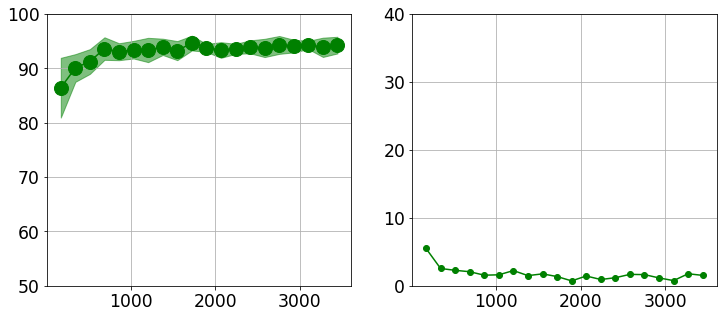

In [ ]:
import matplotlib.pyplot as plt

n = np.linspace(.05, 1.0, 20)

X_train_val= pd.DataFrame(df.iloc[:, 1:].values)   #pd.DataFrame(labelled.iloc[:, :].values)
train_sizes =  X_train_val.shape[0]* n
print(train_sizes)
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)

_, axes = plt.subplots(1, 2, figsize=(12, 5))

#plt.plot(train_sizes, np.mean(score_tot, 0))

# Plot the learning curve for the deep one class network (TPR versus training dataset size)
axes[0].grid()
axes[0].fill_between(train_sizes, 
                    test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.5,
                         color="g")

axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", markersize=14,
                 label="Cross-validation score")

axes[0].set_ylim(50, 100)

# Plot showing the 
axes[1].grid()
axes[1].plot(train_sizes,test_scores_std, 'o-', color="g",
                 label="Cross-validation score")
axes[1].set_ylim(0, 40) 


In [ ]:
# Save the evaluation results for comparison with the standrard models
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std
deepsvdd_acc 

array([86.44175921, 90.06885611, 91.26059   , 93.64139974, 93.06004658,
       93.43829109, 93.37922334, 93.96044993, 93.26294427, 94.65732271,
       93.75713032, 93.37901239, 93.5832602 , 93.96028116, 93.75700375,
       94.30886522, 94.10563   , 94.3089918 , 93.87281871, 94.27962669])

In [ ]:
#final
deep_svdd_std

array([5.4950041 , 2.54900057, 2.27762141, 2.07305564, 1.56067457,
       1.61848493, 2.23861163, 1.49904053, 1.75640443, 1.35986527,
       0.72395944, 1.4406427 , 0.92755038, 1.18967304, 1.68116874,
       1.64591397, 1.15996663, 0.76434046, 1.77407158, 1.53061797])

In [44]:
deepsvdd_acc = np.array([86.44175921, 90.06885611, 91.26059   , 93.64139974, 93.06004658,
       93.43829109, 93.37922334, 93.96044993, 93.26294427, 94.65732271,
       93.75713032, 93.37901239, 93.5832602 , 93.96028116, 93.75700375,
       94.30886522, 94.10563   , 94.3089918 , 93.87281871, 94.27962669])
deep_svdd_std = np.array([5.4950041 , 2.54900057, 2.27762141, 2.07305564, 1.56067457,
       1.61848493, 2.23861163, 1.49904053, 1.75640443, 1.35986527,
       0.72395944, 1.4406427 , 0.92755038, 1.18967304, 1.68116874,
       1.64591397, 1.15996663, 0.76434046, 1.77407158, 1.53061797])

In [54]:
deepsvdd_acc = np.array([81.1892484 , 91.75581395, 91.93023256, 93.03454668, 93.26373441,
       93.61223458, 93.03252444, 93.73003033, 93.43950118, 93.38136164,
       92.85776879, 93.32339063, 93.55443209, 93.84563532, 92.91691945,
       93.206606  , 93.09100101, 93.26457701, 93.67290192, 93.78682171])

deep_svdd_std = np.array([5.4950041 , 2.54900057, 2.27762141, 2.07305564, 1.56067457,
       1.61848493, 2.23861163, 1.49904053, 1.75640443, 1.35986527,
       0.72395944, 1.4406427 , 0.92755038, 1.18967304, 1.68116874,
       1.64591397, 1.15996663, 0.76434046, 1.77407158, 1.53061797])

### Calculate k-fold cross validation for the deep network

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from random import Random

# Perform k-fold cross validation
import random
X_train_val=pd.DataFrame(labelled.iloc[:, :].values)
kf_score=[]
kf = KFold(n_splits = 5,  shuffle=True, random_state=0)
kf.get_n_splits(X_train_val)
scores2=[]
for train, test in kf.split(X_train_val):
  dataset = Pairs_Dataset('', train, test)  
  Random(0).shuffle(train)
  deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], 1e-5)
  deep_SVDD.set_network(net_name)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  pretrain(deep_SVDD, dataset, n_epochs=100)
  pred_train = deep_SVDD.train(dataset,n_epochs=100)
  pred_test, _, scores1, threshold = deep_one_test(deep_SVDD.trainer, dataset, deep_SVDD.net)
  scores2.append(scores1)
  score_mean = np.mean(scores2)
kf_score.append(scores2)
scores2

In [ ]:
# Print Deep Neural Network kfold Accuracy
print(np.mean(scores2, 0))
print(np.std(scores2, 0))
scores2

94.36737445230872
0.745873116098849


[93.6231884057971,
 94.4927536231884,
 93.6046511627907,
 95.63953488372093,
 94.47674418604652]

In [42]:
deep_kfold = [0.936231884057971, 0.944927536231884, 0.936046511627907,
 0.9563953488372093, 0.9447674418604652]

# Learning curves comparison

In [55]:
# Combine all the accuracy scores 
accuracy.append(test_scores_mean_ens)
accuracy.append(deepsvdd_acc)
std.append(test_scores_std_ens)
std.append(deep_svdd_std)

In [61]:
train_sizes =train_sizes/2

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


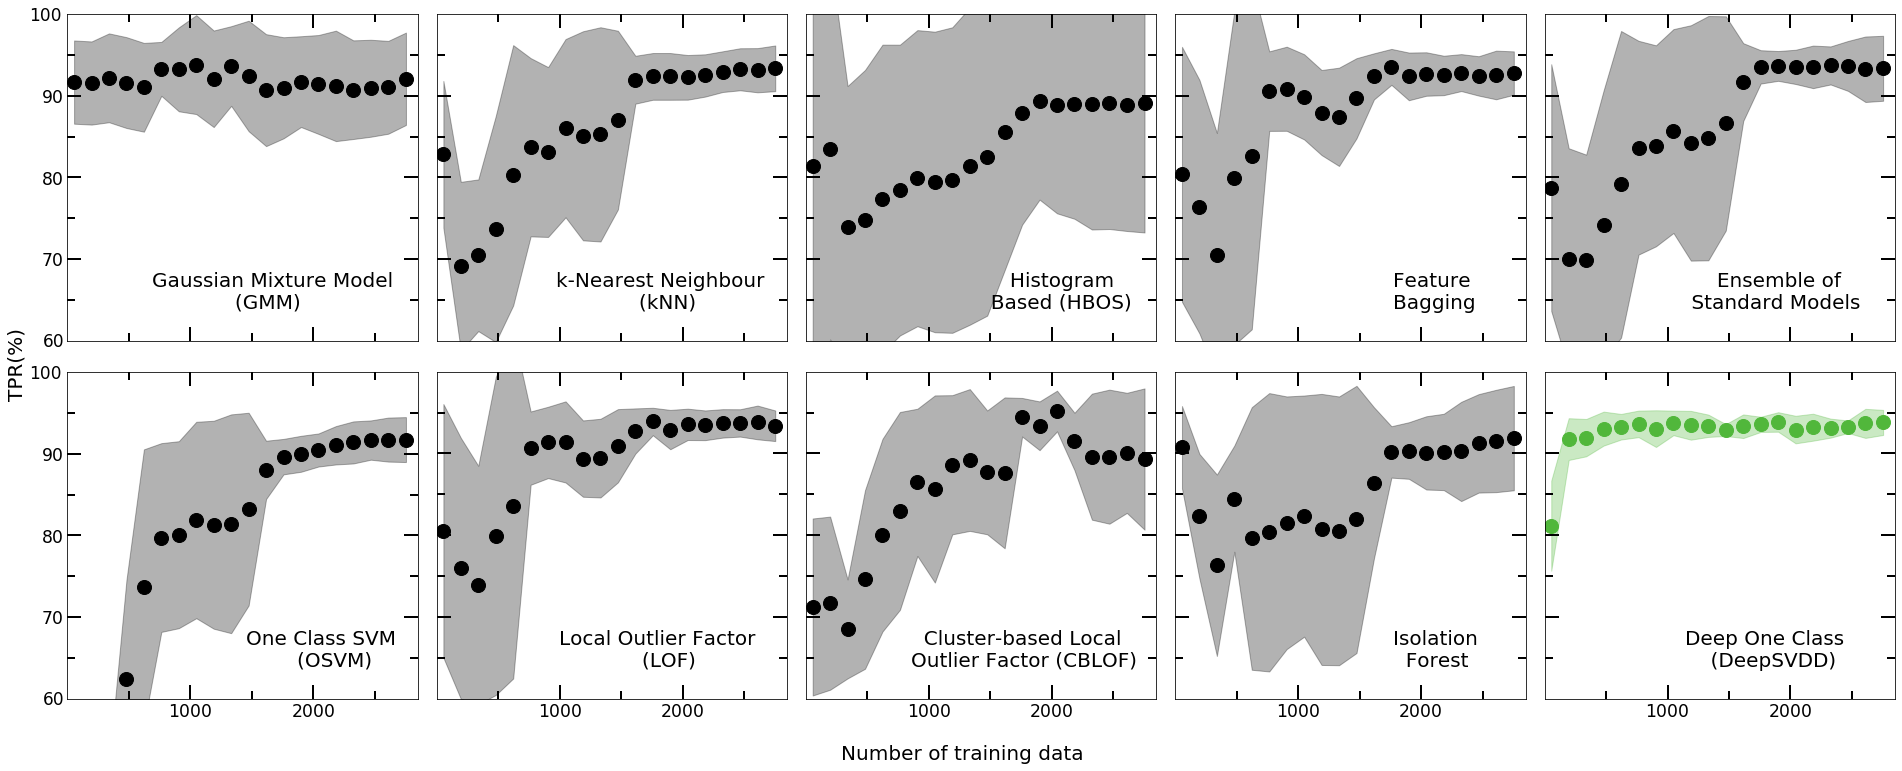

In [62]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
from matplotlib import rcParams
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(26,10),nrows=2, ncols=5,constrained_layout=True, gridspec_kw = {'wspace':0.25, 'hspace':0.25})

ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

colors = ['red', 'tan']
ax0.plot(train_sizes,accuracy[0], 'o', color="black", markersize=14, label= 'Gaussiann Mixture Model (GMM)' )
ax0.fill_between(train_sizes,accuracy[0] - std[0],  accuracy[0] + std[0], alpha=0.3,  color="black")
ax0.set_ylim(59.9, 100.1)
ax0.set_xlim(130, 2850)
ax0.text(0.24, 0.1, 'Gaussian Mixture Model\n             (GMM)', transform=ax0.transAxes,fontsize=20)
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis='x', colors='black')
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100.1, 10)
minor_ticks_y = np.arange(60, 100.1, 5)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)
ax0.set_xticklabels([])
#ax0.set_yticklabels([]) 
ax0.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.yaxis.get_major_ticks()[-1].draw = lambda *args:None
#ax0.yaxis.majorTicks[0].tick1line.set_markersize(0)
#ax0.yaxis.majorTicks[-1].tick1line.set_markersize(0)
ax0.text(-0.0712, -0.015, '60', transform=ax0.transAxes, fontsize= 17)
ax0.text(-0.11, 0.978, '100', transform=ax0.transAxes, fontsize= 17)

# kNN
ax1.plot(train_sizes, accuracy[1], 'o', color="black", markersize=14, label= 'K Nearest Neighbors (KNN)' )
ax1.fill_between(train_sizes,accuracy[1] - std[1],  accuracy[1] + std[1], alpha=0.3,  color="black")
ax1.set_ylim(60, 100)
ax1.set_xlim(130, 2850)
ax1.text(0.34, 0.1, 'k-Nearest Neighbour\n             (kNN)', transform=ax1.transAxes,fontsize=20)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax1.yaxis.get_major_ticks()[0].draw = lambda *args:None

# HBOS 
ax2.plot(train_sizes, accuracy[2], 'o', color="black",markersize=14, label= 'Histogram-base Outlier Detection (HBOS)' )
ax2.fill_between(train_sizes, accuracy[2] - std[2],  accuracy[2] + std[2], alpha=0.3,  color="black")
ax2.set_ylim(60, 100)
#ax2.set_title('Histogram Based (HBOS)', fontsize=20, y=1.02)  #fontweight='bold', 
ax2.set_xlim(130, 2850)
ax2.text(0.49, 0.1, '     Histogram\n  Based (HBOS)', transform=ax2.transAxes,fontsize=20)
ax2.spines['bottom'].set_color('black')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.tick_params(axis = 'both', which='both', width=2)
ax2.tick_params(axis='x', colors='black')
ax2.tick_params(axis = 'both', which='major', length=14)
ax2.tick_params(axis = 'both', which='minor', length=8, color='black')
ax2.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax2.set_xticks(major_ticks_x)
ax2.set_xticks(minor_ticks_x, minor=True)
ax2.set_yticks(major_ticks_y)
ax2.set_yticks(minor_ticks_y, minor=True)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax2.yaxis.get_major_ticks()[0].draw = lambda *args:None

# Feature Bagging
ax3.plot(train_sizes,accuracy[3], 'o', color="black", markersize=14, label= 'Feature Bagging' )
ax3.fill_between(train_sizes, accuracy[3] - std[3],  accuracy[3] + std[3], alpha=0.3,  color="black")
ax3.set_ylim(60, 100)
ax3.set_xlim(130, 2850)
ax3.text(0.62, 0.1, 'Feature\nBagging', transform=ax3.transAxes,fontsize=20)
ax3.spines['bottom'].set_color('black')
ax3.spines['top'].set_color('black')
ax3.spines['right'].set_color('black')
ax3.spines['left'].set_color('black')
ax3.tick_params(axis = 'both', which='both', width=2)
ax3.tick_params(axis='x', colors='black')
ax3.tick_params(axis = 'both', which='major', length=14)
ax3.tick_params(axis = 'both', which='minor', length=8, color='black')
ax3.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax3.set_xticks(major_ticks_x)
ax3.set_xticks(minor_ticks_x, minor=True)
ax3.set_yticks(major_ticks_y)
ax3.set_yticks(minor_ticks_y, minor=True)
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax3.yaxis.get_major_ticks()[0].draw = lambda *args:None

# Isolation Forest
ax8.plot(train_sizes,accuracy[4], 'o', color="black",markersize=14, label= 'Isolation Forest' )
ax8.fill_between(train_sizes,accuracy[4] - std[4],  accuracy[4] + std[4], alpha=0.3,  color="black")
ax8.set_ylim(60, 100)
ax8.set_xlim(130, 2850)
ax8.text(0.62, 0.1, 'Isolation\n  Forest', transform=ax8.transAxes,fontsize=20)
ax8.spines['bottom'].set_color('black')
ax8.spines['top'].set_color('black')
ax8.spines['right'].set_color('black')
ax8.spines['left'].set_color('black')
ax8.tick_params(axis = 'both', which='both', width=2)
ax8.tick_params(axis='x', colors='black')
ax8.tick_params(axis = 'both', which='major', length=14)
ax8.tick_params(axis = 'both', which='minor', length=8, color='black')
ax8.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax8.set_xticks(major_ticks_x)
ax8.set_xticks(minor_ticks_x, minor=True)
ax8.set_yticks(major_ticks_y)
ax8.set_yticks(minor_ticks_y, minor=True)
ax8.set_yticklabels([])
#ax8.set_xticklabels([])  #
ax8.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax8.yaxis.get_major_ticks()[0].draw = lambda *args:None

# OCSVM
ax5.plot(train_sizes, accuracy[5], 'o', color="black", markersize= 14, label= 'One class SVM (OCSVM)' )
ax5.fill_between(train_sizes, accuracy[5]- std[5],  accuracy[5] + std[5], alpha=0.3,  color="black")
ax5.set_ylim(59.9, 100.1)
ax5.set_xlim(130, 2850)
ax5.text(0.51, 0.1, 'One Class SVM\n        (OSVM)', transform=ax5.transAxes,fontsize=20)
ax5.spines['bottom'].set_color('black')
ax5.spines['top'].set_color('black')
ax5.spines['right'].set_color('black')
ax5.spines['left'].set_color('black')
ax5.tick_params(axis = 'both', which='both', width=2)
ax5.tick_params(axis='x', colors='black')
ax5.tick_params(axis = 'both', which='major', length=14)
ax5.tick_params(axis = 'both', which='minor', length=8, color='black')
ax5.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100.1, 10)
minor_ticks_y = np.arange(60, 100.1, 5)
ax5.set_xticks(major_ticks_x)
ax5.set_xticks(minor_ticks_x, minor=True)
ax5.set_yticks(major_ticks_y)
ax5.set_yticks(minor_ticks_y, minor=True)
ax5.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax5.yaxis.get_major_ticks()[0].draw = lambda *args:None
#ax5.set_xticklabels([])
#ax5.set_yticklabels([])
#ax5.yaxis.majorTicks[0].tick1line.set_markersize(0)
#ax5.yaxis.majorTicks[-1].tick1line.set_markersize(0)
ax5.yaxis.get_major_ticks()[-1].draw = lambda *args:None
ax5.text(-0.0712, -0.015, '60', transform=ax5.transAxes, fontsize= 17)
ax5.text(-0.11, 0.978, '100', transform=ax5.transAxes, fontsize= 17)

# LOF
ax6.plot(train_sizes, accuracy[6], 'o', color="black", markersize=14,label= 'Local Outlier Factor (LOF)' )
ax6.fill_between(train_sizes,accuracy[6] - std[6],  accuracy[6] + std[6], alpha=0.3,  color="black")
ax6.set_ylim(60, 100)
ax6.set_xlim(130, 2850)
ax6.text(0.35, 0.1, 'Local Outlier Factor\n             (LOF)', transform=ax6.transAxes,fontsize=20)
ax6.spines['bottom'].set_color('black')
ax6.spines['top'].set_color('black')
ax6.spines['right'].set_color('black')
ax6.spines['left'].set_color('black')
ax6.tick_params(axis = 'both', which='both', width=2)
ax6.tick_params(axis='x', colors='black')
ax6.tick_params(axis = 'both', which='major', length=14)
ax6.tick_params(axis = 'both', which='minor', length=8, color='black')
ax6.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax6.set_xticks(major_ticks_x)
ax6.set_xticks(minor_ticks_x, minor=True)
ax6.set_yticks(major_ticks_y)
ax6.set_yticks(minor_ticks_y, minor=True)
ax6.set_yticklabels([])
#ax6.set_xticklabels([])
ax6.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax6.yaxis.get_major_ticks()[0].draw = lambda *args:None

# CBLOF
ax7.plot(train_sizes, accuracy[7], 'o', color="black",markersize= 14, label= 'Cluster Based Local Outlier Factor(CBLOF)' )
ax7.fill_between(train_sizes,accuracy[7] - std[7], accuracy[7] + std[7], alpha=0.3,  color="black")
ax7.set_ylim(60, 100)
ax7.set_xlim(130, 2850)
ax7.text(0.3, 0.1, '  Cluster-based Local\nOutlier Factor (CBLOF)', transform=ax7.transAxes,fontsize=20)
ax7.spines['bottom'].set_color('black')
ax7.spines['top'].set_color('black')
ax7.spines['right'].set_color('black')
ax7.spines['left'].set_color('black')
ax7.tick_params(axis = 'both', which='both', width=2)
ax7.tick_params(axis='x', colors='black')
ax7.tick_params(axis = 'both', which='major', length=14)
ax7.tick_params(axis = 'both', which='minor', length=8, color='black')
ax7.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax7.set_xticks(major_ticks_x)
ax7.set_xticks(minor_ticks_x, minor=True)
ax7.set_yticks(major_ticks_y)
ax7.set_yticks(minor_ticks_y, minor=True)
ax7.set_yticklabels([])
#ax7.set_xticklabels([])
ax7.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.yaxis.get_major_ticks()[0].draw = lambda *args:None

# DeepSVDD
ax9.plot(train_sizes, accuracy[9], 'o', color="#51b73b",markersize =14, label= 'DeepSVDD')
ax9.fill_between(train_sizes, accuracy[9] - std[9],  accuracy[9] + std[9], alpha=0.3,  color='#51b73b')   #'#028f1e')
ax9.set_ylim(60, 100)
ax9.set_xlim(130, 2850)
ax9.text(0.4, 0.1, 'Deep One Class\n    (DeepSVDD)', transform=ax9.transAxes,fontsize=20)
ax9.spines['bottom'].set_color('black')
ax9.spines['top'].set_color('black')
ax9.spines['right'].set_color('black')
ax9.spines['left'].set_color('black')
ax9.tick_params(axis = 'both', which='both', width=2)
ax9.tick_params(axis='x', colors='black')
ax9.tick_params(axis = 'both', which='major', length=14)
ax9.tick_params(axis = 'both', which='minor', length=8, color='black')
ax9.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax9.set_xticks(major_ticks_x)
ax9.set_xticks(minor_ticks_x, minor=True)
ax9.set_yticks(major_ticks_y)
ax9.set_yticks(minor_ticks_y, minor=True)
ax9.set_yticklabels([])
#ax9.set_xticklabels([])
ax9.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax9.yaxis.get_major_ticks()[0].draw = lambda *args:None


# Ensemble
ax4.plot(train_sizes, accuracy[8], 'o', markersize=14, color="black", label='Ensemble') 
ax4.fill_between(train_sizes, accuracy[8] - std[8],  accuracy[8] + std[8], alpha=0.3,  color="black")
ax4.set_ylim(60, 100)
ax4.set_xlim(130, 2850)
ax4.text(0.4, 0.1, '     Ensemble of\n Standard Models', transform=ax4.transAxes,fontsize=20)
ax4.spines['bottom'].set_color('black')
ax4.spines['top'].set_color('black')
ax4.spines['right'].set_color('black')
ax4.spines['left'].set_color('black')
ax4.tick_params(axis = 'both', which='both', width=2)
ax4.tick_params(axis='x', colors='black')
ax4.tick_params(axis = 'both', which='major', length=14)
ax4.tick_params(axis = 'both', which='minor', length=8, color='black')
ax4.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax4.set_xticks(major_ticks_x)
ax4.set_xticks(minor_ticks_x, minor=True)
ax4.set_yticks(major_ticks_y)
ax4.set_yticks(minor_ticks_y, minor=True)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax4.yaxis.get_major_ticks()[0].draw = lambda *args:None


import matplotlib.font_manager
rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"]= "bold"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid']=False
rcParams['patch.edgecolor'] = 'black'


#fig.tight_layout()
fig.text(0.5, -0.05, 'Number of training data', ha='center',fontsize=20 )
fig.text(-0.01, 0.5, 'TPR(%)', va='center', rotation='vertical', fontsize=20)

#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/figure4_new.png', rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

Text(0.33, -0.05, 'Number of training data')

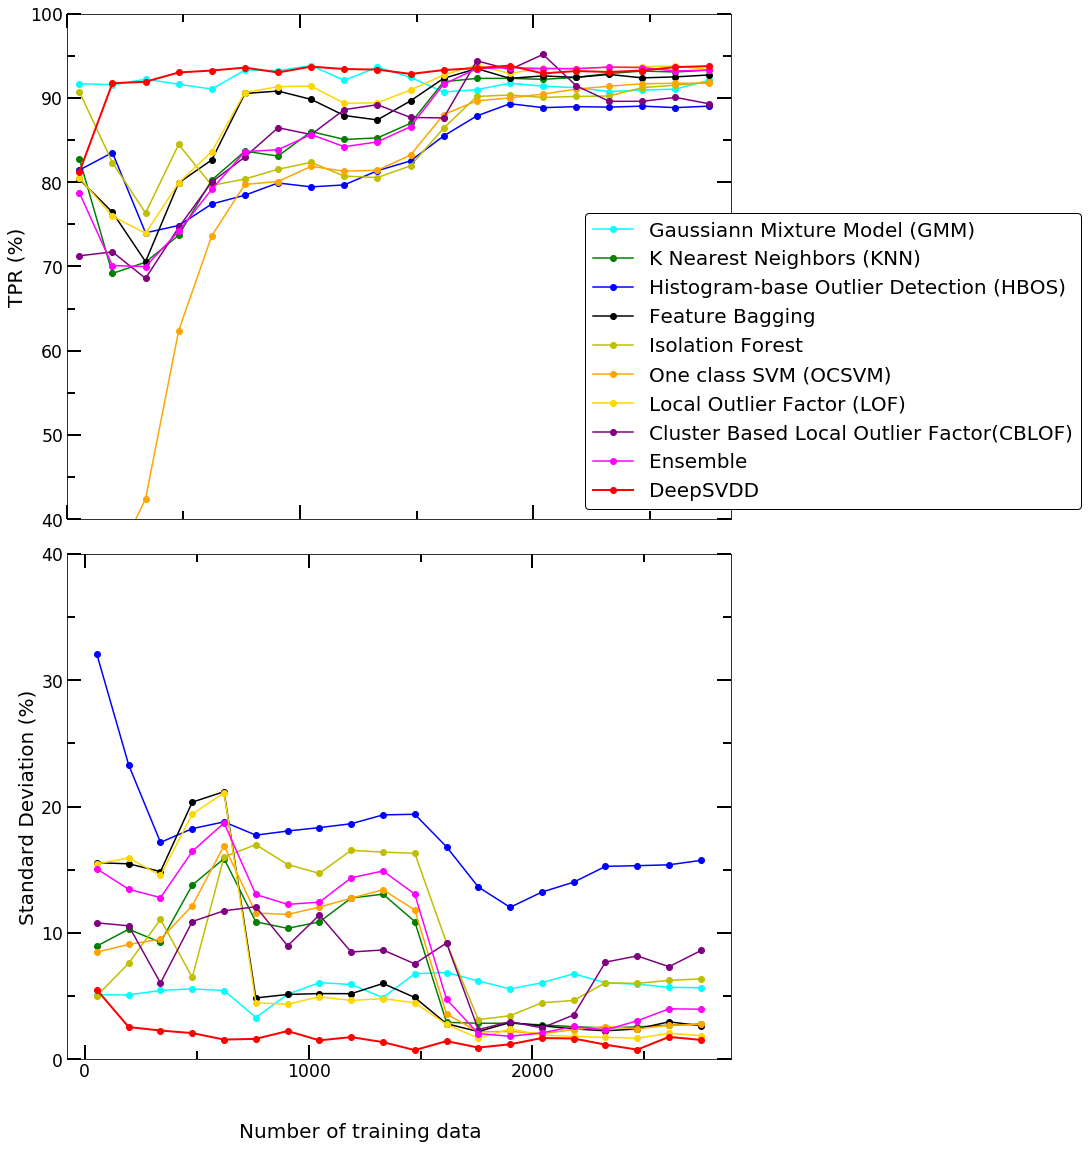

In [63]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
fig, axes = plt.subplots(figsize=(15,15),nrows=2, ncols=1,constrained_layout=True, gridspec_kw = {'wspace':0.25, 'hspace':0.25})

ax0, ax1= axes.flatten()


ax0.plot(train_sizes,accuracy[0], 'o-', color="cyan", label= 'Gaussiann Mixture Model (GMM)' )
ax0.plot(train_sizes, accuracy[1], 'o-', color="g", label= 'K Nearest Neighbors (KNN)' )
ax0.plot(train_sizes, accuracy[2], 'o-', color="b", label= 'Histogram-base Outlier Detection (HBOS)' )
ax0.plot(train_sizes,accuracy[3], 'o-', color="black", label= 'Feature Bagging' )
ax0.plot(train_sizes,accuracy[4], 'o-', color="y", label= 'Isolation Forest' )
ax0.plot(train_sizes, accuracy[5], 'o-', color="orange", label= 'One class SVM (OCSVM)' )
ax0.plot(train_sizes, accuracy[6], 'o-', color="gold", label= 'Local Outlier Factor (LOF)' )
ax0.plot(train_sizes, accuracy[7], 'o-', color="purple", label= 'Cluster Based Local Outlier Factor(CBLOF)' )
ax0.plot(train_sizes, accuracy[8], 'o-', color="magenta", label='Ensemble') 
ax0.plot(train_sizes, accuracy[9], 'o-', color="red", label= 'DeepSVDD', linewidth=2.0)
ax0.set_ylim(40, 100)
ax0.set_xlim(130, 2850)
#ax0.text(0.24, 0.1, 'Gaussian Mixture Model\n             (GMM)', transform=ax0.transAxes,fontsize=20)
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis='x', colors='black')
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(40, 100.1, 10)
minor_ticks_y = np.arange(40, 100.1, 5)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)
ax0.set_xticklabels([])
#ax0.set_yticklabels([]) 
ax0.set_ylabel('TPR (%)', fontsize=20)


ax1.set_ylim(0, 40)
ax1.plot(train_sizes, std[0], 'o-', color="cyan", label= 'Gaussiann Mixture Model (GMM)' )
ax1.plot(train_sizes, std[1], 'o-', color="g", label= 'K Nearest Neighbors (KNN)' )
ax1.plot(train_sizes, std[2], 'o-', color="b", label= 'Histogram-base Outlier Detection (HBOS)' )
ax1.plot(train_sizes, std[3], 'o-', color="black", label= 'Feature Bagging' )
ax1.plot(train_sizes, std[4], 'o-', color="y", label= 'Isolation Forest' )
ax1.plot(train_sizes, std[5], 'o-', color="orange", label= 'One class SVM (OCSVM)' )
ax1.plot(train_sizes, std[6], 'o-', color="gold", label= 'Local Outlier Factor (LOF)' )
ax1.plot(train_sizes, std[7], 'o-', color="purple", label= 'Cluster Based Local Outlier Factor(CBLOF)' )
ax1.plot(train_sizes, std[8], 'o-', color="magenta", label= 'Ensemble' )
ax1.plot(train_sizes, std[9], 'o-', color="red", label= 'DeepSVDD', linewidth=2.0)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(0, 40.1, 10)
minor_ticks_y = np.arange(0, 40.1, 5)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)
ax1.set_ylabel('Standard Deviation (%)', fontsize=20)

ax0.legend(prop={'size': 20},  loc=(0.78, 0.02), facecolor='white', framealpha=1, edgecolor='black')

fig.text(0.33, -0.05, 'Number of training data', ha='center',fontsize=20 )
#plt.savefig('/content/drive/My Drive/cocrystal_design/figures_si/learning_curves_si.png', rasterized=True,  bbox_inches="tight", dpi=600)


# k-fold cross validation comparison

In [48]:
val_list.append(ens_kfold )
val_list.append(deep_kfold)

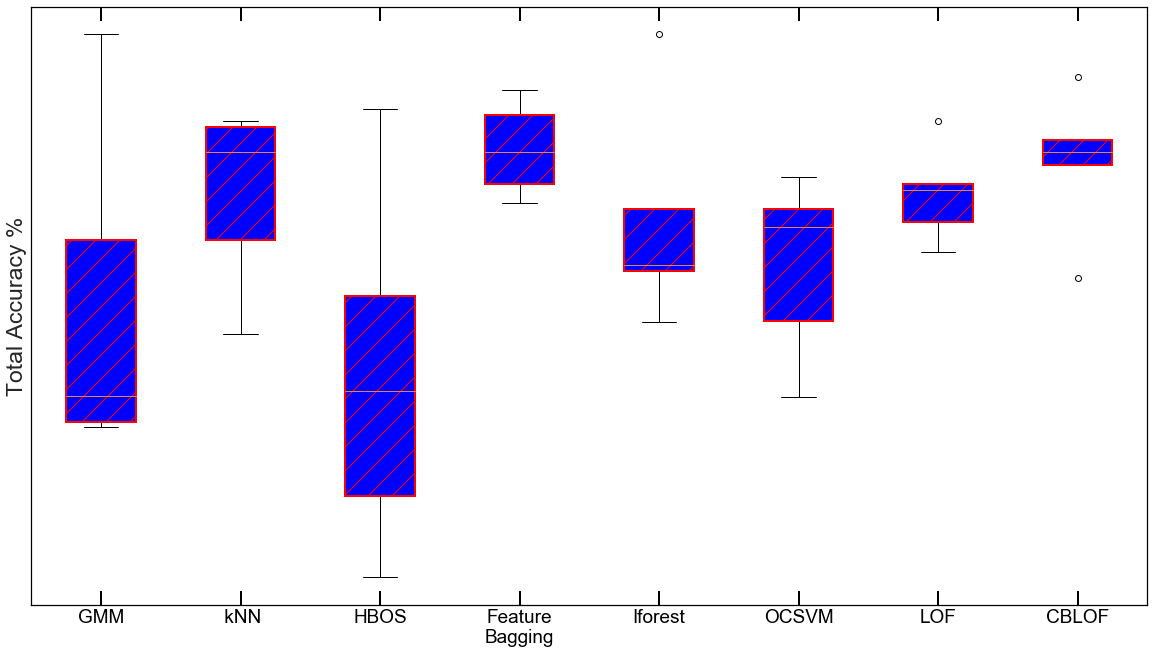

In [55]:
# Box plot with scores
#Import the accuracies table 

# Accuracy on the known data 
import seaborn as sns


data1 = val_list #[model_acc.GMM , model_acc.kNN ,model_acc.HBOS  ,model_acc.Feat_bag ,model_acc.Iforest ,model_acc.OCSVM ,model_acc.LOF ,model_acc.CBLOF ,model_acc.Ensemble ,model_acc.DeepSVDD ]

sns.set(rc={'figure.figsize':(20 ,11)})
sns.set_style("whitegrid", {'axes.grid' : False})

fig1, ax1 = plt.subplots()
#ax1.set_ylim(70, 100)
#ax1.set_yticks([80, 90 ,100])
ax1.set_xticklabels(['GMM', ' kNN', 'HBOS', 'Feature\nBagging',   'Iforest', 'OCSVM',  'LOF', 'CBLOF', 'Ensemble', 'DeepSVDD' ])
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_y = np.arange(70, 100.1, 10)
minor_ticks_y = np.arange(70, 100.1, 5)

ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)
bp0=ax1.boxplot(data1, patch_artist=True)

for box in bp0['boxes']:
    # change outline color
    box.set(color='red', linewidth=2)
    # change fill color
    box.set(facecolor = 'blue' )
    # change hatch
    box.set(hatch = '/')
#plt.xlabel('One class classification models',  fontsize=18)
plt.ylabel('Total Accuracy %', fontsize=23 )
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
#plt.title('AUC=%.3f,   F1-score=%.3f' % (auc, f1) ,fontsize=18)
ax1.xaxis.label.set_color('black')
ax1.tick_params(axis='x', colors='black')
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')
#plt.savefig("box_plots.png", dpi=600)




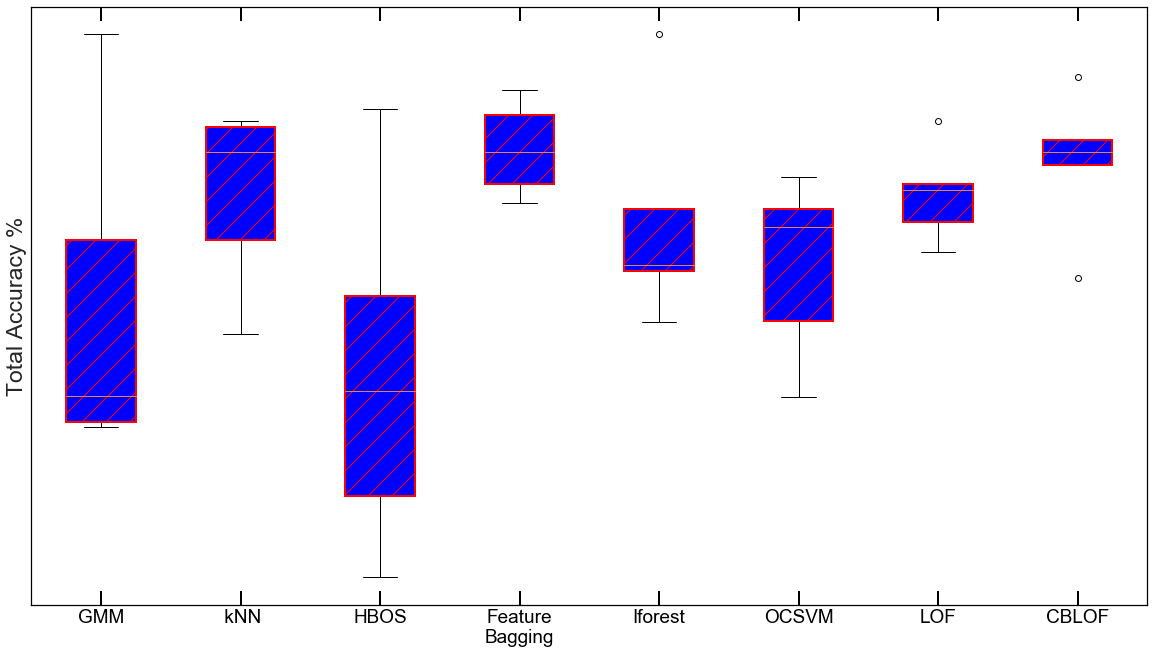

In [56]:
# Box plot with scores
#Import the accuracies table 

# Accuracy on the known data 

#model_acc = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/kfold_accuracy.csv')
data1 = val_list


sns.set(rc={'figure.figsize':(20 ,11)})
sns.set_style("whitegrid", {'axes.grid' : False})

fig1, ax1 = plt.subplots()
#ax1.set_ylim(70, 100)
#ax1.set_yticks([80, 90 ,100])
ax1.set_xticklabels(['GMM', ' kNN', 'HBOS', 'Feature\nBagging',   'Iforest', 'OCSVM',  'LOF', 'CBLOF', 'Ensemble', 'DeepSVDD' ])
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_y = np.arange(70, 100.1, 10)
minor_ticks_y = np.arange(70, 100.1, 5)

ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)

red_square = dict(markerfacecolor='r', marker='s')
bp0=ax1.boxplot(data1, patch_artist=True )#, showfliers=True, whis='range', vert=True,  flierprops=red_square)

for box in bp0['boxes']:
    # change outline color
    box.set(color='red', linewidth=2)
    # change fill color
    box.set(facecolor = 'blue' )
    # change hatch
    box.set(hatch = '/')
#plt.xlabel('One class classification models',  fontsize=18)
plt.ylabel('Total Accuracy %', fontsize=23 )
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
#plt.title('AUC=%.3f,   F1-score=%.3f' % (auc, f1) ,fontsize=18)
ax1.xaxis.label.set_color('black')
ax1.tick_params(axis='x', colors='black')
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')

# Scores distribution of the standard one class models

In [104]:
#model_scores = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data_test/model_scores.csv')       
model_scores = pd.read_pickle('/content/drive/My Drive/cocrystal_design-master/data_test/model_scores.pkl') 
deep_scores = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data_test/deep_scores_100-100_fin1.csv')
  

In [105]:
model_scores

,gmm1,knn1,hbos1,feat_bag,ifor1,ocsvm1,lof1,cblof1,ens
0,0.691575,0.557694,0.421483,0.810719,0.648074,0.117586,0.882286,0.718967,0.632528
1,0.498174,0.342286,0.341724,0.326921,0.473766,0.014637,0.456751,0.617384,0.389817
2,0.996109,0.933331,0.900662,0.979496,0.972670,0.741551,0.950110,0.890449,0.958155
3,0.694048,0.597889,0.293129,0.638090,0.374545,0.202982,0.706894,0.767950,0.545205
4,0.589416,0.500046,0.329792,0.355123,0.547832,0.046388,0.000000,0.663808,0.370496
...,...,...,...,...,...,...,...,...,...
25175,0.914761,0.665413,0.405562,0.883774,0.718976,0.261863,0.952693,0.675601,0.697408
25176,0.839661,0.638360,0.437827,0.886911,0.650134,0.196016,0.927097,0.633898,0.659936
25177,0.892569,0.629710,0.359590,0.806775,0.698474,0.233015,0.840982,0.651057,0.643230
25178,0.809651,0.634258,0.391855,0.777447,0.657829,0.260670,0.795317,0.680684,0.639219


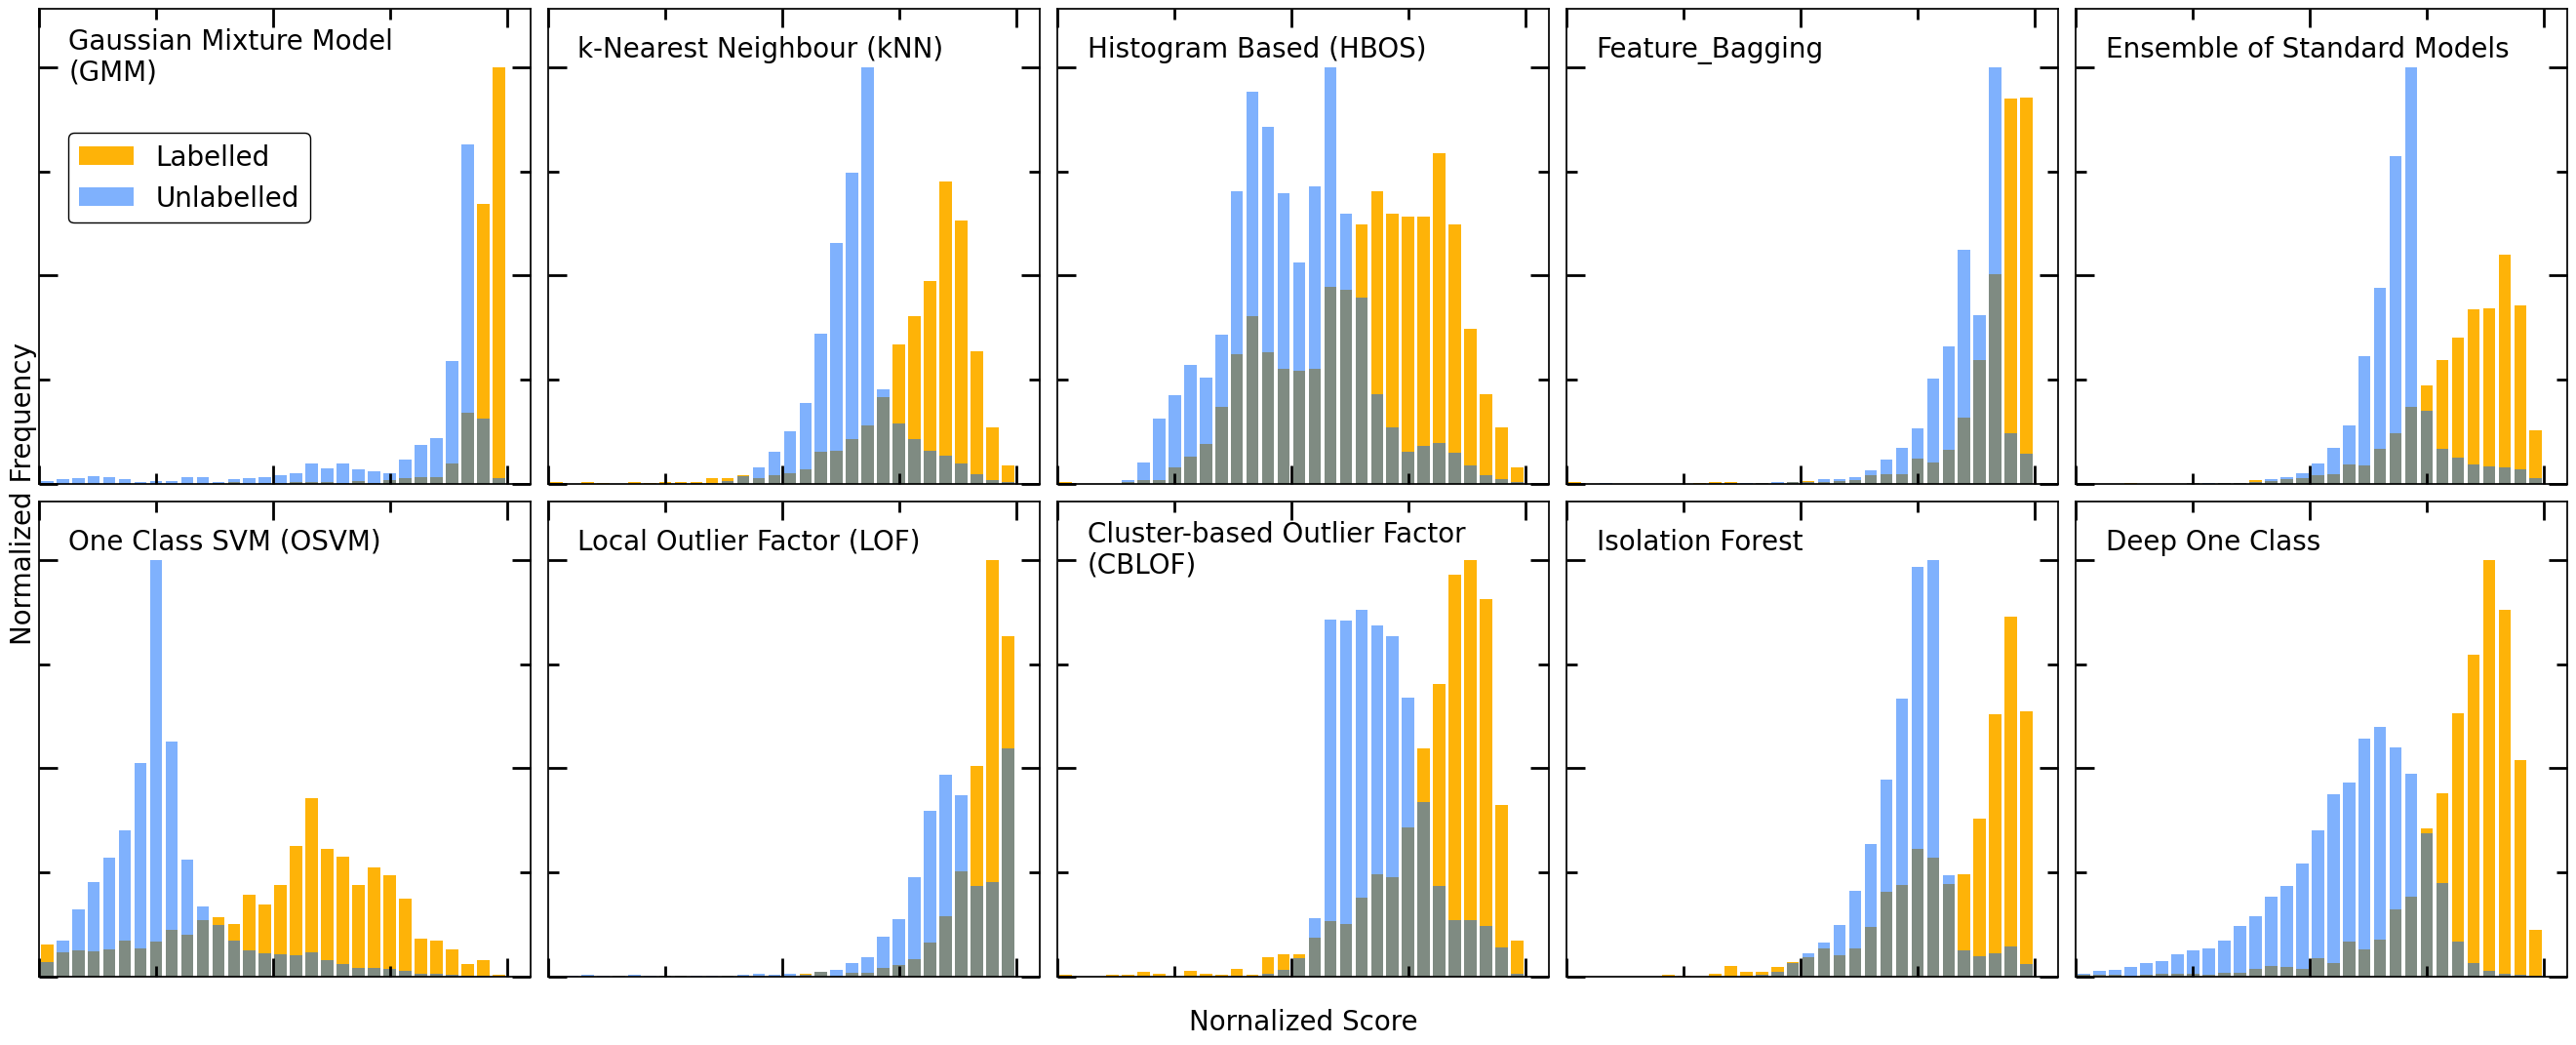

In [119]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
import matplotlib.font_manager
from matplotlib import rcParams
import matplotlib.pyplot as plt


fig, axes = plt.subplots(figsize=(26, 10), nrows=2, ncols=5,
                         constrained_layout=True, gridspec_kw={'wspace': 0.05, 'hspace': 0.1})

ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"] = "bold"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"


major_ticks_x = np.arange(0, 1.1, 0.5)
minor_ticks_x = np.arange(0, 1.1, 0.25)
major_ticks_y = np.arange(0, 1.1, 0.5)
minor_ticks_y = np.arange(0, 1.1, 0.25)

n_bins = 30


def set_ticks(ax):
    ax.tick_params(axis='both', which='both', direction="in", width=2)
    ax.tick_params(axis='both', which='major', direction="in",  length=14)
    ax.tick_params(axis='both', which='minor', length=8,
                   direction="in",  color='black')
    ax.tick_params(axis='both', which='both', bottom=True,
                  top=True, left=True, right=True, direction="in")
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    #ax.tick_params(axis='both', top='off', bottom='off', left='off', right='off')
    #ax.xaxis.set_ticks_position('none') 
    #ax.yaxis.set_ticks_position('none') 
    #ax.set_xticks([], minor=True)
    #ax.set_yticks([], minor=True)


def set_spines(ax):
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')


def set_prop(ax):
    ax.axis(aspect='equal')
    ax.set(adjustable='box')  # , aspect='equal')
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1.14)
    ax.grid(False)
    set_spines(ax)
    ax.set_facecolor('xkcd:white')
    ax.axis('on')
    #set_ticks(ax)

def norm_plot(ax, x, y, alpha=1, **kwargs):
    hist, bins = np.histogram(x, **kwargs)
    hist1, _ = np.histogram(y, **kwargs)
    n_max = np.max([hist, hist1])
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax.bar(center, hist / n_max, align='center', width = width, alpha=alpha)
    return hist, n_max


def lab_unlab_plot(ax, lab_d, unlab_d, n_bins):
    hist_lab, bins_lab = np.histogram(lab_d, bins=n_bins, density=True, range=(0,1))
    hist_unlab, bins_unlab = np.histogram(unlab_d, bins=n_bins, density=True, range=(0,1))
    n_max = np.max([hist_lab, hist_unlab])
    width_lab = 0.8 * (bins_lab[1] - bins_lab[0])
    width_unlab = 0.8 * (bins_unlab[1] - bins_unlab[0])
    center_lab = (bins_lab[:-1] + bins_lab[1:]) / 2
    center_unlab = (bins_unlab[:-1] + bins_unlab[1:]) / 2
    ax.bar(center_lab, hist_lab / n_max, align='center', width=width_lab, alpha=1, color='#feb308', label = 'Labelled')
    ax.bar(center_unlab, hist_unlab / n_max, align='center', width=width_unlab, alpha=0.5, color='#0165fc', label = 'Unlabelled')



# Gaussian Mixture Model
lab_unlab_plot(ax0, model_scores.gmm1[:3444], model_scores.gmm1[3444:], n_bins)
# ax0.axis(aspect='equal')
ax0.text(0.06, 0.85, 'Gaussian Mixture Model\n(GMM)',
         transform=ax0.transAxes, ha="left", fontsize=20)
#ax0.legend(prop={'size': 20}, loc=(0.02, 0.65), facecolor='white', framealpha=0)
ax0.legend(prop={'size': 20}, loc=(0.06, 0.55), facecolor='white', edgecolor='black', framealpha=1)#,  borderpad=1 ) #shadow=True, fancybox=True, loc=(0.75, -0.15),
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# knn
n_bins = 30
lab_unlab_plot(ax1, model_scores.knn1[:1722], model_scores.knn1[1722:], n_bins)
ax1.text(0.06, 0.9, 'k-Nearest Neighbour (kNN)',
         transform=ax1.transAxes, ha="left", fontsize=20)
#ax1.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

# HBOS
lab_unlab_plot(ax2, model_scores.hbos1[:1722], model_scores.hbos1[1722:], n_bins)
ax2.text(0.06, 0.9, 'Histogram Based (HBOS)',
         transform=ax2.transAxes, ha="left", fontsize=20)
#ax2.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

# Feature Bagging
lab_unlab_plot(ax3, model_scores.feat_bag[:1722], model_scores.feat_bag[1722:], n_bins)
ax3.text(0.06, 0.9, 'Feature_Bagging',
         transform=ax3.transAxes, ha="left", fontsize=20)
#ax3.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax3.set_xticklabels([])
ax3.set_yticklabels([])

# Isolation Forest
lab_unlab_plot(ax8, model_scores.ifor1[:1722], model_scores.ifor1[1722:], n_bins)
ax8.text(0.06, 0.9, 'Isolation Forest',
         transform=ax8.transAxes, ha="left", fontsize=20)
#ax8.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax8.set_xticklabels([])
ax8.set_yticklabels([])

# OCSVM
lab_unlab_plot(ax5, model_scores.ocsvm1[:1722], model_scores.ocsvm1[1722:], n_bins)
ax5.text(0.06, 0.9, 'One Class SVM (OSVM)',
         transform=ax5.transAxes, ha="left", fontsize=20)
#ax5.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax5.set_xticklabels([])
ax5.set_yticklabels([])

# LOF
lab_unlab_plot(ax6, model_scores.lof1[:1722], model_scores.lof1[1722:], n_bins)
ax6.text(0.06, 0.9, 'Local Outlier Factor (LOF)',
         transform=ax6.transAxes, ha="left", fontsize=20)
#ax6.legend(prop={'size': 20}, loc=(0.02, 0.65),
 #          facecolor='white', framealpha=0)
ax6.set_xticklabels([])
ax6.set_yticklabels([])


# CBLOF
lab_unlab_plot(ax7, model_scores.cblof1[:1722], model_scores.cblof1[1722:], n_bins)
ax7.text(0.06, 0.85, 'Cluster-based Outlier Factor\n(CBLOF)',
         transform=ax7.transAxes, ha="left", fontsize=20)
#ax7.legend(prop={'size': 20}, loc=(0.02, 0.65),
 #          facecolor='white', framealpha=0)
ax7.set_xticklabels([])
ax7.set_yticklabels([])

# DeepSVDD
lab_unlab_plot(ax9, deep_scores.score[:1722], deep_scores.score[1722:], n_bins)
ax9.text(0.06, 0.9, 'Deep One Class',
         transform=ax9.transAxes, ha="left", fontsize=20)
#ax9.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax9.set_xticklabels([])
ax9.set_yticklabels([])

# Ensemble
lab_unlab_plot(ax4, model_scores.ens[:1722], model_scores.ens[1722:], n_bins)
ax4.text(0.06, 0.9, 'Ensemble of Standard Models', 
        transform=ax4.transAxes, ha="left", fontsize=20)
#ax4.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax4.set_xticklabels([])
ax4.set_yticklabels([])

for ax in axes.flatten():
  set_prop(ax)
  set_ticks(ax)

fig.tight_layout()


fig.text(0.5, -0.05, 'Nornalized Score', ha='center',fontsize=20 )
fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical', fontsize=20)
plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/figure2_new.svg', rasterized=True,  bbox_inches="tight", dpi=600)

plt.show()


# Scores correlation between deep one class and the ensemble

In [113]:
ense = pd.read_pickle('/content/drive/My Drive/cocrystal_design-master/data_test/ensemble_score.pkl')      
ens = ense.iloc[:, 0].values

In [114]:
deep_scores = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data_test/deep_scores_100-100_fin1.csv')


In [117]:
from scipy import stats
deep=deep_scores.score.values
data = pd.concat([pd.DataFrame(deep, columns=['deep']), pd.DataFrame(ens, columns=['ens'])], axis=1)
data=data[data.deep>0]
data1 = data[data.deep>0.705]
x= data1.deep
slope, intercept, r_value, p_value, std_err = stats.linregress( data1['deep'] ,data1['ens'])
line = slope*data.deep+intercept
tzaki = pd.concat([pd.DataFrame(data.deep.values, columns=['deep']), pd.DataFrame(line.values, columns=['line'])], axis=1)

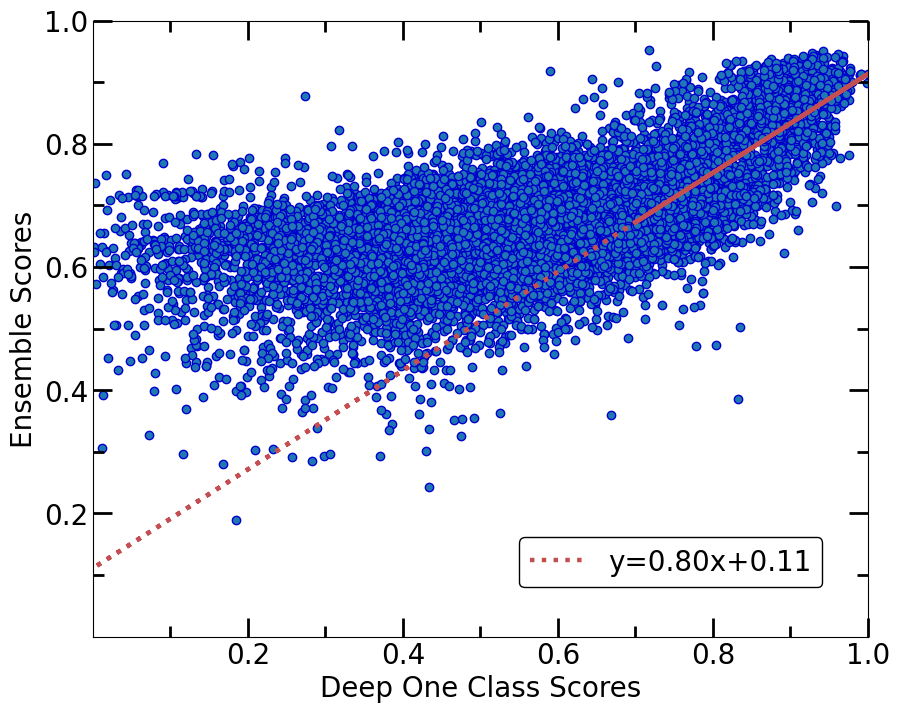

In [118]:
from matplotlib import rc
import seaborn as sns
import matplotlib.font_manager
#plt.rcParams["font.weight"] = "light"
#plt.rcParams["axes.labelweight"] = "light"
plt.rcParams['axes.facecolor'] = 'white'


plt.style.use('default')
import matplotlib.font_manager
rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"]= "normal"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid']=False

#fig = plt.figure(figsize=(10,8))
fig, ax = plt.subplots(figsize=(10,8))
rcParams["axes.edgecolor"] = "0.15"
rcParams["axes.linewidth"]  = 1.25

plt.scatter(data.deep, data.ens, edgecolors='#0000CC')
slope, intercept, r_value, p_value, std_err = stats.linregress( data.deep , data.ens)
line = slope*deep+intercept
#plt.plot(deep, line, 'r', linewidth=3.0, label='y={:.2f}x+{:.2f}'.format(slope,intercept))

#plt.legend(loc='lower right')

plt.grid(False)

plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.xlabel('Deep One Class Scores', fontsize=20)
plt.ylabel('Ensemble Scores', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
# this is an inset axes over the main axes
#a = plt.axes([.6, .15, .28, .28], facecolor='white')
#sns.regplot(x="deep", y="ens", data=data1, color='b',
 #line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept), 'color': 'red'})

#plt.scatter(data1.deep, data1.ens, edgecolors='#0000CC')
x= data1.deep
slope, intercept, r_value, p_value, std_err = stats.linregress( data1['deep'] ,data1['ens'])
line = slope*data.deep+intercept
#plt.plot(data.deep, line,  'r', linestyle='-', linewidth=3.0, dashes=(5, 2), label='y1={:.2f}x+{:.2f}'.format(slope,intercept))
plt.plot(tzaki[tzaki.deep > 0.7].deep,tzaki[tzaki.deep > 0.7].line, 'r-',  linewidth=3.2)
plt.plot(tzaki[tzaki.deep < 0.7].deep,tzaki[tzaki.deep < 0.7].line, 'r:',  linewidth=3.2, label='y={:.2f}x+{:.2f}'.format(slope,intercept))


slope, intercept, r_value, p_value, std_err = stats.linregress( data.deep , data.ens)
line = slope*deep+intercept

#plt.plot(deep, line, 'r', linewidth=3.0, label='y1={:.2f}x+{:.2f}'.format(slope,intercept))

major_ticks_x = np.arange(0, 1.001, 0.2)
minor_ticks_x = np.arange(0, 1.001, 0.1)
major_ticks_y = np.arange(0, 1.001, 0.2)
minor_ticks_y = np.arange(0, 1.001, 0.1)
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
ax.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax.yaxis.get_major_ticks()[0].draw = lambda *args:None
#plt.title('Probability')
#plt.xticks([])
#plt.yticks([])
plt.legend(prop={'size': 20}, loc=(0.55, 0.08), facecolor='white', edgecolor='black', framealpha=1 )
#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/scatter1_0.7.png', dpi=600)